## 113-2 社群媒體分析 第二次讀書會 - 1

### 文辭和文件分析

- 組別 : 第一組 
- 作者 : 劉和媛 
- 日期 : 2025/04/17

#### 載入套件

In [1]:
# import package
import os
import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import re
import jieba
import jieba.analyse
import math
from nltk import ngrams, FreqDist
from collections import Counter, namedtuple

from wordcloud import WordCloud

import networkx as nx
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity

FontPath = 'SourceHanSansTW-Regular.otf'
# fprop = fm.FontProperties(fname="SourceHanSansTW-Regular.otf")

#### 字型格式設定

In [2]:
# plt 相關設定
plt.rcParams['font.size'] = 14

# 設定圖的中文字體 
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] # Windows 中文字體

plt.rcParams["figure.figsize"] = [6, 4]
plt.rcParams["figure.dpi"] = 150

#### 資料集介紹

- 時間: 2024/11/01 ~ 2025/04/16
- 來源: PTT 八卦板、棒球板
- 關鍵字: "12強" , "經典賽" , "WBC"
- 筆數: 1484 ( 清理後 )

#### 0.0 產生MetaData

In [3]:
# 八卦版
df_G= pd.read_csv('./raw_data/20241101_20250416_G.csv')

# 刪除不需要的欄位
df_G = df_G.drop(['artPoster', 'artComment'], axis=1)

# 加一下artCatagory
df_G['artCatagory'] = 'gossiping'

print(len(df_G))
df_G.tail()

837


artUrl  \
832  https://www.ptt.cc/bbs/Gossiping/M.1730771816....   
833  https://www.ptt.cc/bbs/Gossiping/M.1730727733....   
834  https://www.ptt.cc/bbs/Gossiping/M.1730629191....   
835  https://www.ptt.cc/bbs/Gossiping/M.1730540414....   
836  https://www.ptt.cc/bbs/Gossiping/M.1730475515....   

                       artTitle     artDate  \
832  [問卦] 如何吸引大谷翔平來台  50轟? 12強?  2024-11-05   
833        [問卦] 這次12強 中華隊奪冠機率高嗎  2024-11-04   
834      [問卦] 看完道奇打洋基  再看12強好無聊  2024-11-03   
835         [問卦] 12強台灣棒球員什麼時候熱開  2024-11-02   
836   [新聞] 世界12強預賽將登場 賴清德：台灣可推動  2024-11-01   

                                            artContent artCatagory  
832  剛剛看到大谷翔平 50轟球要在101觀景台展出 想了一下如何把大谷吸引來 那就是10布置成道...   gossiping  
833  如題 大家好 相信大家都知道12強棒球賽再過幾天就準備開打啦 這次中華隊來勢洶洶 昨天以10...   gossiping  
834  道奇打洋基 高張力高戲劇性 每個都強投強打 棒子一隻比一隻大 全壘打至少看得到 回頭看12強...   gossiping  
835   今天台灣跟捷克舉行12強棒球熱身賽 結果打者幾乎熄火 台灣棒球實力不該如此 到底什麼時候才會熱開   gossiping  
836  1.媒體來源: TVBS 2.記者署名: 吳紹瑜 3.完整新聞標題: 世界12強預賽將登場 ...   gossiping

稍微看了一下八卦版的文章內容，發現文章標題大多是 [XXX]

In [ ]:
df_G['tag'] = df_G['artTitle'].str.extract(r'\[(.*?)\]')

tag_counts = df_G['tag'].value_counts()

print(tag_counts)
print(f"\n總共有 {tag_counts.sum()} 篇有tag的文章")

tag
問卦    544
新聞    265
爆卦     26
公告      1
廢文      1
Name: count, dtype: int64

總共有 837 篇有tag的文章


In [5]:
# (這兩篇好像可以不用刪除)
filter_tags = ['廢文', '公告']
filtered_df = df_G[df_G['tag'].isin(filter_tags)]
filtered_df

artUrl  \
145  https://www.ptt.cc/bbs/Gossiping/M.1740320392....   
323  https://www.ptt.cc/bbs/Gossiping/M.1735660242....   

                           artTitle     artDate  \
145  [公告] 賀！Team Tawian取得WBCQ第三名！水桶  2025-02-23   
323             [廢文] 聽說wbc台灣會再次世界冠軍  2024-12-31   

                                            artContent artCatagory tag  
145  世界第一的Team Tawian 這次取得WBCQ分組第三名 雖然不是第一名 但能拿到第三名...   gossiping  公告  
323                                         夢裏實現還是真實故事   gossiping  廢文

In [6]:
# 去除含有 "新聞" 的資料
df_G = df_G[df_G['tag'] != '新聞']
print("八卦版筆數: ", len(df_G))

# 因為發現如果只用title刪除可能會刪除不該刪的
print(df_G [df_G ['artTitle'].str.contains('新聞', na=False)])

八卦版筆數:  572
                                                artUrl              artTitle  \
36   https://www.ptt.cc/bbs/Gossiping/M.1740708231....  [問卦] 228東森新聞重播經典賽附加賽   
58   https://www.ptt.cc/bbs/Gossiping/M.1740544006....   [問卦] WBC晉級是想掩蓋什麼新聞？   
250  https://www.ptt.cc/bbs/Gossiping/M.1740142990....    [問卦] 為什麼新聞都沒有報經典賽了   
384  https://www.ptt.cc/bbs/Gossiping/M.1732786927....   [問卦] 12強棒球新聞是不是太過了?   

        artDate                                         artContent  \
36   2025-02-28  大家好大家早安，228，東森新聞目前重播經典賽附加賽台灣vs西班牙，經典戰役大家快 看，祝連...   
58   2025-02-26  記得上禮拜資格賽被打爆 一堆朋友說不想看了 結果昨天敗部復仇成功晉級 新聞台一直狂洗 才短短...   
250  2025-02-21  如題 大概快一小時前 看到新聞報Team Taiwan 轟全壘打 社群粉專瘋狂轉貼 哇 看得...   
384  2024-11-28  到今天好像洗了第三天了 還是滿滿的一小時棒球新聞 而且竟然還有報導是指出陳傑憲是皇帝命 是不...   

    artCatagory tag  
36    gossiping  問卦  
58    gossiping  問卦  
250   gossiping  問卦  
384   gossiping  問卦  


In [7]:
# 棒球版
df_B= pd.read_csv('./raw_data/20241101_20250416_B.csv')
# 不知道為甚麼扒下來有一堆Unnamed的欄位，先將其去除掉!!
df_B = df_B[['artUrl', 'artTitle', 'artDate', 'artPoster', 'artContent', 'artComment']]
# df_B = df_B.loc[:, ~df_B.columns.str.contains('^Unnamed')]

# 刪除不需要的欄位
df_B = df_B.drop(['artPoster', 'artComment'], axis=1)
# 加一下artCatagory
df_B['artCatagory'] = 'baseball'

print(len(df_B))
df_B.tail(3)

2804


C:\Users\scblu\AppData\Local\Temp\ipykernel_18936\2928543036.py:2: DtypeWarning: Columns (350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,57

artUrl  \
2801  https://www.ptt.cc/bbs/Baseball/M.1730618910.A...   
2802  https://www.ptt.cc/bbs/Baseball/M.1730619783.A...   
2803  https://www.ptt.cc/bbs/Baseball/M.1730607953.A...   

                        artTitle    artDate  \
2801  [新聞] 12強派狀態最好投手戰中華隊 韓國教練：提  2024/11/3   
2802  [新聞] 紅雀球團不放人 林振瑋無緣征戰12強賽直呼  2024/11/3   
2803  [新聞]SPC12強賽》來台喝珍奶、騎摩托車體驗 捷  2024/11/3   

                                             artContent artCatagory  
2801  https://news.tvbs.com.tw/sports/2672611 12強派狀態...    baseball  
2802  紅雀球團不放人 林振瑋無緣征戰12強賽直呼「滿可惜的」 〔記者羅志朋／台南報導〕今天12強賽...    baseball  
2803  12強賽》來台喝珍奶、騎摩托車體驗 捷克隊很融入台灣生活 記者：編輯部 2024年11月3日...    baseball

In [8]:
# 稍微看一下棒球版的文章內容 文章標題大多是 [XXX]
df_B['tag'] = df_B['artTitle'].str.extract(r'\[(.*?)\]')

tag_counts = df_B['tag'].value_counts()

print(tag_counts)
print(f"\n總共有 {tag_counts.sum()} 篇有標籤的文章")

tag
新聞      1424
討論       388
分享       378
LIVE     166
情報       112
問題        88
專欄        17
Box       13
祭品         6
發錢         5
舊聞         5
公告         5
閒聊         3
情蒐         1
影音         1
統計         1
整理         1
Name: count, dtype: int64

總共有 2614 篇有標籤的文章


In [9]:
# 爬蟲儲存的時候 格式好像有點錯誤
df_drop = df_B[df_B['tag'].isna()]
# 把那些格式錯誤的刪除
df_B = df_B[~df_B['tag'].isna()]
print(len(df_B))
df_drop.tail(10)

2614


artUrl                 artTitle  \
2608                {'tag': '→'        'user': 'qqstory'   
2644                {'tag': '推'        'user': 'Kanojyo'   
2646                        ？'}              {'tag': '→'   
2653                        04'       'content': '浪漫接殺'}   
2659                {'tag': '→'   'user': 'alwaysstrong'   
2664                         '}              {'tag': '推'   
2666                   高海拔開始炸'}              {'tag': '推'   
2714                        NaN                      NaN   
2715               ent': '穩了~'}              {'tag': '→'   
2755  中職其他三壘手不是沒辦法打就是教練團不愛才這樣'}              {'tag': '→'   

                                    artDate  \
2608                     'content': '天氣好爛'}   
2644      'content': '認真問 為何CT是找一個非國手的來投？'}   
2646                   'user': 'chiamin116'   
2653                            {'tag': '推'   
2659   'content': '墨西哥聯盟是沒有轉播嗎？怎麼轉播單位這麼菜？'}   
2664                     'user': 'Cassious'   
2666                    'user': 'SonnyGray'   
2714                                    NaN   
2715                      'user': 'newsnew'   
2755                    'user': 'QQbrownie'   

                             artContent artCatagory  tag  
2608               'user': 'jerry32140'    baseball  NaN  
2644                'user': 'rondo0417'    baseball  NaN  
2646                        {'tag': '推'    baseball  NaN  
2653   'content': '爪明年還是只能靠洋投吧？沒一個能用的'}    baseball  NaN  
2659                    'user': 'ppgod'    baseball  NaN  
2664                        {'tag': '推'    baseball  NaN  
2666                        {'tag': '推'    baseball  NaN  
2714                                NaN    baseball  NaN  
2715                        {'tag': '推'    baseball  NaN  
2755                        {'tag': '噓'    baseball  NaN

In [10]:
filter_tags = ['情報']
filtered_df = df_B[df_B['tag'].isin(filter_tags)]
filtered_df.head()

artUrl  \
4   https://www.ptt.cc/bbs/Baseball/M.1744712170.A...   
6   https://www.ptt.cc/bbs/Baseball/M.1744698548.A...   
31  https://www.ptt.cc/bbs/Baseball/M.1744211415.A...   
32  https://www.ptt.cc/bbs/Baseball/M.1744211550.A...   
51  https://www.ptt.cc/bbs/Baseball/M.1743081317.A...   

                             artTitle    artDate  \
4   [情報] Jose Quintana:明年100%替母國出戰WBC  2025/4/15   
6       [情報] Mookie Betts ：希望參加明年的WBC  2025/4/15   
31               [情報] 2026 WBC會內賽分組公布   2025/4/9   
32            [情報] 2026 WBC分組（中華位在C組）   2025/4/9   
51          [情報] 台鋼FB：澄清湖棒球場12強世界冠軍特展  2025/3/27   

                                           artContent artCatagory tag  
4   https://x.com/mlbnetwork/status/19119050511838...    baseball  情報  
6   https://x.com/byjackharris/status/191193817094...    baseball  情報  
31  WBC公布2026年會內賽分組 中華隊分在C組與日本、韓國、捷克和澳大利亞同組 https:...    baseball  情報  
32  https://i.imgur.com/0CaViP9.jpeg WBC官網公布了2026經...    baseball  情報  
51  【12強賽世界冠軍獎盃現身台鋼雄鷹主場 南部棒球迷集合】 https://i.imgur.c...    baseball  情報

In [11]:
# 去除含有 "新聞", "LIVE" 的資料
df_B = df_B[~df_B['tag'].isin(['新聞', 'LIVE', '情報'])]
print("棒球版筆數: ", len(df_B))

棒球版筆數:  912


In [12]:
# 合併
dfs = [df_G, df_B]
df = pd.concat(dfs, ignore_index=True)
print(f"len of df {len(df)}")
df.head()

len of df 1484


artUrl  \
0  https://www.ptt.cc/bbs/Gossiping/M.1744211455....   
1  https://www.ptt.cc/bbs/Gossiping/M.1742115979....   
2  https://www.ptt.cc/bbs/Gossiping/M.1741656774....   
3  https://www.ptt.cc/bbs/Gossiping/M.1741416718....   
4  https://www.ptt.cc/bbs/Gossiping/M.1741404698....   

                     artTitle     artDate  \
0         [爆卦] 中華隊確定WBC 在日本出賽  2025-04-09   
1  [問卦] 我就問 WBC和奧運要用中華台北還是台灣好  2025-03-16   
2      Re: [問卦] 2026wbc經典賽加油團  2025-03-11   
3       [問卦] 費仔加入台灣隊打WBC有幫助嗎？  2025-03-08   
4    [問卦] 若經典賽成功徵召大聯盟台裔球員是不是該  2025-03-08   

                                          artContent artCatagory tag  
0  機票要開始訂了嗎 雖然我不用買哈哈 歡迎大家繼續來日本玩 希望我們可以跟大谷好好的一決勝負 ...   gossiping  爆卦  
1  聽說美國大大要把中華台北改成台灣 那這樣子我們不就是堂堂的台灣國了 2026WBC就以台灣隊...   gossiping  問卦  
2         如果卡仔跟費仔都加入的話!!誰是隊長阿~~又有傑憲跟育成，好像很多可以 當隊長耶!!   gossiping  問卦  
3  費仔在過去幾年在MLB表現似乎不是很好 有幾次被讓渡 2024 MLB打擊率只有0.224 ...   gossiping  問卦  
4  大家平常都一直在酸台女ㄈㄈ尺 但碰到經典賽要找大聯盟球員就開始瘋狂狂找有台灣血統的球員。 這...   gossiping  問卦

drop 掉 NaN 值

In [ ]:
# 先drop一下 NaN
MetaData = df.copy()
MetaData = MetaData.dropna()
print(len(MetaData))
MetaData.head(3)

1484


artUrl  \
0  https://www.ptt.cc/bbs/Gossiping/M.1744211455....   
1  https://www.ptt.cc/bbs/Gossiping/M.1742115979....   
2  https://www.ptt.cc/bbs/Gossiping/M.1741656774....   

                     artTitle     artDate  \
0         [爆卦] 中華隊確定WBC 在日本出賽  2025-04-09   
1  [問卦] 我就問 WBC和奧運要用中華台北還是台灣好  2025-03-16   
2      Re: [問卦] 2026wbc經典賽加油團  2025-03-11   

                                          artContent artCatagory tag  
0  機票要開始訂了嗎 雖然我不用買哈哈 歡迎大家繼續來日本玩 希望我們可以跟大谷好好的一決勝負 ...   gossiping  爆卦  
1  聽說美國大大要把中華台北改成台灣 那這樣子我們不就是堂堂的台灣國了 2026WBC就以台灣隊...   gossiping  問卦  
2         如果卡仔跟費仔都加入的話!!誰是隊長阿~~又有傑憲跟育成，好像很多可以 當隊長耶!!   gossiping  問卦

加一下文章號碼

In [14]:
# 加一下文章號碼
MetaData['system_id'] = range(1, len(MetaData) + 1)
MetaData = MetaData.drop(['tag'], axis=1)
MetaData.head(10)

artUrl  \
0  https://www.ptt.cc/bbs/Gossiping/M.1744211455....   
1  https://www.ptt.cc/bbs/Gossiping/M.1742115979....   
2  https://www.ptt.cc/bbs/Gossiping/M.1741656774....   
3  https://www.ptt.cc/bbs/Gossiping/M.1741416718....   
4  https://www.ptt.cc/bbs/Gossiping/M.1741404698....   
5  https://www.ptt.cc/bbs/Gossiping/M.1741120622....   
6  https://www.ptt.cc/bbs/Gossiping/M.1741060213....   
7  https://www.ptt.cc/bbs/Gossiping/M.1741059191....   
8  https://www.ptt.cc/bbs/Gossiping/M.1741010373....   
9  https://www.ptt.cc/bbs/Gossiping/M.1740998547....   

                        artTitle     artDate  \
0            [爆卦] 中華隊確定WBC 在日本出賽  2025-04-09   
1     [問卦] 我就問 WBC和奧運要用中華台北還是台灣好  2025-03-16   
2         Re: [問卦] 2026wbc經典賽加油團  2025-03-11   
3          [問卦] 費仔加入台灣隊打WBC有幫助嗎？  2025-03-08   
4       [問卦] 若經典賽成功徵召大聯盟台裔球員是不是該  2025-03-08   
5            [爆卦] 中國在棒球經典賽資格賽被淘汰  2025-03-05   
6      [問卦] WBC快訊，中國1：8輸哥倫比亞吞二連敗  2025-03-04   
7       [問卦] 中華隊連敗，現在什麼條件才能晉級WBC  2025-03-04   
8      [問卦] 中華隊經典賽學02年韓國作弊大家會支持똲  2025-03-03   
9  Re: [問卦] 日媒：台灣12強違規 WBC資格賽又違規  2025-03-03   

                                          artContent artCatagory  system_id  
0  機票要開始訂了嗎 雖然我不用買哈哈 歡迎大家繼續來日本玩 希望我們可以跟大谷好好的一決勝負 ...   gossiping          1  
1  聽說美國大大要把中華台北改成台灣 那這樣子我們不就是堂堂的台灣國了 2026WBC就以台灣隊...   gossiping          2  
2         如果卡仔跟費仔都加入的話!!誰是隊長阿~~又有傑憲跟育成，好像很多可以 當隊長耶!!   gossiping          3  
3  費仔在過去幾年在MLB表現似乎不是很好 有幾次被讓渡 2024 MLB打擊率只有0.224 ...   gossiping          4  
4  大家平常都一直在酸台女ㄈㄈ尺 但碰到經典賽要找大聯盟球員就開始瘋狂狂找有台灣血統的球員。 這...   gossiping          5  
5  剛剛中國對巴西2:12中國七局被扣倒 在第一場對德國2:12七局被扣倒 第二場1:8輸給哥倫...   gossiping          6  
6  https://i.imgur.com/eOE68s0.jpeg 如題，稍早在美國亞利桑那進...   gossiping          7  
7  中華隊連敗給德國跟哥倫比亞暫時墊底， 但巴西又敗給德國， 哥倫比亞連勝已經篤定晉級， 現在中...   gossiping          8  
8  只要遇到韓國隊的比賽 足球強權們無不中箭落馬 葡萄牙、西班牙、義大利… 各種黑哨、紅牌、不公...   gossiping          9  
9  ※ 引述《oppo5566 (5566)》之銘言： : 因為台灣連續違規的事情 : 登上日媒...   gossiping         10

In [15]:
# 儲存 清理好的資料
# MetaData.to_csv('ptt_data.csv', index=False, encoding='utf-8-sig')

移除內文中的網址、和\n \r 這類符號

In [16]:
# 先移除內文中的網址、和\n \r 這類符號
MetaData['sentence'] = MetaData['artContent'].str.replace(r'\r','', regex=True)
MetaData['sentence'] = MetaData['sentence'].replace(r'http\S+', '\n', regex=True).replace(r'www\S+', '\n', regex=True)

MetaData['sentence'] = MetaData['sentence'].str.replace(r'\u3000','', regex=True)
MetaData['sentence'] = MetaData['sentence'].str.replace(r'\n\n','', regex=True)
MetaData['sentence'] = MetaData['sentence'].str.replace(r'\n','', regex=True)
MetaData.head(3)

artUrl  \
0  https://www.ptt.cc/bbs/Gossiping/M.1744211455....   
1  https://www.ptt.cc/bbs/Gossiping/M.1742115979....   
2  https://www.ptt.cc/bbs/Gossiping/M.1741656774....   

                     artTitle     artDate  \
0         [爆卦] 中華隊確定WBC 在日本出賽  2025-04-09   
1  [問卦] 我就問 WBC和奧運要用中華台北還是台灣好  2025-03-16   
2      Re: [問卦] 2026wbc經典賽加油團  2025-03-11   

                                          artContent artCatagory  system_id  \
0  機票要開始訂了嗎 雖然我不用買哈哈 歡迎大家繼續來日本玩 希望我們可以跟大谷好好的一決勝負 ...   gossiping          1   
1  聽說美國大大要把中華台北改成台灣 那這樣子我們不就是堂堂的台灣國了 2026WBC就以台灣隊...   gossiping          2   
2         如果卡仔跟費仔都加入的話!!誰是隊長阿~~又有傑憲跟育成，好像很多可以 當隊長耶!!   gossiping          3   

                                            sentence  
0  機票要開始訂了嗎 雖然我不用買哈哈 歡迎大家繼續來日本玩 希望我們可以跟大谷好好的一決勝負 ...  
1  聽說美國大大要把中華台北改成台灣 那這樣子我們不就是堂堂的台灣國了 2026WBC就以台灣隊...  
2         如果卡仔跟費仔都加入的話!!誰是隊長阿~~又有傑憲跟育成，好像很多可以 當隊長耶!!

In [17]:
print(repr(MetaData.iloc[9]["artContent"]))

'※ 引述《oppo5566 (5566)》之銘言： : 因為台灣連續違規的事情 : 登上日媒版面 : 表示台灣12強違規 WBC資格賽又違規 : https://i.imgur.com/KgjzqM3.png : https://i.imgur.com/XKD6OXl.png : 有日本網友不爽 : https://i.imgur.com/iL0p7Oc.png : https://i.imgur.com/TzvlvZn.jpeg : 有八卦嗎 : 噓 choobii: 繳錢就好 你想怎樣 日本柵欄又壞了 223.137.12.229 03/03 17:43 感覺上來講，問題在於「公平性」 如果因為這些奧步，使自己得到利益，基本上在對手的眼中，心裡一定不會很好受（如同 十二強賽時，日本隊「受害」的感覺一樣） 且形同在鼓勵違反競賽守則，有損「體育精神」之維護... 無論如何，就留言內容的意涵來看，和一個月後的「噁心的蟾蜍」一說別無二致，都是對 於拒絕往「正義」的一方前行之舉的回應（不過要有多「正義」，需要自己憑量表判斷） 只是就情蒐資料列印一事，應該沒有理由不能在賽前做好，進而讓一系列違規活動得以被 合理化 到頭來，被「中華隊」和「台灣隊」二分法迷糊的時候，整個都會變得很亂。 但要慶幸的是，日本網民在留言上沒有過分政治嘲諷（如扯「藍綠白惡鬥」、「預算亂刪 的結果」云云） 這種素養其實值得仿效、作為借鏡，提醒自己不要行差踏錯、誤了未來。'


先把 12強 的數字 "12" 換成十二

In [18]:
# 先把 12強 的數字 12 換成十二
def preprocess(text):
    # 先將 12強 轉換為 中文 "十二"
    text = text.replace('12強', '十二強')
    # 再移除除中英文與數字以外的特殊符號
    text = re.sub(r'[^a-zA-Z\u4e00-\u9fff]+', '', text)
    return text

MetaData['sentence'] = MetaData['sentence'].apply(preprocess)
print(repr(MetaData.iloc[9]["sentence"]))


'引述oppo之銘言因為台灣連續違規的事情登上日媒版面表示台灣十二強違規WBC資格賽又違規有日本網友不爽有八卦嗎噓choobii繳錢就好你想怎樣日本柵欄又壞了感覺上來講問題在於公平性如果因為這些奧步使自己得到利益基本上在對手的眼中心裡一定不會很好受如同十二強賽時日本隊受害的感覺一樣且形同在鼓勵違反競賽守則有損體育精神之維護無論如何就留言內容的意涵來看和一個月後的噁心的蟾蜍一說別無二致都是對於拒絕往正義的一方前行之舉的回應不過要有多正義需要自己憑量表判斷只是就情蒐資料列印一事應該沒有理由不能在賽前做好進而讓一系列違規活動得以被合理化到頭來被中華隊和台灣隊二分法迷糊的時候整個都會變得很亂但要慶幸的是日本網民在留言上沒有過分政治嘲諷如扯藍綠白惡鬥預算亂刪的結果云云這種素養其實值得仿效作為借鏡提醒自己不要行差踏錯誤了未來'


In [20]:
MetaData.head(3)

artUrl  \
0  https://www.ptt.cc/bbs/Gossiping/M.1744211455....   
1  https://www.ptt.cc/bbs/Gossiping/M.1742115979....   
2  https://www.ptt.cc/bbs/Gossiping/M.1741656774....   

                     artTitle     artDate  \
0         [爆卦] 中華隊確定WBC 在日本出賽  2025-04-09   
1  [問卦] 我就問 WBC和奧運要用中華台北還是台灣好  2025-03-16   
2      Re: [問卦] 2026wbc經典賽加油團  2025-03-11   

                                          artContent artCatagory  system_id  \
0  機票要開始訂了嗎 雖然我不用買哈哈 歡迎大家繼續來日本玩 希望我們可以跟大谷好好的一決勝負 ...   gossiping          1   
1  聽說美國大大要把中華台北改成台灣 那這樣子我們不就是堂堂的台灣國了 2026WBC就以台灣隊...   gossiping          2   
2         如果卡仔跟費仔都加入的話!!誰是隊長阿~~又有傑憲跟育成，好像很多可以 當隊長耶!!   gossiping          3   

                                            sentence  
0  機票要開始訂了嗎雖然我不用買哈哈歡迎大家繼續來日本玩希望我們可以跟大谷好好的一決勝負GOGO中華隊  
1  聽說美國大大要把中華台北改成台灣那這樣子我們不就是堂堂的台灣國了WBC就以台灣隊就好了奧運中...  
2                 如果卡仔跟費仔都加入的話誰是隊長阿又有傑憲跟育成好像很多可以當隊長耶

In [21]:
# 查看一下 sentence 清理的結果
print("\n".join(MetaData['sentence'].astype(str).tolist()))

機票要開始訂了嗎雖然我不用買哈哈歡迎大家繼續來日本玩希望我們可以跟大谷好好的一決勝負GOGO中華隊
聽說美國大大要把中華台北改成台灣那這樣子我們不就是堂堂的台灣國了WBC就以台灣隊就好了奧運中華台北改成台灣隊好了台灣第一棒球第一世界第一這樣全場team台灣金牌創下紀錄
如果卡仔跟費仔都加入的話誰是隊長阿又有傑憲跟育成好像很多可以當隊長耶
費仔在過去幾年在MLB表現似乎不是很好有幾次被讓渡MLB打擊率只有好像在MLB站不太穩這樣對明年WBC加入台灣隊有幫助嗎
大家平常都一直在酸台女尺但碰到經典賽要找大聯盟球員就開始瘋狂狂找有台灣血統的球員這時候是不是應該要感謝台女呀有沒有卦
剛剛中國對巴西中國七局被扣倒在第一場對德國七局被扣倒第二場輸給哥倫比亞情形下戰敗被淘汰也中斷連續參賽經典賽正賽的紀錄明年第屆正賽無中國參賽
如題稍早在美國亞利桑那進行的WBC資格賽中國對哥倫比亞之戰中國隊全場僅得到一分而哥倫比亞則靠兩分砲在內的攻勢取得分終場中國就以敗下陣來苦吞二連敗這樣是不是就離中華隊在正賽被分到東京C組的結果更邁進一些有沒有八卦
中華隊連敗給德國跟哥倫比亞暫時墊底但巴西又敗給德國哥倫比亞連勝已經篤定晉級現在中華隊跟德國還有哥倫比亞要什麼條件中華隊才能順利晉級WBC正賽
只要遇到韓國隊的比賽足球強權們無不中箭落馬葡萄牙西班牙義大利各種黑哨紅牌不公平的裁判讓韓國最後獲得四強的佳績如果明年經典賽中華隊也學年韓國裁判球證旁證都是我的人買通大聯盟所有壘審跟小房間輔助判決大家會支持嗎有八卦嗎八卦板務請到GossipPicket檢舉板實名詢問a張貼問卦請注意充實文章內容是否有專板本板並非萬能問板b一天只能張貼三則問卦自刪及被刪也算三篇之內超貼者將被水桶請注意c本看板嚴格禁止政治問卦發文問卦前請先仔細閱讀相關板規d未滿繁體中文字水桶個月未滿繁體中文字水桶個月未滿繁體中文字水桶個月嚴重者以鬧板論請注意看完提醒請刪除ctrly
引述oppo之銘言因為台灣連續違規的事情登上日媒版面表示台灣十二強違規WBC資格賽又違規有日本網友不爽有八卦嗎噓choobii繳錢就好你想怎樣日本柵欄又壞了感覺上來講問題在於公平性如果因為這些奧步使自己得到利益基本上在對手的眼中心裡一定不會很好受如同十二強賽時日本隊受害的感覺一樣且形同在鼓勵違反競賽守則有損體育精神之維護無論如何就留言內容的意涵來看和一個月後的噁心的蟾蜍一說

In [22]:
print(repr(MetaData.iloc[135]["sentence"]))

'八卦板務請到GossipPicket檢舉板實名詢問a張貼問卦請注意充實文章內容是否有專板本板並非萬能問板b一天只能張貼三則問卦自刪及被刪也算三篇之內超貼者將被水桶請注意c本看板嚴格禁止政治問卦發文問卦前請先仔細閱讀相關板規d未滿繁體中文字水桶個月未滿繁體中文字水桶個月未滿繁體中文字水桶個月嚴重者以鬧板論請注意看完提醒請刪除ctrly大家這幾天都在WBC但其實就是再打棒球大家也都歲了這年紀因該關心的是國際台積電聯電國際局勢不然就是多加班賺點加班費文組也因該多唸點書以後才有機會到科技業怎麼會對WBC有興趣有八卦嗎只有我對WBC沒興趣嗎'


In [23]:
# 移除八卦板的板規
# 這邊也是看過 n-gram 後發現的問題
remove_text = ['※ 八卦板務請到 GossipPicket 檢舉板實名詢問 ※ a.張貼問卦請注意，充實文章內容、是否有專板，本板並非萬能問板。※ b.一天只能張貼 "三則" 問卦，自刪及被刪也算三篇之內， ※ 超貼者將被水桶，請注意!※ c.本看板嚴格禁止政治問卦，發文問卦前請先仔細閱讀相關板規。※ d.未滿30繁體中文字水桶1個月 ※ 未滿20繁體中文字水桶2個月 ※ 未滿10繁體中文字水桶3個月，嚴重者以鬧板論，請注意！※ (↑看完提醒請刪除ctrl + y)']
remove_text = re.sub(r'[^^a-zA-Z\u4e00-\u9fff]+', '', remove_text[0])

MetaData['sentence'] = MetaData['sentence'].str.replace(re.escape(remove_text), '', regex=True)

In [24]:
print(repr(MetaData.iloc[135]["sentence"]))

'大家這幾天都在WBC但其實就是再打棒球大家也都歲了這年紀因該關心的是國際台積電聯電國際局勢不然就是多加班賺點加班費文組也因該多唸點書以後才有機會到科技業怎麼會對WBC有興趣有八卦嗎只有我對WBC沒興趣嗎'


#### 1.0 資料清理

#### 1.1 文章斷詞與整理

In [25]:
# 設定繁體中文詞庫
jieba.set_dictionary('./dict/dict.txt.big')

# 新增stopwords
with open('./dict/stopwords.txt',encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

In [26]:
# 設定斷詞 function
# def getToken(row):
#     seg_list = jieba.lcut(row)
#     seg_list = [w for w in seg_list if w not in stopWords and len(w)> 1] # 篩選掉停用字與字元數小於1的詞彙

#     return seg_list


eng_list = ['wbc', 'wbcq', 'mlb', 'day']
# 設定斷詞 function
def getToken(row):
    seg_list = jieba.lcut(row)
    tokens = []

    for w in seg_list:
        if len(w) <= 1:
            continue
        if w in stopWords:
            continue
        # 保留特定英文字
        if re.search(r'[A-Za-z]+', w):  
            if w.lower() in eng_list:
                tokens.append(w)
            else:
                continue
        else:
            # 其餘不處理
            tokens.append(w) 

    return tokens

In [27]:
baseball_df = MetaData.copy()

# 保留需要的欄位
baseball_df = baseball_df.loc[:,["system_id", "sentence"]]

# 利用定義好function來斷詞 (jieba.lcut)
# 改成使用空格連接斷完的詞
baseball_df['word'] = baseball_df.sentence.apply(getToken).map(' '.join)

# 查看一下斷詞結果
baseball_df.head()

Building prefix dict from c:\Users\scblu\OneDrive\桌面\四下\社群媒體分析\114_2_sma\SMA_2025S\practice\讀書會報告2\dict\dict.txt.big ...
Loading model from cache C:\Users\scblu\AppData\Local\Temp\jieba.u2d951fdb469d57822bb06926c0e8fcd2.cache
Loading model cost 0.851 seconds.
Prefix dict has been built successfully.


system_id                                           sentence  \
0          1  機票要開始訂了嗎雖然我不用買哈哈歡迎大家繼續來日本玩希望我們可以跟大谷好好的一決勝負GOGO中華隊   
1          2  聽說美國大大要把中華台北改成台灣那這樣子我們不就是堂堂的台灣國了WBC就以台灣隊就好了奧運中...   
2          3                 如果卡仔跟費仔都加入的話誰是隊長阿又有傑憲跟育成好像很多可以當隊長耶   
3          4  費仔在過去幾年在MLB表現似乎不是很好有幾次被讓渡MLB打擊率只有好像在MLB站不太穩這樣對...   
4          5  大家平常都一直在酸台女尺但碰到經典賽要找大聯盟球員就開始瘋狂狂找有台灣血統的球員這時候是不是...   

                                                word  
0                         機票 來日 本玩 希望 大谷 好好 一決勝負 中華隊  
1  聽說 美國 中華 台北 改成 台灣 堂堂 台灣國 WBC 台灣隊 奧運 中華 台北 改成 台...  
2                                  卡仔 費仔 隊長 傑憲 育成 隊長  
3      費仔 幾年 MLB 表現 幾次 讓渡 MLB 打擊率 MLB 不太穩 明年 WBC 台灣隊  
4  平常 酸台 女尺 碰到 經典 賽要 聯盟 球員 瘋狂 台灣 血統 球員 這時候 感謝 台女 有沒有

#### 2.1 計算TF-IDF

In [28]:
# 蠻稀疏的矩陣
# Bag of Word
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(baseball_df["word"])
vocabulary = vectorizer.get_feature_names_out()

# 轉成 dataframe
DTM_df = pd.DataFrame(columns = vocabulary, data = X.toarray())
DTM_df

day  mlb  wbc  wbcq  一一  一三壘  一三壘側  一不小心  一中  一主播  ...  龍神  龍貓  龍貓還  龍迷  \
0       0    0    0     0   0    0     0     0   0    0  ...   0   0    0   0   
1       0    0    1     0   0    0     0     0   0    0  ...   0   0    0   0   
2       0    0    0     0   0    0     0     0   0    0  ...   0   0    0   0   
3       0    3    1     0   0    0     0     0   0    0  ...   0   0    0   0   
4       0    0    0     0   0    0     0     0   0    0  ...   0   0    0   0   
...   ...  ...  ...   ...  ..  ...   ...   ...  ..  ...  ...  ..  ..  ...  ..   
1479    0    0    0     0   0    0     0     0   0    0  ...   0   0    0   0   
1480    0    0    0     0   0    0     0     0   0    0  ...   0   0    0   0   
1481    0    0    0     0   0    0     0     0   0    0  ...   0   0    0   0   
1482    0    0    0     0   0    0     0     0   0    0  ...   0   0    0   0   
1483    0    0    0     0   0    0     0     0   0    0  ...   0   0    0   0   

      龍陳冠偉林凱  龍隊  龍馬  龍高宇杰  龐大  龜山  
0          0   0   0     0   0   0  
1          0   0   0     0   0   0  
2          0   0   0     0   0   0  
3          0   0   0     0   0   0  
4          0   0   0     0   0   0  
...      ...  ..  ..   ...  ..  ..  
1479       0   0   0     0   0   0  
1480       0   0   0     0   0   0  
1481       0   0   0     0   0   0  
1482       0   0   0     0   0   0  
1483       0   0   0     0   0   0  

[1484 rows x 16221 columns]

In [29]:
transformer = TfidfTransformer()  
# 將詞頻矩陣X統計成TF-IDF值
tfidf = transformer.fit_transform(X)  

# 轉成dataframe
TFIDF_df = pd.DataFrame(columns = vocabulary, data = tfidf.toarray())

TFIDF_df

day       mlb       wbc  wbcq   一一  一三壘  一三壘側  一不小心   一中  一主播  ...   龍神  \
0     0.0  0.000000  0.000000   0.0  0.0  0.0   0.0   0.0  0.0  0.0  ...  0.0   
1     0.0  0.000000  0.090150   0.0  0.0  0.0   0.0   0.0  0.0  0.0  ...  0.0   
2     0.0  0.000000  0.000000   0.0  0.0  0.0   0.0   0.0  0.0  0.0  ...  0.0   
3     0.0  0.577526  0.121241   0.0  0.0  0.0   0.0   0.0  0.0  0.0  ...  0.0   
4     0.0  0.000000  0.000000   0.0  0.0  0.0   0.0   0.0  0.0  0.0  ...  0.0   
...   ...       ...       ...   ...  ...  ...   ...   ...  ...  ...  ...  ...   
1479  0.0  0.000000  0.000000   0.0  0.0  0.0   0.0   0.0  0.0  0.0  ...  0.0   
1480  0.0  0.000000  0.000000   0.0  0.0  0.0   0.0   0.0  0.0  0.0  ...  0.0   
1481  0.0  0.000000  0.000000   0.0  0.0  0.0   0.0   0.0  0.0  0.0  ...  0.0   
1482  0.0  0.000000  0.000000   0.0  0.0  0.0   0.0   0.0  0.0  0.0  ...  0.0   
1483  0.0  0.000000  0.000000   0.0  0.0  0.0   0.0   0.0  0.0  0.0  ...  0.0   

       龍貓  龍貓還   龍迷  龍陳冠偉林凱   龍隊   龍馬  龍高宇杰   龐大   龜山  
0     0.0  0.0  0.0     0.0  0.0  0.0   0.0  0.0  0.0  
1     0.0  0.0  0.0     0.0  0.0  0.0   0.0  0.0  0.0  
2     0.0  0.0  0.0     0.0  0.0  0.0   0.0  0.0  0.0  
3     0.0  0.0  0.0     0.0  0.0  0.0   0.0  0.0  0.0  
4     0.0  0.0  0.0     0.0  0.0  0.0   0.0  0.0  0.0  
...   ...  ...  ...     ...  ...  ...   ...  ...  ...  
1479  0.0  0.0  0.0     0.0  0.0  0.0   0.0  0.0  0.0  
1480  0.0  0.0  0.0     0.0  0.0  0.0   0.0  0.0  0.0  
1481  0.0  0.0  0.0     0.0  0.0  0.0   0.0  0.0  0.0  
1482  0.0  0.0  0.0     0.0  0.0  0.0   0.0  0.0  0.0  
1483  0.0  0.0  0.0     0.0  0.0  0.0   0.0  0.0  0.0  

[1484 rows x 16221 columns]

In [30]:
print(list(TFIDF_df.columns))

['day', 'mlb', 'wbc', 'wbcq', '一一', '一三壘', '一三壘側', '一不小心', '一中', '一主播', '一事', '一二', '一二名', '一人', '一代', '一件', '一位', '一併', '一信', '一個個', '一個半', '一個多月', '一個打', '一個月', '一個雙', '一側', '一億', '一兩個', '一兩分', '一兩天', '一兩張', '一兩首', '一共', '一再', '一出', '一刀', '一分', '一分之差', '一分鐘', '一切都是', '一刻', '一則以喜', '一則以憂', '一副', '一勝', '一勝二敗', '一勝二負', '一區', '一千多', '一午', '一半', '一口口', '一口氣', '一句', '一台', '一同', '一名', '一吐', '一向', '一吼', '一員', '一哥', '一問一答', '一圈', '一國', '一團', '一城', '一堆', '一場', '一場場', '一塊', '一壘', '一壘手', '一夕', '一大', '一大堆', '一大截', '一大批', '一大群', '一天到晚', '一套', '一好', '一如往昔', '一安', '一安一滾', '一安二安墨', '一安四壞', '一安打', '一安日', '一安游', '一安空振一滾', '一安荷', '一家', '一家親', '一局', '一局上半', '一局下半', '一屆', '一展長才', '一層', '一席', '一席之地', '一幕', '一年', '一度', '一座', '一張', '一強', '一役', '一律', '一心', '一愛爾達', '一成不變', '一截', '一戰', '一打', '一批', '一把', '一拼', '一排', '一提', '一揮', '一搏', '一撲', '一擊', '一攤', '一支', '一改', '一敗', '一文不值', '一方', '一日', '一時之選', '一晚', '一會兒', '一月', '一有', '一朗', '一朗佩卓', '一期', '一本', '一架', '一條', '一條龍', '一棒', '一棒右', '一樁', '一樓', '一模一樣', '一次次', '一款', '

#### 2.2 檢視TF-IDF結果

In [31]:
# 法一: 看平均值
baseball_tfidf = TFIDF_df.mean().to_frame().reset_index() ## !!
baseball_tfidf.columns = ["word", "avg"]

baseball_tfidf.sort_values('avg', ascending = False).head(10)

word       avg
2914    十二  0.040199
8270    日本  0.034267
3323    台灣  0.033649
832    中華隊  0.025348
2      wbc  0.023443
9146    棒球  0.022426
2312    冠軍  0.022417
13693  資格賽  0.020379
12162   美國  0.019992
11990   經典  0.019646

- 方法:查看平均值
- 出現詞彙皆與討論主題(12強, WBC)內容高度相關

In [32]:
# 法二: 取每份文件裡TF-IDF值最大的前10個字詞當為常用字詞，再取每一個字詞在常用字詞中出現頻率
toptens = TFIDF_df.copy()
toptens.insert(0, 'doc_id', toptens.index+1)

toptens

doc_id  day       mlb       wbc  wbcq   一一  一三壘  一三壘側  一不小心   一中  ...  \
0          1  0.0  0.000000  0.000000   0.0  0.0  0.0   0.0   0.0  0.0  ...   
1          2  0.0  0.000000  0.090150   0.0  0.0  0.0   0.0   0.0  0.0  ...   
2          3  0.0  0.000000  0.000000   0.0  0.0  0.0   0.0   0.0  0.0  ...   
3          4  0.0  0.577526  0.121241   0.0  0.0  0.0   0.0   0.0  0.0  ...   
4          5  0.0  0.000000  0.000000   0.0  0.0  0.0   0.0   0.0  0.0  ...   
...      ...  ...       ...       ...   ...  ...  ...   ...   ...  ...  ...   
1479    1480  0.0  0.000000  0.000000   0.0  0.0  0.0   0.0   0.0  0.0  ...   
1480    1481  0.0  0.000000  0.000000   0.0  0.0  0.0   0.0   0.0  0.0  ...   
1481    1482  0.0  0.000000  0.000000   0.0  0.0  0.0   0.0   0.0  0.0  ...   
1482    1483  0.0  0.000000  0.000000   0.0  0.0  0.0   0.0   0.0  0.0  ...   
1483    1484  0.0  0.000000  0.000000   0.0  0.0  0.0   0.0   0.0  0.0  ...   

       龍神   龍貓  龍貓還   龍迷  龍陳冠偉林凱   龍隊   龍馬  龍高宇杰   龐大   龜山  
0     0.0  0.0  0.0  0.0     0.0  0.0  0.0   0.0  0.0  0.0  
1     0.0  0.0  0.0  0.0     0.0  0.0  0.0   0.0  0.0  0.0  
2     0.0  0.0  0.0  0.0     0.0  0.0  0.0   0.0  0.0  0.0  
3     0.0  0.0  0.0  0.0     0.0  0.0  0.0   0.0  0.0  0.0  
4     0.0  0.0  0.0  0.0     0.0  0.0  0.0   0.0  0.0  0.0  
...   ...  ...  ...  ...     ...  ...  ...   ...  ...  ...  
1479  0.0  0.0  0.0  0.0     0.0  0.0  0.0   0.0  0.0  0.0  
1480  0.0  0.0  0.0  0.0     0.0  0.0  0.0   0.0  0.0  0.0  
1481  0.0  0.0  0.0  0.0     0.0  0.0  0.0   0.0  0.0  0.0  
1482  0.0  0.0  0.0  0.0     0.0  0.0  0.0   0.0  0.0  0.0  
1483  0.0  0.0  0.0  0.0     0.0  0.0  0.0   0.0  0.0  0.0  

[1484 rows x 16222 columns]

In [33]:
toptens = toptens.melt(id_vars = "doc_id", var_name = "word", value_name = 'tfidf')
toptens

doc_id word  tfidf
0              1  day    0.0
1              2  day    0.0
2              3  day    0.0
3              4  day    0.0
4              5  day    0.0
...          ...  ...    ...
24071959    1480   龜山    0.0
24071960    1481   龜山    0.0
24071961    1482   龜山    0.0
24071962    1483   龜山    0.0
24071963    1484   龜山    0.0

[24071964 rows x 3 columns]

In [34]:
(
    # 從每篇文章挑選出tf-idf最大的前十個詞
    toptens.groupby("doc_id").apply(lambda x : x.nlargest(10, "tfidf")).reset_index(drop=True)
   
    # 計算每個詞被選中的次數
    .groupby(['word'],as_index=False).size()

).sort_values('size', ascending=False).head(10) # 排序看前十名

C:\Users\scblu\AppData\Local\Temp\ipykernel_18936\3283726584.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  toptens.groupby("doc_id").apply(lambda x : x.nlargest(10, "tfidf")).reset_index(drop=True)


word  size
0      day   106
1      mlb   103
4169    日本    94
2      wbc    93
1494    十二    77
1708    台灣    72
3     wbcq    60
6526   資格賽    60
5898    美國    57
4576    棒球    56

- 方法: 取每份文件裡TF-IDF值最大的前10個字詞當為常用字詞，再取每一個字詞在常用字詞中出現頻率
- 出現的詞彙也圍繞在我們想要討論的主題(12強, wbc)

#### 3.1 n-gram幫助建立斷詞字典

In [35]:
# # 設定 ngram 斷詞 function
# def ngram_getToken(row, n):
#     # 進行斷詞
#     seg_list = jieba.lcut(row)

#     # 篩選掉停用字與字元數小於1的詞彙
#     seg_list = [w for w in seg_list if w not in stopWords and len(w)>1]

#     # ngram斷詞
#     seg_list = ngrams(seg_list, n)
#     seg_list = [" ".join(w) for w in list(seg_list)]
    
#     return seg_list

eng_list = ['wbc', 'wbcq', 'mlb', 'day']

def ngram_getToken(row, n):
    # 進行斷詞
    seg_list = jieba.lcut(row)

    tokens = []
    for w in seg_list:
        if len(w) <= 1:
            continue
        if w in stopWords:
            continue
        # 保留特定英文字
        if re.search(r'[A-Za-z]+', w):  
            if w.lower() in eng_list:
                tokens.append(w)
            else:
                continue
        else:
            # 其餘不處理
            tokens.append(w) 

    # ngram斷詞
    tokens = ngrams(tokens, n)
    tokens = [" ".join(w) for w in list(tokens)]
    
    return tokens

#### 3.2 bigram

In [36]:
baseball_bigram = MetaData.copy()

baseball_bigram["word"] = baseball_bigram['sentence'].apply(lambda row: ngram_getToken(row, 2))
baseball_bigram = baseball_bigram.explode('word')

baseball_bigram.head(3)

artUrl             artTitle  \
0  https://www.ptt.cc/bbs/Gossiping/M.1744211455....  [爆卦] 中華隊確定WBC 在日本出賽   
0  https://www.ptt.cc/bbs/Gossiping/M.1744211455....  [爆卦] 中華隊確定WBC 在日本出賽   
0  https://www.ptt.cc/bbs/Gossiping/M.1744211455....  [爆卦] 中華隊確定WBC 在日本出賽   

      artDate                                         artContent artCatagory  \
0  2025-04-09  機票要開始訂了嗎 雖然我不用買哈哈 歡迎大家繼續來日本玩 希望我們可以跟大谷好好的一決勝負 ...   gossiping   
0  2025-04-09  機票要開始訂了嗎 雖然我不用買哈哈 歡迎大家繼續來日本玩 希望我們可以跟大谷好好的一決勝負 ...   gossiping   
0  2025-04-09  機票要開始訂了嗎 雖然我不用買哈哈 歡迎大家繼續來日本玩 希望我們可以跟大谷好好的一決勝負 ...   gossiping   

   system_id                                           sentence   word  
0          1  機票要開始訂了嗎雖然我不用買哈哈歡迎大家繼續來日本玩希望我們可以跟大谷好好的一決勝負GOGO中華隊  機票 來日  
0          1  機票要開始訂了嗎雖然我不用買哈哈歡迎大家繼續來日本玩希望我們可以跟大谷好好的一決勝負GOGO中華隊  來日 本玩  
0          1  機票要開始訂了嗎雖然我不用買哈哈歡迎大家繼續來日本玩希望我們可以跟大谷好好的一決勝負GOGO中華隊  本玩 希望

計算每個組合出現的次數，統計最常出現的bigram組合，，如下表所示

In [37]:
# 統計最常出現的bigram組合
# 計算每個組合出現的次數

baseball_bigram_count = baseball_bigram['word'].value_counts().reset_index()
baseball_bigram_count.sort_values('count', ascending=False).head(40)

word  count
0     十二 強的    104
1     世界 棒球    103
2     十二 冠軍    100
3     十二 強賽     97
4     棒球 十二     84
5   WBC 資格賽     81
6    經典 資格賽     81
7     台灣 棒球     71
8     東京 巨蛋     68
9     棒球 經典     63
10    世界 十二     59
11    台北 巨蛋     58
12    中華 台北     53
13    先發 投手     50
15  美國 委內瑞拉     49
14    師兄 師兄     49
16    觀眾 人數     47
17   十二 棒球賽     44
18   十二 中華隊     44
19    台灣 日本     43
20    日本 台灣     43
21   引述 之銘言     41
22    十二 強奪     35
23  委內瑞拉 美國     35
24   超級 循環賽     34
25    中華 職棒     33
26   WBC 正賽     33
27   墨西哥 聯盟     31
28   Day 體育     31
29   體育 Day     30
30    觀眾 時間     29
31    日本 美國     28
32    一日 球迷     28
33    去年 十二     28
34    日本 韓國     27
35    攝影 曉威     27
36    美國 日本     26
37    大谷 翔平     26
38    一級 賽事     26
39    野球 革命     26

- 透過bigram 結果協助建立斷詞字典
- 例如: 一日球迷、野球革命、東京巨蛋、十二強賽...
- 也可以新增停用字
- 例如: 引述、之銘言 等。

#### 3.3 trigram

In [38]:
baseball_trigram = MetaData.copy()

baseball_trigram["word"] = baseball_trigram.sentence.apply(lambda row: ngram_getToken(row, 3))
baseball_trigram = baseball_trigram.explode('word')

baseball_trigram.head(3)

artUrl             artTitle  \
0  https://www.ptt.cc/bbs/Gossiping/M.1744211455....  [爆卦] 中華隊確定WBC 在日本出賽   
0  https://www.ptt.cc/bbs/Gossiping/M.1744211455....  [爆卦] 中華隊確定WBC 在日本出賽   
0  https://www.ptt.cc/bbs/Gossiping/M.1744211455....  [爆卦] 中華隊確定WBC 在日本出賽   

      artDate                                         artContent artCatagory  \
0  2025-04-09  機票要開始訂了嗎 雖然我不用買哈哈 歡迎大家繼續來日本玩 希望我們可以跟大谷好好的一決勝負 ...   gossiping   
0  2025-04-09  機票要開始訂了嗎 雖然我不用買哈哈 歡迎大家繼續來日本玩 希望我們可以跟大谷好好的一決勝負 ...   gossiping   
0  2025-04-09  機票要開始訂了嗎 雖然我不用買哈哈 歡迎大家繼續來日本玩 希望我們可以跟大谷好好的一決勝負 ...   gossiping   

   system_id                                           sentence      word  
0          1  機票要開始訂了嗎雖然我不用買哈哈歡迎大家繼續來日本玩希望我們可以跟大谷好好的一決勝負GOGO中華隊  機票 來日 本玩  
0          1  機票要開始訂了嗎雖然我不用買哈哈歡迎大家繼續來日本玩希望我們可以跟大谷好好的一決勝負GOGO中華隊  來日 本玩 希望  
0          1  機票要開始訂了嗎雖然我不用買哈哈歡迎大家繼續來日本玩希望我們可以跟大谷好好的一決勝負GOGO中華隊  本玩 希望 大谷

計算每個組合出現的次數，統計最常出現的trigram組合，如下表所示

In [39]:
# 統計最常出現的trigram組合
# 計算每個組合出現的次數
baseball_trigram_count = baseball_trigram['word'].value_counts().reset_index()

baseball_trigram_count.sort_values('count', ascending=False).head(40)

word  count
0      世界 棒球 經典     50
1      世界 棒球 十二     49
2      棒球 十二 強賽     33
3     體育 Day 體育     30
4    Day 體育 Day     21
5     棒球 經典 資格賽     21
6     世界 十二 棒球賽     19
7     聯盟 墨西哥 聯盟     18
8    球場 台北市立 天母     16
9   台北市立 天母 棒球場     16
10    超級 循環賽 台灣     16
13     台灣 預賽 台灣     15
11     十二 強的 冠軍     15
12     球場 觀眾 人數     15
14     師兄 師兄 師兄     14
15   出版 分年 劇情簡介     13
22   姓名 標示 非商業性     12
28     紅色 紀念 郵戳     12
27   標示 非商業性 國際     12
26     授權 方式 創用     12
25     創用 姓名 標示     12
23  委內瑞拉 超級 循環賽     12
24     方式 創用 姓名     12
21     國際 授權 條款     12
20   非商業性 國際 授權     12
19     巨蛋 觀眾 人數     12
18     球場 東京 巨蛋     12
17     授權 條款 授權     12
16     球場 台北 巨蛋     12
29    球場 哈利斯 騎馬     11
30    哈利斯 騎馬 球場     11
31     台北 巨蛋 觀眾     11
32     時間 小時 分勝     11
34     觀眾 人數 明天     10
35     商品 球衣 毛巾     10
33    循環賽 台灣 日本     10
36     巨蛋 觀眾 時間      9
37    體育 體育 Day      9
38    Day 體育 體育      9
39     比數 觀眾 人數      9

- 透過tigram 結果協助建立斷詞字典
- 例如: 世界棒球經典賽、世界棒球12強...


#### 3.4 使用自建字典 斷詞

- 自行新增斷詞
- 除了先前的bigram、tigram，還有球員的名字
- 大巨蛋
十二強
東京巨蛋
野球革命
國際賽事
天母棒球場
大谷翔平
台北大巨蛋
中華職棒
墨西哥聯盟
觀眾人數
一日球迷
經典資格賽
世界棒球經典賽
世界棒球十二強
十二強賽
後援投手 100
先發投手 100
中繼投手 100
WBC資格賽
中華台北
經典資格賽
超級循環賽
WBC正賽
大師兄
富邦悍將
中信兄弟
台鋼雄鷹
味全龍
統一獅
樂天桃猿
吳俊偉
黃恩賜
岳東華
江坤宇
曾頌恩
呂彥青
高宇杰
宋晟睿
郭俊麟
潘傑楷
邱智呈
陳傑憲
林安可 
陳韻文
陳重羽
林佳緯
陳冠宇
王志煊
黃子鵬
莊昕諺
林立
陳晨威 
陳柏豪
呂詠臻
林子偉
林凱威
陳冠偉
吉力吉撈鞏冠
張政禹
李凱威
朱育賢 
徐若熙
蔣少宏
江國豪
張奕
戴培峰
李東洺
曾峻岳
張育成
李宗賢
陳柏清
伍祐城
陳宇宏
王博玄
曾子祐
吳念庭
陳文杰 
林家正
林維恩
莊陳仲敖
沙子宸
林昱珉 
陳柏毓
孫易磊
徐翔聖
邱浩鈞
潘文輝
林詔恩
劉基鴻
陳子豪
陳仕朋
黃群
林家正
鄭宗哲
林盛恩
古林睿煬
曾豪駒
高志綱
彭政閔
林岳平
陳江和
張建銘
蔡其昌
愛爾達體育
愛爾達
緯來體育
緯來

In [40]:
jieba.load_userdict('./dict/baseball_lexicon.txt')

In [41]:
# 停用字
stopwords_manual = ['水桶', '未滿', '繁體中文', '問卦', '文章內容','仔細閱讀','檢舉','實名'
                    , '相關','板規','張貼', '八卦', '嚴重者', '板論', '刪除', '引述', '之銘言'
                    ,'看板', '詢問', '曉威', '攝影', '有專', '板本', '萬能']    
                    # 是否有專板，本板並非萬能問板
stopWords.extend(stopwords_manual)

In [42]:
print(stopWords)

['\ufeff,', '?', '、', '。', '“', '”', '《', '》', '！', '，', '：', '；', '？', '[', ']', '「', '」', '\\n', '\\u3000', '', '人民', '末##末', '啊', '阿', '哎', '哎呀', '哎喲', '唉', '俺', '俺們', '按', '按照', '吧', '吧噠', '把', '罷了', '被', '本', '本著', '比', '比方', '比如', '鄙人', '彼', '彼此', '邊', '別', '別的', '別說', '並', '並且', '不比', '不成', '不單', '不但', '不獨', '不管', '不光', '不過', '不僅', '不拘', '不論', '不怕', '不然', '不如', '不特', '不惟', '不問', '不只', '朝', '朝著', '趁', '趁著', '乘', '衝', '除', '除此之外', '除非', '除了', '此', '此間', '此外', '從', '從而', '打', '待', '但', '但是', '當', '當著', '到', '得', '的', '的話', '等', '等等', '地', '第', '叮咚', '對', '對於', '多', '多少', '而', '而況', '而且', '而是', '而外', '而言', '而已', '爾後', '反過來', '反過來說', '反之', '非但', '非徒', '否則', '嘎', '嘎登', '該', '趕', '個', '各', '各個', '各位', '各種', '各自', '給', '根據', '跟', '故', '故此', '固然', '關於', '歸', '果然', '果真', '過', '哈', '哈哈', '呵', '和', '何', '何處', '何況', '何時', '嘿', '哼', '哼唷', '呼哧', '乎', '譁', '還是', '還有', '換句話說', '換言之', '或', '或是', '或者', '極了', '及', '及其', '及至', '即', '即便', '即或', '即令', '即若', '即使', '幾', '幾時', '己', '既', '既然', '既是', '繼而',

In [43]:
# 剛才的斷詞結果沒有使用新增的辭典，因此我們重新進行斷詞
data2 = MetaData.copy()
data2['word'] = data2.sentence.apply(getToken)
data2 = data2.explode('word')

data2.head(3)

artUrl             artTitle  \
0  https://www.ptt.cc/bbs/Gossiping/M.1744211455....  [爆卦] 中華隊確定WBC 在日本出賽   
0  https://www.ptt.cc/bbs/Gossiping/M.1744211455....  [爆卦] 中華隊確定WBC 在日本出賽   
0  https://www.ptt.cc/bbs/Gossiping/M.1744211455....  [爆卦] 中華隊確定WBC 在日本出賽   

      artDate                                         artContent artCatagory  \
0  2025-04-09  機票要開始訂了嗎 雖然我不用買哈哈 歡迎大家繼續來日本玩 希望我們可以跟大谷好好的一決勝負 ...   gossiping   
0  2025-04-09  機票要開始訂了嗎 雖然我不用買哈哈 歡迎大家繼續來日本玩 希望我們可以跟大谷好好的一決勝負 ...   gossiping   
0  2025-04-09  機票要開始訂了嗎 雖然我不用買哈哈 歡迎大家繼續來日本玩 希望我們可以跟大谷好好的一決勝負 ...   gossiping   

   system_id                                           sentence word  
0          1  機票要開始訂了嗎雖然我不用買哈哈歡迎大家繼續來日本玩希望我們可以跟大谷好好的一決勝負GOGO中華隊   機票  
0          1  機票要開始訂了嗎雖然我不用買哈哈歡迎大家繼續來日本玩希望我們可以跟大谷好好的一決勝負GOGO中華隊   來日  
0          1  機票要開始訂了嗎雖然我不用買哈哈歡迎大家繼續來日本玩希望我們可以跟大谷好好的一決勝負GOGO中華隊   本玩

In [44]:
freq_df= pd.DataFrame(pd.value_counts(data2['word'])).sort_values(by = ['count'], ascending = False).reset_index()
# 可以查看一下斷詞結果
print(freq_df.to_string())

           word  count
0            台灣   1178
1           十二強   1100
2            日本   1065
3           中華隊    596
4            比賽    552
5            棒球    547
6            投手    520
7            美國    470
8            球員    467
9            冠軍    448
10          WBC    421
11           真的    420
12           經典    415
13           韓國    363
14          資格賽    356
15           聯盟    346
16          西班牙    313
17         委內瑞拉    277
18           選手    268
19           晉級    242
20           國際    238
21           中職    221
22          大師兄    221
23           古巴    213
24           教練    204
25         多明尼加    202
26           球迷    199
27           預賽    198
28           賽事    195
29           澳洲    189
30           名單    169
31           打擊    167
32           機會    166
33           一場    164
34          台灣隊    164
35           複賽    163
36          陳傑憲    158
37           先發    156
38           時間    155
39         尼加拉瓜    153
40           表現    151
41           球隊    150
42         

C:\Users\scblu\AppData\Local\Temp\ipykernel_18936\1092757460.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  freq_df= pd.DataFrame(pd.value_counts(data2['word'])).sort_values(by = ['count'], ascending = False).reset_index()


使用自訂義斷詞後，更新的 bigram

In [45]:
# 更新的 bigram
baseball_bigram_update = MetaData.copy()
baseball_bigram_update["word"] = baseball_bigram_update['sentence'].apply(lambda row: ngram_getToken(row, 2))
baseball_bigram_update = baseball_bigram_update.explode('word')

baseball_bigram_update_count = baseball_bigram_update['word'].value_counts().reset_index()
baseball_bigram_update_count.sort_values('count', ascending=False).head(10)

word  count
0   十二強 冠軍    122
1    台灣 棒球     70
2   經典 資格賽     60
3  十二強 中華隊     49
4  美國 委內瑞拉     49
5   世界 十二強     46
6  大師兄 大師兄     46
7  十二強 棒球賽     44
8    日本 台灣     43
9    台灣 日本     42

使用自訂義斷詞後，更新的 bigram

In [46]:
# 更新的 tigram
baseball_tigram_update = MetaData.copy()
baseball_tigram_update["word"] = baseball_tigram_update['sentence'].apply(lambda row: ngram_getToken(row, 3))
baseball_tigram_update = baseball_tigram_update.explode('word')

baseball_tigram_update_count = baseball_tigram_update['word'].value_counts().reset_index()
baseball_tigram_update_count.sort_values('count', ascending=False).head(10)

word  count
0       體育 Day 體育     30
1      Day 體育 Day     21
2      世界 十二強 棒球賽     19
3   球場 台北市立 天母棒球場     16
4        台灣 預賽 台灣     15
5      出版 分年 劇情簡介     13
11     標示 非商業性 國際     12
16       授權 方式 創用     12
14       方式 創用 姓名     12
13       創用 姓名 標示     12

#### 3.5 bigram視覺化

In [49]:
bigramfdist = MetaData.copy()

bigramfdist["word"] = bigramfdist['sentence'].apply(lambda row: ngram_getToken(row, 2))
bigramfdist = bigramfdist.explode('word')

bigramfdist.head(3)

artUrl             artTitle  \
0  https://www.ptt.cc/bbs/Gossiping/M.1744211455....  [爆卦] 中華隊確定WBC 在日本出賽   
0  https://www.ptt.cc/bbs/Gossiping/M.1744211455....  [爆卦] 中華隊確定WBC 在日本出賽   
0  https://www.ptt.cc/bbs/Gossiping/M.1744211455....  [爆卦] 中華隊確定WBC 在日本出賽   

      artDate                                         artContent artCatagory  \
0  2025-04-09  機票要開始訂了嗎 雖然我不用買哈哈 歡迎大家繼續來日本玩 希望我們可以跟大谷好好的一決勝負 ...   gossiping   
0  2025-04-09  機票要開始訂了嗎 雖然我不用買哈哈 歡迎大家繼續來日本玩 希望我們可以跟大谷好好的一決勝負 ...   gossiping   
0  2025-04-09  機票要開始訂了嗎 雖然我不用買哈哈 歡迎大家繼續來日本玩 希望我們可以跟大谷好好的一決勝負 ...   gossiping   

   system_id                                           sentence   word  
0          1  機票要開始訂了嗎雖然我不用買哈哈歡迎大家繼續來日本玩希望我們可以跟大谷好好的一決勝負GOGO中華隊  機票 來日  
0          1  機票要開始訂了嗎雖然我不用買哈哈歡迎大家繼續來日本玩希望我們可以跟大谷好好的一決勝負GOGO中華隊  來日 本玩  
0          1  機票要開始訂了嗎雖然我不用買哈哈歡迎大家繼續來日本玩希望我們可以跟大谷好好的一決勝負GOGO中華隊  本玩 希望

In [50]:
bigramfdist['word'] = bigramfdist['word'].astype(str)

# 使用FreqDist 取得 bigram 斷詞 與 bigram出現頻率
bigramfdist = FreqDist(bigramfdist['word'].apply(lambda x: tuple(x.split(' '))))
bigramfdist.most_common(5)

[(('十二強', '冠軍'), 122),
 (('台灣', '棒球'), 70),
 (('經典', '資格賽'), 60),
 (('十二強', '中華隊'), 49),
 (('美國', '委內瑞拉'), 49)]

In [57]:
# 建立bigram和count的dictionary
# 這裡取最多的前40項
d = {k:v for k,v in bigramfdist.most_common(40)}
d

{('十二強', '冠軍'): 122,
 ('台灣', '棒球'): 70,
 ('經典', '資格賽'): 60,
 ('十二強', '中華隊'): 49,
 ('美國', '委內瑞拉'): 49,
 ('世界', '十二強'): 46,
 ('大師兄', '大師兄'): 46,
 ('十二強', '棒球賽'): 44,
 ('日本', '台灣'): 43,
 ('台灣', '日本'): 42,
 ('棒球', '十二強'): 35,
 ('十二強', '奪冠'): 35,
 ('十二強', '台灣'): 35,
 ('委內瑞拉', '美國'): 35,
 ('Day', '體育'): 31,
 ('體育', 'Day'): 30,
 ('觀眾', '時間'): 29,
 ('日本', '美國'): 28,
 ('日本', '韓國'): 27,
 ('去年', '十二強'): 26,
 ('美國', '日本'): 26,
 ('一級', '賽事'): 26,
 ('聯盟', '球員'): 25,
 ('台灣', '預賽'): 25,
 ('台灣', '十二強'): 24,
 ('尼加拉瓜', '西班牙'): 24,
 ('澳洲', '日本'): 24,
 ('韓國', '日本'): 22,
 ('美國', '出生'): 22,
 ('這場', '比賽'): 21,
 ('十二強', '棒球'): 21,
 ('拿下', '冠軍'): 20,
 ('拿到', '冠軍'): 20,
 ('擊敗', '日本'): 20,
 ('中華隊', '加油'): 20,
 ('明年', '經典'): 19,
 ('西班牙', '尼加拉瓜'): 19,
 ('世界棒球經典賽', '資格賽'): 19,
 ('中華', '日本'): 19,
 ('本屆', '十二強'): 19}

In [58]:
# Create network plot 
G = nx.Graph()

# 建立 nodes 間的連結
for k, v in [d][0].items():
    G.add_edge(k[0], k[1], weight=v) # nodes：詞彙，weight：組合出現頻率
    
# 取得調整edge權重
weights = [w[2]['weight']*0.01 for w in  G.edges(data=True)]

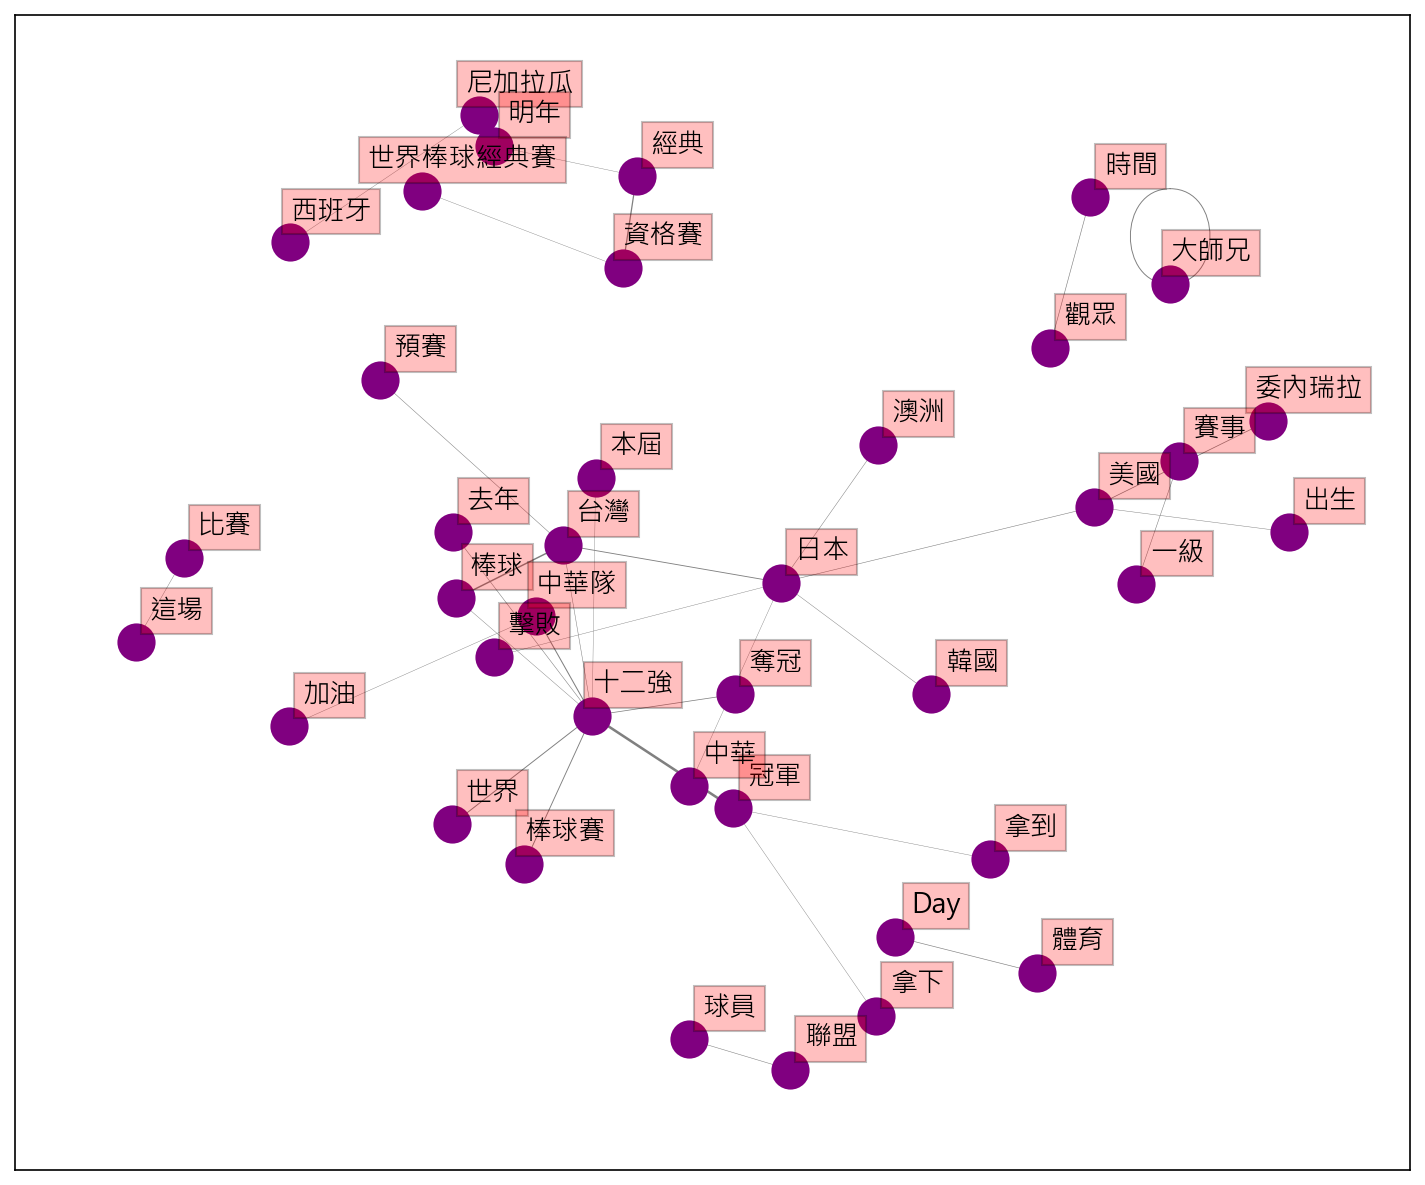

In [61]:
fig, ax = plt.subplots(figsize=(12, 10))

pos = nx.spring_layout(G, k=1.5)

# networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=weights,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0]+.07, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
    
plt.show()

- 觀眾、時間、體育(體育台)、Day 顯示討論於`轉播相關內容`。
- 明年、經典、資格賽 顯示文章內容於去年12強結束後，對於`隔年的WBCQ的討論與關注`，以及旁邊的西班牙、尼加拉瓜顯示 `對戰組合`。
- 十二強、中華隊、奪冠... 顯示十二強`賽事結果`。
- 美國、澳洲、日本、韓國... 顯示出十二強`對戰組合`
- 美國、出生 可能顯示各隊對於`球員徵招`可能性的討論。

#### 3.6 文字雲 (有時間再提及)

In [62]:
word_cloud = MetaData.copy()


# 斷詞、去除停用字並將word欄位展開
# 助教的
word_cloud['word'] = word_cloud.sentence.apply(getToken).explode('word')

# 修正的
word_cloud['word'] = word_cloud.sentence.apply(getToken)
word_cloud = word_cloud.explode('word')

word_cloud.head(3)

artUrl             artTitle  \
0  https://www.ptt.cc/bbs/Gossiping/M.1744211455....  [爆卦] 中華隊確定WBC 在日本出賽   
0  https://www.ptt.cc/bbs/Gossiping/M.1744211455....  [爆卦] 中華隊確定WBC 在日本出賽   
0  https://www.ptt.cc/bbs/Gossiping/M.1744211455....  [爆卦] 中華隊確定WBC 在日本出賽   

      artDate                                         artContent artCatagory  \
0  2025-04-09  機票要開始訂了嗎 雖然我不用買哈哈 歡迎大家繼續來日本玩 希望我們可以跟大谷好好的一決勝負 ...   gossiping   
0  2025-04-09  機票要開始訂了嗎 雖然我不用買哈哈 歡迎大家繼續來日本玩 希望我們可以跟大谷好好的一決勝負 ...   gossiping   
0  2025-04-09  機票要開始訂了嗎 雖然我不用買哈哈 歡迎大家繼續來日本玩 希望我們可以跟大谷好好的一決勝負 ...   gossiping   

   system_id                                           sentence word  
0          1  機票要開始訂了嗎雖然我不用買哈哈歡迎大家繼續來日本玩希望我們可以跟大谷好好的一決勝負GOGO中華隊   機票  
0          1  機票要開始訂了嗎雖然我不用買哈哈歡迎大家繼續來日本玩希望我們可以跟大谷好好的一決勝負GOGO中華隊   來日  
0          1  機票要開始訂了嗎雖然我不用買哈哈歡迎大家繼續來日本玩希望我們可以跟大谷好好的一決勝負GOGO中華隊   本玩

C:\Users\scblu\AppData\Local\Temp\ipykernel_18936\4217996110.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  freq_df= pd.DataFrame(pd.value_counts(word_cloud['word'])).sort_values(by = ['count'], ascending = False).reset_index()


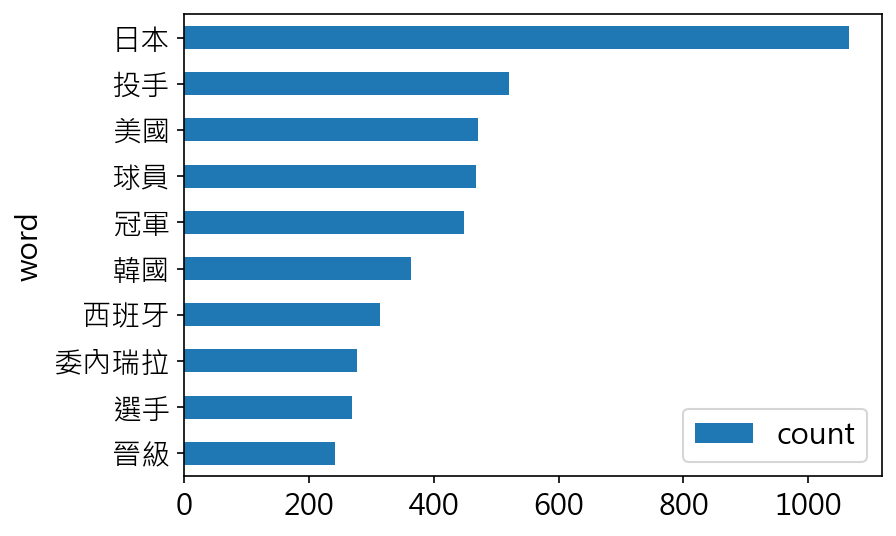

In [63]:
freq_df= pd.DataFrame(pd.value_counts(word_cloud['word'])).sort_values(by = ['count'], ascending = False).reset_index()

# 移除 搜尋的關鍵字
exclude_words = ['台灣', '台灣隊', '中華', '十二強', '棒球', '中華隊', 
                 '比賽', '真的', '聯盟', 'WBC','WBCQ', '經典', '資格賽']
filtered_df = freq_df[~freq_df['word'].isin(exclude_words)]

filtered_df.head(10).plot.barh(x = 'word', y = 'count').invert_yaxis()
plt.show()

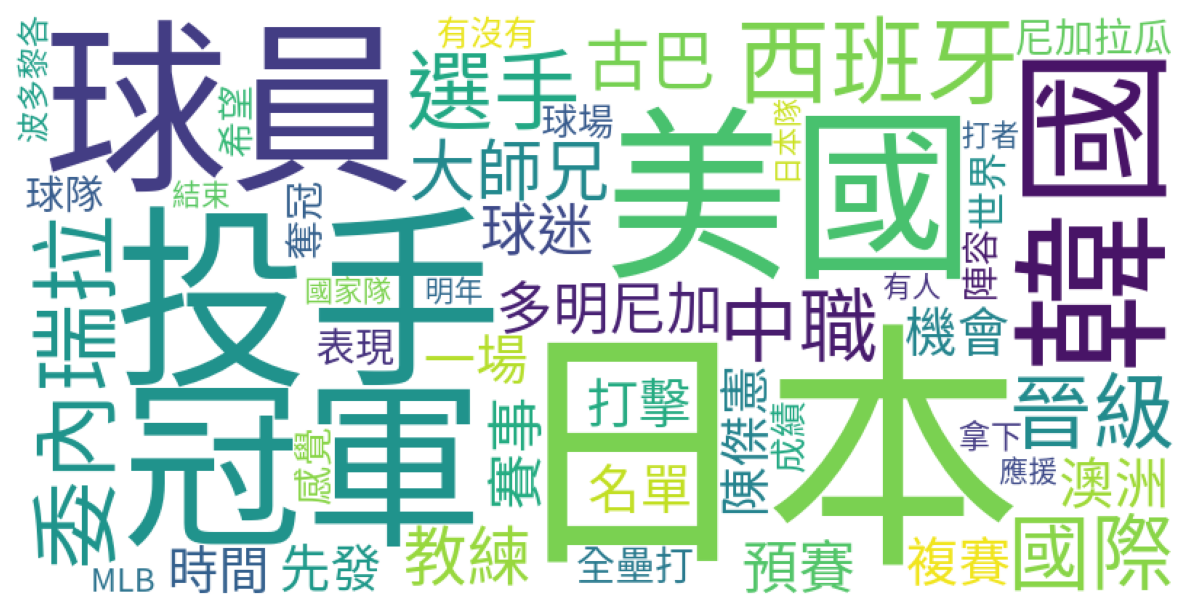

In [64]:
freq_dict = filtered_df.set_index('word').to_dict()
freq_dict = freq_dict['count']

# 繪製文字雲
wordcloud_nostop = WordCloud(background_color = 'white', width = 800, height = 400, font_path = FontPath, max_words = 50)
wordcloud_nostop.generate_from_frequencies(freq_dict)

plt.figure(figsize = (10,7))
plt.imshow(wordcloud_nostop)
plt.axis('off')
plt.show()

- 文章內容圍繞在 對戰國家、選手表現、先發名單、球迷應援、球員 等內容。

#### 4.1 計算兩個詞彙的相關性

改成使用空格連接斷好的詞

In [65]:
data_cor = MetaData.copy()

# 需要改成使用空格連接斷好的詞
data_cor['word'] = data_cor.sentence.apply(getToken).map(' '.join)
data_cor.head(3)

artUrl  \
0  https://www.ptt.cc/bbs/Gossiping/M.1744211455....   
1  https://www.ptt.cc/bbs/Gossiping/M.1742115979....   
2  https://www.ptt.cc/bbs/Gossiping/M.1741656774....   

                     artTitle     artDate  \
0         [爆卦] 中華隊確定WBC 在日本出賽  2025-04-09   
1  [問卦] 我就問 WBC和奧運要用中華台北還是台灣好  2025-03-16   
2      Re: [問卦] 2026wbc經典賽加油團  2025-03-11   

                                          artContent artCatagory  system_id  \
0  機票要開始訂了嗎 雖然我不用買哈哈 歡迎大家繼續來日本玩 希望我們可以跟大谷好好的一決勝負 ...   gossiping          1   
1  聽說美國大大要把中華台北改成台灣 那這樣子我們不就是堂堂的台灣國了 2026WBC就以台灣隊...   gossiping          2   
2         如果卡仔跟費仔都加入的話!!誰是隊長阿~~又有傑憲跟育成，好像很多可以 當隊長耶!!   gossiping          3   

                                            sentence  \
0  機票要開始訂了嗎雖然我不用買哈哈歡迎大家繼續來日本玩希望我們可以跟大谷好好的一決勝負GOGO中華隊   
1  聽說美國大大要把中華台北改成台灣那這樣子我們不就是堂堂的台灣國了WBC就以台灣隊就好了奧運中...   
2                 如果卡仔跟費仔都加入的話誰是隊長阿又有傑憲跟育成好像很多可以當隊長耶   

                                                word  
0                         機票 來日 本玩 希望 大谷 好好 一決勝負 中華隊  
1  聽說 美國 中華台北 改成 台灣 堂堂 台灣國 WBC 台灣隊 奧運 中華台北 改成 台灣隊...  
2                                  卡仔 費仔 隊長 傑憲 育成 隊長

篩選至少出現在5篇文章以上且詞頻前300的詞彙，轉成DTM

In [66]:
# Bag of Word
# 篩選至少出現在5篇文章以上且詞頻前300的詞彙
# min_df = 5 該字詞必須出現在5篇文章以上
vectorizer = CountVectorizer(min_df = 5, max_features = 200)
X = vectorizer.fit_transform(data_cor["word"])
vocabulary = vectorizer.get_feature_names_out()

# 轉成dataframe
DTM_df = pd.DataFrame(columns = vocabulary, data = X.toarray())
DTM_df

mlb  wbc  wbcq  一堆  一場  一壘  一級  三振  上壘  不好  ...  陳傑憲  陳子豪  陳晨威  陳柏清  隊伍  \
0       0    0     0   0   0   0   0   0   0   0  ...    0    0    0    0   0   
1       0    1     0   0   0   0   0   0   0   0  ...    0    0    0    0   0   
2       0    0     0   0   0   0   0   0   0   0  ...    0    0    0    0   0   
3       3    1     0   0   0   0   0   0   0   0  ...    0    0    0    0   0   
4       0    0     0   0   0   0   0   0   0   0  ...    0    0    0    0   0   
...   ...  ...   ...  ..  ..  ..  ..  ..  ..  ..  ...  ...  ...  ...  ...  ..   
1479    0    0     0   0   0   0   0   0   0   0  ...    0    0    0    0   0   
1480    0    0     0   0   5   0   2   0   0   0  ...    0    0    0    6   0   
1481    0    0     0   0   0   0   0   0   0   0  ...    0    0    0    0   0   
1482    0    0     0   0   0   0   0   0   0   0  ...    0    0    0    0   0   
1483    0    0     0   0   0   0   0   0   0   0  ...    0    0    0    0   0   

      面對  韓國  預賽  體育  龍貓  
0      0   0   0   0   0  
1      0   0   0   0   0  
2      0   0   0   0   0  
3      0   0   0   0   0  
4      0   0   0   0   0  
...   ..  ..  ..  ..  ..  
1479   0   0   0   0   0  
1480   1   2  12   0   0  
1481   0   0   0   0   0  
1482   0   0   0   0   0  
1483   0   0   0   0   0  

[1484 rows x 200 columns]

計算詞之間的相關係數

In [67]:
# 計算詞之間的相關係數
corr_matrix = np.corrcoef(DTM_df.T)

# 轉成dataframe
Cor_df = pd.DataFrame(corr_matrix, index = DTM_df.columns, columns = DTM_df.columns)

Cor_df.insert(0, 'word1', Cor_df.columns)
Cor_df.reset_index(inplace = True, drop = True)

Cor_df

word1       mlb       wbc      wbcq        一堆        一場        一壘  \
0     mlb  1.000000  0.284171  0.286190 -0.023669  0.048250  0.095593   
1     wbc  0.284171  1.000000  0.221585  0.012009  0.116575  0.171976   
2    wbcq  0.286190  0.221585  1.000000 -0.007236  0.014531  0.009830   
3      一堆 -0.023669  0.012009 -0.007236  1.000000  0.139414  0.032750   
4      一場  0.048250  0.116575  0.014531  0.139414  1.000000  0.161296   
..    ...       ...       ...       ...       ...       ...       ...   
195    面對  0.108476  0.279647  0.021550  0.017281  0.239964  0.451493   
196    韓國  0.166296  0.272100 -0.024474  0.032291  0.249936  0.130967   
197    預賽  0.008377  0.041395 -0.005908 -0.004915  0.140065  0.025968   
198    體育 -0.000523  0.015624 -0.008886 -0.005740 -0.002945  0.042172   
199    龍貓 -0.004266  0.038814  0.000276  0.109641  0.043625  0.089215   

           一級        三振        上壘  ...       陳傑憲       陳子豪       陳晨威  \
0    0.104153  0.064699  0.045376  ...  0.053365  0.002240  0.010247   
1    0.148927  0.125043  0.124221  ...  0.097602  0.043305 -0.005217   
2   -0.000185  0.008365  0.021585  ...  0.039632  0.004712  0.033620   
3    0.041705  0.011939 -0.008857  ...  0.026550  0.091481  0.087325   
4    0.235063  0.055426  0.085511  ...  0.114632  0.051562  0.079767   
..        ...       ...       ...  ...       ...       ...       ...   
195  0.191957  0.511436  0.632038  ...  0.403053 -0.002594  0.059641   
196  0.248782  0.107698  0.090603  ...  0.107786 -0.006247  0.150385   
197  0.119090  0.010156  0.011732  ... -0.000108 -0.002944  0.007047   
198  0.014337  0.010228  0.000654  ...  0.008576 -0.001466 -0.008272   
199  0.108356  0.037165 -0.005273  ...  0.089415  0.955784 -0.007950   

          陳柏清        隊伍        面對        韓國        預賽        體育        龍貓  
0    0.017473  0.088361  0.108476  0.166296  0.008377 -0.000523 -0.004266  
1   -0.025789  0.119769  0.279647  0.272100  0.041395  0.015624  0.038814  
2    0.036153  0.067886  0.021550 -0.024474 -0.005908 -0.008886  0.000276  
3    0.049442  0.066112  0.017281  0.032291 -0.004915 -0.005740  0.109641  
4    0.222745  0.266986  0.239964  0.249936  0.140065 -0.002945  0.043625  
..        ...       ...       ...       ...       ...       ...       ...  
195  0.058582  0.177444  1.000000  0.221324  0.069982  0.024170 -0.006514  
196  0.044416  0.225651  0.221324  1.000000  0.132613 -0.000753 -0.009301  
197  0.172413  0.032276  0.069982  0.132613  1.000000  0.010603 -0.007022  
198 -0.006495 -0.007291  0.024170 -0.000753  0.010603  1.000000 -0.003322  
199  0.026383 -0.005534 -0.006514 -0.009301 -0.007022 -0.003322  1.000000  

[200 rows x 201 columns]

In [68]:
print(list(Cor_df.columns))

['word1', 'mlb', 'wbc', 'wbcq', '一堆', '一場', '一壘', '一級', '三振', '上壘', '不好', '不錯', '世界', '中國', '中職', '中華', '中華台北', '中華隊', '二壘', '代表', '保送', '先發', '先發投手', '內容', '內野', '全壘打', '兩個', '兩場', '冠軍', '冠軍賽', '出局', '出生', '出賽', '分組', '剛剛', '加油', '勝利', '勝敗', '勝率', '十二強', '十二強賽', '南非', '南韓', '去年', '參加', '參賽', '古巴', '只能', '可惜', '台北大巨蛋', '台灣', '台灣隊', '名單', '商品', '啦啦隊', '四壞', '國家', '國家隊', '國際', '團隊', '墨西哥', '外野', '多明尼加', '大巨蛋', '大師兄', '大谷', '失分', '奧運', '奪冠', '如題', '委內瑞拉', '媒體', '守備', '實力', '對戰', '對手', '尼加拉瓜', '巴拿馬', '希望', '張奕', '張育成', '影片', '影響', '得分', '情況', '感動', '感覺', '應援', '成功', '成績', '戰績', '打出', '打擊', '打線', '打者', '打點', '投手', '投球', '拿下', '拿到', '捕手', '捷克', '授權', '提供', '擊出', '擊敗', '教練', '數據', '新聞', '旅外', '日本', '日本隊', '明天', '明年', '昨天', '時間', '晉級', '最強', '最終', '有人', '有沒有', '期待', '本屆', '東京', '東京巨蛋', '林家正', '林昱珉', '林立', '棒球', '棒球賽', '機會', '比賽', '決賽', '波多黎各', '淘汰', '澳洲', '牛棚', '特別', '狀況', '王博玄', '現場', '球員', '球場', '球衣', '球迷', '球隊', '發現', '直播', '真的', '第一', '第一場', '等級', '結束', '經典', '經驗', '美國', '美國隊', '聯盟', '職棒',

In [69]:
word_cor_df = Cor_df.melt(id_vars = 'word1', var_name = 'word2', value_name = 'cor')

# 去除兩個詞相同的情況
word_cor_df = word_cor_df[word_cor_df["word1"] != word_cor_df["word2"]]

word_cor_df.sort_values('cor', ascending=False).head(50)

word1 word2       cor
38399    龍貓   陳子豪  0.955784
39991   陳子豪    龍貓  0.955784
14168   記者會    媒體  0.929606
33670    媒體   記者會  0.929606
20637    勝率    擊出  0.862999
7503     擊出    勝率  0.862999
37437    勝率    關鍵  0.829914
7587     關鍵    勝率  0.829914
3503     擊出    二壘  0.806851
20617    二壘    擊出  0.806851
39103    擊出    面對  0.802255
20795    面對    擊出  0.802255
21237    勝率    數據  0.794024
7506     數據    勝率  0.794024
9063    大師兄    古巴  0.793806
12645    古巴   大師兄  0.793806
3437     勝率    二壘  0.791692
7417     二壘    勝率  0.791692
26560    荷蘭  波多黎各  0.791331
32132  波多黎各    荷蘭  0.791331
20679   張育成    擊出  0.782917
15903    擊出   張育成  0.782917
27591   陳子豪    狀況  0.781649
38337    狀況   陳子豪  0.781649
32351    結束    落後  0.780767
30361    落後    結束  0.780767
32059   墨西哥    荷蘭  0.778510
11960    荷蘭   墨西哥  0.778510
21303    擊出    數據  0.775530
20706    數據    擊出  0.775530
26459   墨西哥  波多黎各  0.759907
11932  波多黎各   墨西哥  0.759907
3487     成功    二壘  0.751212
17417    二壘    成功  0.751212
17408    上壘    成功  0.749892
1687     成功    上壘  0.749892
39937    狀況    龍貓  0.745283
27599    龍貓    狀況  0.745283
1617     二壘    上壘  0.743581
3408     上壘    二壘  0.743581
7487     成功    勝率  0.741339
17437    勝率    成功  0.741339
32808    上壘   西班牙  0.739110
1764    西班牙    上壘  0.739110
17503    擊出    成功  0.735057
20687    成功    擊出  0.735057
20619    保送    擊出  0.726070
3903     擊出    保送  0.726070
3595     面對    二壘  0.724356
39017    二壘    面對  0.724356

#### 4.2 查看「冠軍賽」、「陳傑憲」相關性最高的10個詞彙

In [70]:
word1_sum = word_cor_df[(word_cor_df["word1"] == "冠軍賽")].sort_values(by = ['cor'], ascending = False).head(10)
word2_sum = word_cor_df[(word_cor_df["word1"] == "陳傑憲")].sort_values(by = ['cor'], ascending = False).head(10)

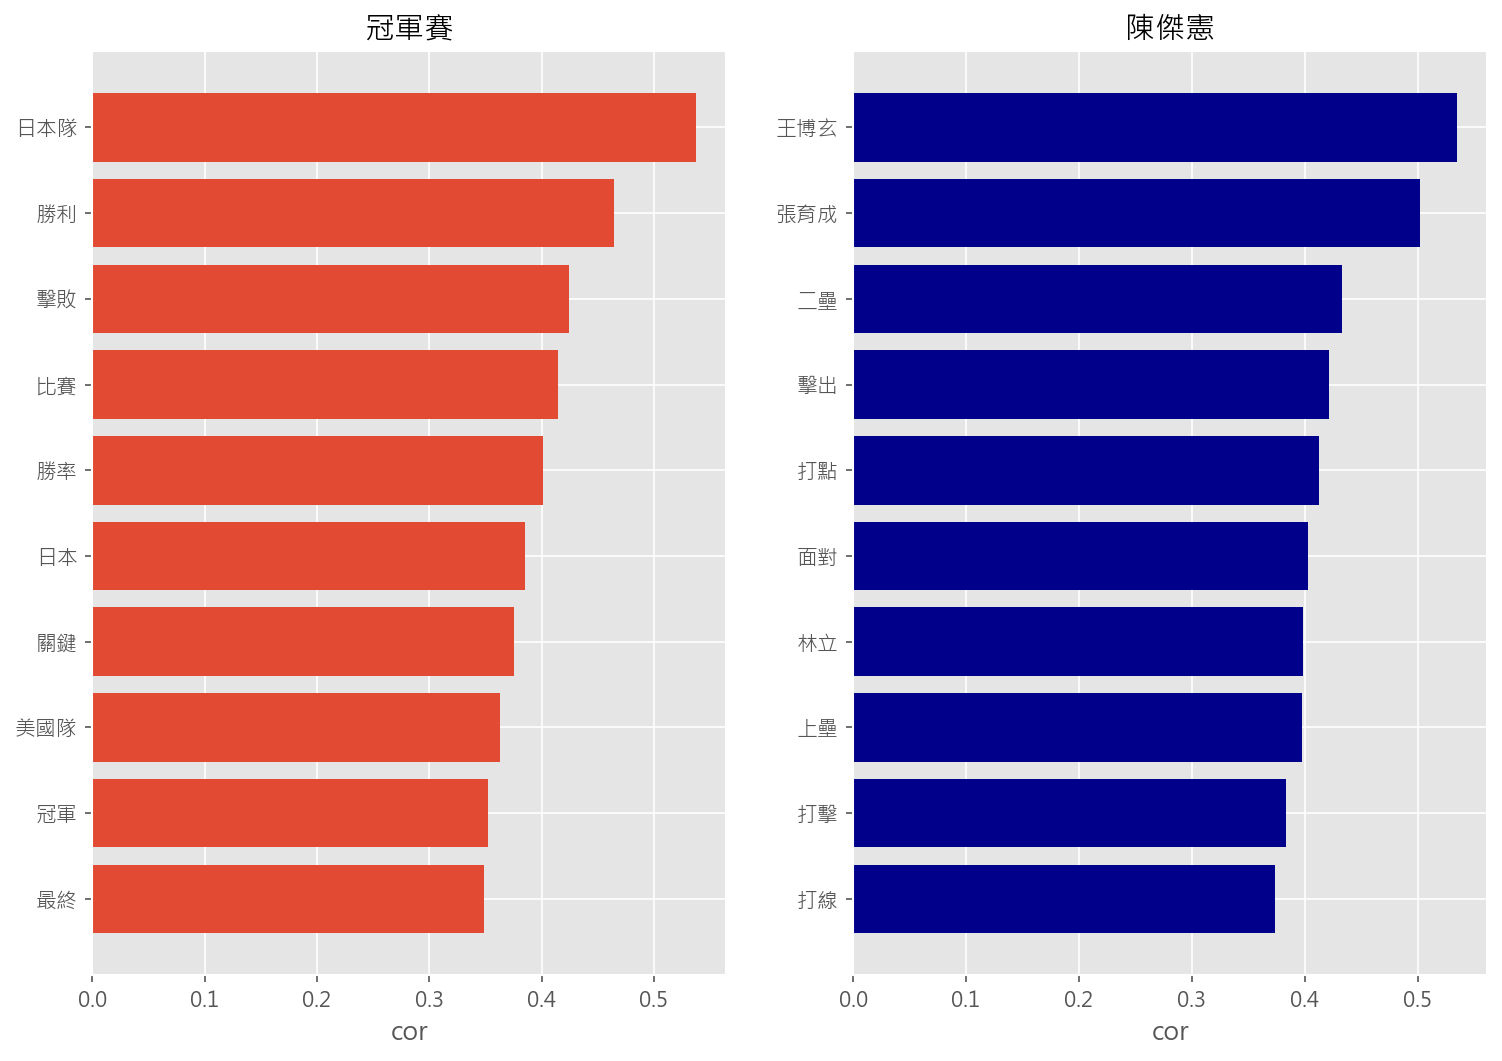

In [71]:
plt.figure(figsize=(12,8))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式

plt.subplot(121)
plt.title('冠軍賽')
plt.xlabel('cor')
plt.barh(word1_sum['word2'],word1_sum['cor'])
plt.gca().invert_yaxis()

plt.subplot(122)
plt.title('陳傑憲')
plt.xlabel('cor')
plt.barh(word2_sum['word2'],word2_sum['cor'],color="darkblue")
plt.gca().invert_yaxis()

plt.show()

- 冠軍賽: 出現與冠軍賽`比賽結果`的相關詞彙。(勝利、擊敗、日本、冠軍、最終)
- 陳傑憲: 出現與`選手表現`相關的詞彙(二壘、擊出、打點、上壘、打擊)。

#### 4.3 使用詞彙關係圖畫出以詞頻前50為節點且相關性高於0.4的組合

In [72]:
# 透過DTM找出詞頻前50高的詞彙
most_freq_df = DTM_df.sum().sort_values(ascending=False).head(50).reset_index().rename(columns={'index':'word', 0:'count'})

most_freq_word = most_freq_df['word'].tolist()

In [73]:
# 保留存在詞頻前50高之詞彙的組合
filtered_df = word_cor_df[(word_cor_df['word1'].isin(most_freq_word)) & (word_cor_df['word2'].isin(most_freq_word))]

# 篩選出相關係數大於0.3的組合
filtered_df = filtered_df[filtered_df['cor'] > 0.4]
filtered_df.reset_index(inplace=True, drop=True)
filtered_df

word1 word2       cor
0     投手    先發  0.463757
1     表現    先發  0.457958
2    大師兄   全壘打  0.440461
3     經典   全壘打  0.553908
4    大師兄    古巴  0.793806
..   ...   ...       ...
79    棒球    賽事  0.427911
80    比賽    賽事  0.434939
81    日本    韓國  0.419370
82    比賽    韓國  0.410485
83    台灣    預賽  0.499616

[84 rows x 3 columns]

In [74]:
# Create network plot 
g = nx.Graph()

# 建立 nodes 間的連結
for i in range(len(filtered_df)):
    g.add_edge(filtered_df["word1"][i], filtered_df["word2"][i], weight=filtered_df["cor"][i])
    
# 取得edge權重
weights = [w[2]['weight']*5 for w in  g.edges(data=True)]

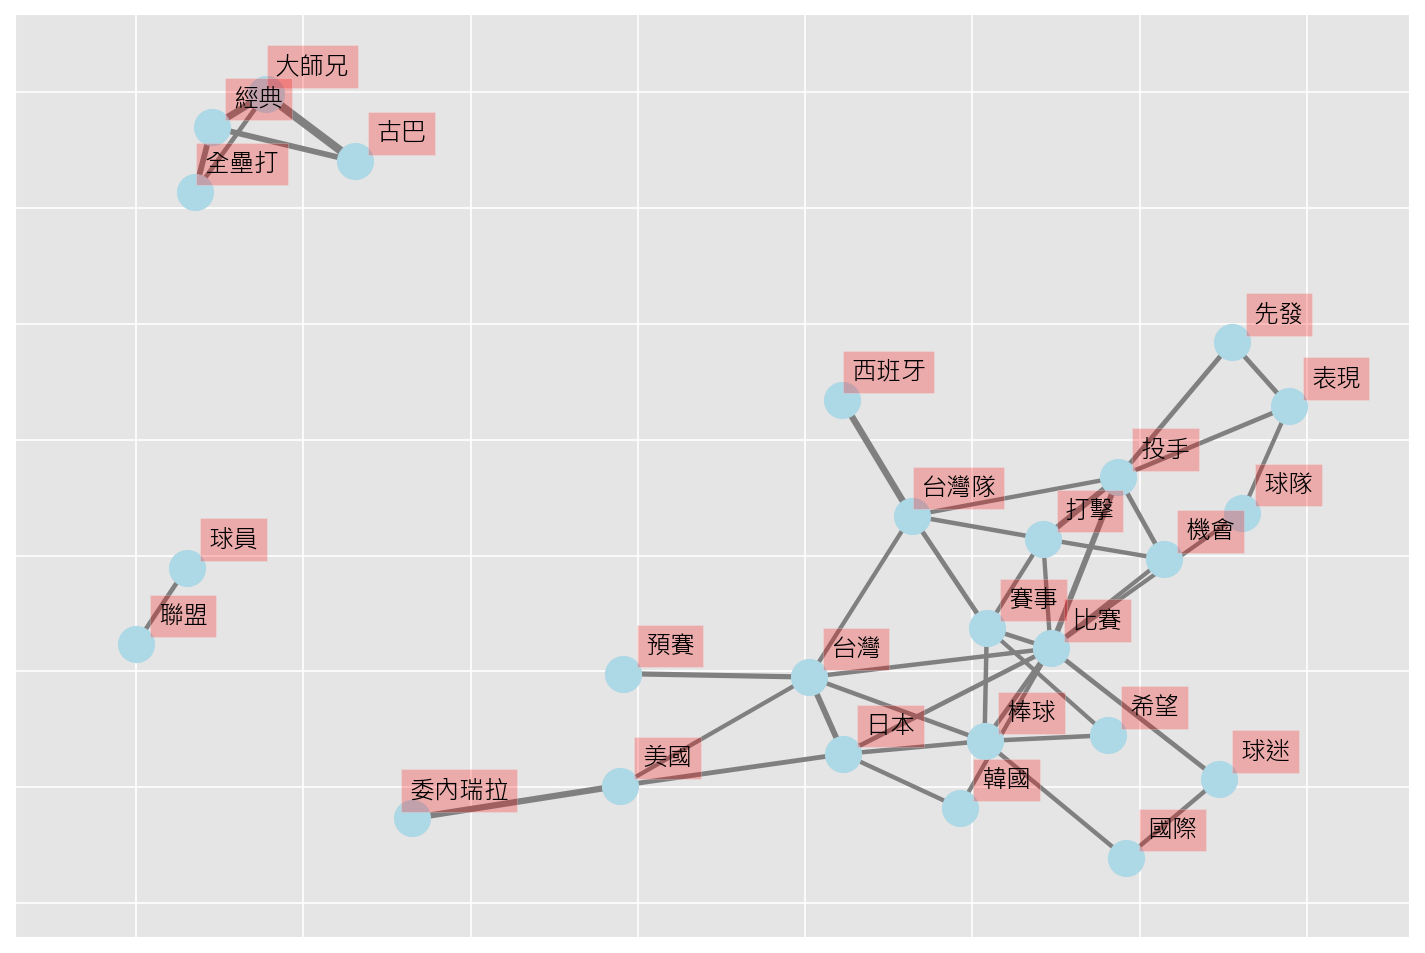

In [75]:
fig, ax = plt.subplots(figsize=(12, 8))

pos = nx.spring_layout(g, k=0.3)

# networks
nx.draw_networkx(g, pos,
                 font_size=16,
                 width=weights,
                 edge_color='grey',
                 node_color='lightblue',
                 with_labels = False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0]+.07, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=12)
    
plt.show()

- 右下角: <br>
主要包含比賽內容、選手表現等。 因為比賽對戰的關係，可以看到不同隊伍與比賽相連，同時可以看到對於球員的表現像是打擊等有相當的關注。
- 左上角: <br>
額外討論到對於林智勝於過去國際賽事的表現。

#### 5.1 計算文章相似度

In [76]:
data_cos = data_cor.copy()
data_cos.head(3)

artUrl  \
0  https://www.ptt.cc/bbs/Gossiping/M.1744211455....   
1  https://www.ptt.cc/bbs/Gossiping/M.1742115979....   
2  https://www.ptt.cc/bbs/Gossiping/M.1741656774....   

                     artTitle     artDate  \
0         [爆卦] 中華隊確定WBC 在日本出賽  2025-04-09   
1  [問卦] 我就問 WBC和奧運要用中華台北還是台灣好  2025-03-16   
2      Re: [問卦] 2026wbc經典賽加油團  2025-03-11   

                                          artContent artCatagory  system_id  \
0  機票要開始訂了嗎 雖然我不用買哈哈 歡迎大家繼續來日本玩 希望我們可以跟大谷好好的一決勝負 ...   gossiping          1   
1  聽說美國大大要把中華台北改成台灣 那這樣子我們不就是堂堂的台灣國了 2026WBC就以台灣隊...   gossiping          2   
2         如果卡仔跟費仔都加入的話!!誰是隊長阿~~又有傑憲跟育成，好像很多可以 當隊長耶!!   gossiping          3   

                                            sentence  \
0  機票要開始訂了嗎雖然我不用買哈哈歡迎大家繼續來日本玩希望我們可以跟大谷好好的一決勝負GOGO中華隊   
1  聽說美國大大要把中華台北改成台灣那這樣子我們不就是堂堂的台灣國了WBC就以台灣隊就好了奧運中...   
2                 如果卡仔跟費仔都加入的話誰是隊長阿又有傑憲跟育成好像很多可以當隊長耶   

                                                word  
0                         機票 來日 本玩 希望 大谷 好好 一決勝負 中華隊  
1  聽說 美國 中華台北 改成 台灣 堂堂 台灣國 WBC 台灣隊 奧運 中華台北 改成 台灣隊...  
2                                  卡仔 費仔 隊長 傑憲 育成 隊長

In [77]:
transformer = TfidfTransformer()  
print(transformer) 
# 將詞頻矩陣X統計成TF-IDF值
tfidf = transformer.fit_transform(X)  

# 轉成dataframe
TFIDF_df = pd.DataFrame(columns = vocabulary, data = tfidf.toarray())
TFIDF_df

TfidfTransformer()


mlb       wbc  wbcq   一堆        一場   一壘        一級   三振   上壘   不好  \
0     0.000000  0.000000   0.0  0.0  0.000000  0.0  0.000000  0.0  0.0  0.0   
1     0.000000  0.154121   0.0  0.0  0.000000  0.0  0.000000  0.0  0.0  0.0   
2     0.000000  0.000000   0.0  0.0  0.000000  0.0  0.000000  0.0  0.0  0.0   
3     0.862625  0.195398   0.0  0.0  0.000000  0.0  0.000000  0.0  0.0  0.0   
4     0.000000  0.000000   0.0  0.0  0.000000  0.0  0.000000  0.0  0.0  0.0   
...        ...       ...   ...  ...       ...  ...       ...  ...  ...  ...   
1479  0.000000  0.000000   0.0  0.0  0.000000  0.0  0.000000  0.0  0.0  0.0   
1480  0.000000  0.000000   0.0  0.0  0.139341  0.0  0.069572  0.0  0.0  0.0   
1481  0.000000  0.000000   0.0  0.0  0.000000  0.0  0.000000  0.0  0.0  0.0   
1482  0.000000  0.000000   0.0  0.0  0.000000  0.0  0.000000  0.0  0.0  0.0   
1483  0.000000  0.000000   0.0  0.0  0.000000  0.0  0.000000  0.0  0.0  0.0   

      ...  陳傑憲  陳子豪  陳晨威       陳柏清   隊伍       面對        韓國        預賽   體育   龍貓  
0     ...  0.0  0.0  0.0  0.000000  0.0  0.00000  0.000000  0.000000  0.0  0.0  
1     ...  0.0  0.0  0.0  0.000000  0.0  0.00000  0.000000  0.000000  0.0  0.0  
2     ...  0.0  0.0  0.0  0.000000  0.0  0.00000  0.000000  0.000000  0.0  0.0  
3     ...  0.0  0.0  0.0  0.000000  0.0  0.00000  0.000000  0.000000  0.0  0.0  
4     ...  0.0  0.0  0.0  0.000000  0.0  0.00000  0.000000  0.000000  0.0  0.0  
...   ...  ...  ...  ...       ...  ...      ...       ...       ...  ...  ...  
1479  ...  0.0  0.0  0.0  0.000000  0.0  0.00000  0.000000  0.000000  0.0  0.0  
1480  ...  0.0  0.0  0.0  0.227126  0.0  0.03607  0.048359  0.337811  0.0  0.0  
1481  ...  0.0  0.0  0.0  0.000000  0.0  0.00000  0.000000  0.000000  0.0  0.0  
1482  ...  0.0  0.0  0.0  0.000000  0.0  0.00000  0.000000  0.000000  0.0  0.0  
1483  ...  0.0  0.0  0.0  0.000000  0.0  0.00000  0.000000  0.000000  0.0  0.0  

[1484 rows x 200 columns]

計算文章之間的 cosine similarity

In [78]:
# 計算文章之間的 cosine similarity
cosine_matrix = cosine_similarity(tfidf.toarray(), tfidf.toarray())

In [79]:
# 檢視與第1047篇文章相似的文章
cos_df = pd.DataFrame(cosine_matrix[1047], columns = ['cos_similarity'])
cos_df

cos_similarity
0           0.701747
1           0.109069
2           0.000000
3           0.000000
4           0.147254
...              ...
1479        0.000000
1480        0.023324
1481        0.047289
1482        0.023157
1483        0.174167

[1484 rows x 1 columns]

In [80]:
cos_df = cos_df.merge(data_cos, how = 'left', left_index=True, right_index=True)

In [81]:
cos_df.loc[:,["cos_similarity", "system_id", "artTitle", "artUrl"]].sort_values(by=['cos_similarity'], ascending=False).head(10)

cos_similarity  system_id                    artTitle  \
1047        1.000000       1048      [分享] 大谷IG 轉發台灣12強奪冠限動！   
568         0.762101        569  [問卦] 如何吸引大谷翔平來台  50轟? 12強?   
93          0.731732         94     [問卦] 大谷翔平有辦法在WBC為日本復仇嗎？   
1114        0.709672       1115      [討論] WBC賽制的日本 台灣有可能贏嗎?   
0           0.701747          1         [爆卦] 中華隊確定WBC 在日本出賽   
566         0.693062        567            [問卦] 大谷會來台看12強嗎?   
1371        0.669434       1372   [分享] 大谷翔平 12強對韓國13局21K無失分   
317         0.600737        318       [問卦] WBC對到大谷的話有機會拿下嗎？   
381         0.599835        382            [問卦] 大谷怎麼不打12強了？   
687         0.568907        688     Re: [討論] 明年大谷要如何對付12強冠軍   

                                                 artUrl  
1047  https://www.ptt.cc/bbs/Baseball/M.1732472384.A...  
568   https://www.ptt.cc/bbs/Gossiping/M.1730771816....  
93    https://www.ptt.cc/bbs/Gossiping/M.1740319726....  
1114  https://www.ptt.cc/bbs/Baseball/M.1732454709.A...  
0     https://www.ptt.cc/bbs/Gossiping/M.1744211455....  
566   https://www.ptt.cc/bbs/Gossiping/M.1731201103....  
1371  https://www.ptt.cc/bbs/Baseball/M.1731670660.A...  
317   https://www.ptt.cc/bbs/Gossiping/M.1732508884....  
381   https://www.ptt.cc/bbs/Gossiping/M.1732448281....  
687   https://www.ptt.cc/bbs/Baseball/M.1740494502.A...

- 第1047篇文章是與大谷相關的文章，因此找到的也會是與大谷相關的。

#### 6.1 n-gram 預測模型 (額外實作)

In [82]:
data3 = MetaData.copy()
sen_tokens = data3.sentence.apply(getToken).tolist()

In [83]:
def ngram(documents, N=2):
    ngram_prediction = dict()
    total_grams = list()
    words = list()
    Word = namedtuple('Word', ['word', 'prob'])

    for doc in documents:
        # 加上開頭和結尾 tag
        split_words = ['<s>'] + list(doc) + ['</s>']
        # 計算分子
        [total_grams.append(tuple(split_words[i:i+N])) for i in range(len(split_words)-N+1)]
        # 計算分母
        [words.append(tuple(split_words[i:i+N-1])) for i in range(len(split_words)-N+2)]
        
    total_word_counter = Counter(total_grams)
    word_counter = Counter(words)
    
    for key in total_word_counter:
        word = ''.join(key[:N-1])
        if word not in ngram_prediction:
            ngram_prediction.update({word: set()})
            
        next_word_prob = total_word_counter[key]/word_counter[key[:N-1]] #P(B|A)
        w = Word(key[-1], '{:.3g}'.format(next_word_prob))
        ngram_prediction[word].add(w)
        
    return ngram_prediction

In [84]:
# Bigram預測模型為例
bi_prediction = ngram(sen_tokens, N=2)

In [85]:
text = '中華隊'
next_words = list(bi_prediction[text])
next_words.sort(key = lambda s: s[1], reverse = True)
for next_word in next_words[:5]:
    print('next word: {}, probability: {}'.format(next_word.word, next_word.prob))

next word: 加油, probability: 0.0336
next word: 十二強, probability: 0.0285
next word: 晉級, probability: 0.0218
next word: 奪冠, probability: 0.0218
next word: 投手, probability: 0.0201


In [90]:
text = '日本'
next_words = list(bi_prediction[text])
next_words.sort(key = lambda s: s[1], reverse = True)
for next_word in next_words[:5]:
    print('next word: {}, probability: {}'.format(next_word.word, next_word.prob))

next word: 台灣, probability: 0.0404
next word: 美國, probability: 0.0263
next word: 韓國, probability: 0.0254
next word: 冠軍, probability: 0.0169
next word: 委內瑞拉, probability: 0.0169


## 113-2 社群媒體分析 第二次讀書會 - 2

### 情緒文件分類

- 組別 : 第一組 
- 作者 : 莊尹安 
- 日期 : 2025/04/17


主要是將文件集先進行情緒分析，並結合文件分類訓練出一個情緒分類器

#### 載入套件

In [ ]:
# import package
import os
import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import re
import jieba
import jieba.analyse
import math
from nltk import ngrams, FreqDist
from collections import Counter, namedtuple
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict, KFold
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    precision_recall_curve,
    RocCurveDisplay
)

from wordcloud import WordCloud

import networkx as nx
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

from pprint import pprint

FontPath = 'SourceHanSansTW-Regular.otf'
# fprop = fm.FontProperties(fname="SourceHanSansTW-Regular.otf")

#### 字型格式設定

In [ ]:
# 設定圖的中文字體 (無法顯示的話可以試試‘Microsoft JhengHei’字體)
# 也可參考：https://pyecontech.com/2020/03/27/python_matplotlib_chinese/
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] #使圖中中文能正常顯示
plt.rcParams['axes.unicode_minus'] = False #使負號能夠顯示

#### 資料集介紹

- 時間: 2024/11/01 ~ 2025/04/16
- 來源: PTT 八卦板、棒球板
- 關鍵字: "12強" , "經典賽" , "WBC"
- 筆數: 1484 ( 清理後 )

<!-- * 以下為教學目標：
    1. 如何將以數字向量代表一篇文章？
        * `CountVectorizer`
        * `TfidfVectorizer`
    2. 基本的分類模型流程，包含以下三步驟：
        * 前處理 (preprocess)
        * 建模 (train model)
        * 評估與預測 (evaluation and predict)
    3. Cross Validation說明
    4. 不同分類器的效果
    5. 可解釋的可視化模型結果
    6. 預測其他家新聞文章的版別 -->

In [ ]:
df = pd.read_csv("./raw_data/ptt_data.csv")
df = df[df["artDate"] != "未知"]
df = df[df["artContent"] != " "]
df["artDate"] = pd.to_datetime(df["artDate"])
df['artDate'] = df['artDate'].dt.date 
df.head()

artUrl  \
0  https://www.ptt.cc/bbs/Gossiping/M.1744211455....   
1  https://www.ptt.cc/bbs/Gossiping/M.1742115979....   
2  https://www.ptt.cc/bbs/Gossiping/M.1741656774....   
3  https://www.ptt.cc/bbs/Gossiping/M.1741416718....   
4  https://www.ptt.cc/bbs/Gossiping/M.1741404698....   

                     artTitle     artDate  \
0         [爆卦] 中華隊確定WBC 在日本出賽  2025-04-09   
1  [問卦] 我就問 WBC和奧運要用中華台北還是台灣好  2025-03-16   
2      Re: [問卦] 2026wbc經典賽加油團  2025-03-11   
3       [問卦] 費仔加入台灣隊打WBC有幫助嗎？  2025-03-08   
4    [問卦] 若經典賽成功徵召大聯盟台裔球員是不是該  2025-03-08   

                                          artContent artCatagory  system_id  
0  機票要開始訂了嗎 雖然我不用買哈哈 歡迎大家繼續來日本玩 希望我們可以跟大谷好好的一決勝負 ...   gossiping          1  
1  聽說美國大大要把中華台北改成台灣 那這樣子我們不就是堂堂的台灣國了 2026WBC就以台灣隊...   gossiping          2  
2         如果卡仔跟費仔都加入的話!!誰是隊長阿~~又有傑憲跟育成，好像很多可以 當隊長耶!!   gossiping          3  
3  費仔在過去幾年在MLB表現似乎不是很好 有幾次被讓渡 2024 MLB打擊率只有0.224 ...   gossiping          4  
4  大家平常都一直在酸台女ㄈㄈ尺 但碰到經典賽要找大聯盟球員就開始瘋狂狂找有台灣血統的球員。 這...   gossiping          5

#### 0.0 資料清理

In [ ]:
clear_df = df.copy()

#去除本次不會用到的欄位
drop_cols = ['system_id']
clear_df.drop(drop_cols, axis = 1, inplace = True)

#去除文章內容為空值的筆數
clear_df.dropna(subset = ['artContent'], axis=0, how='any', inplace=True)

#新增['sentence']欄位，用'。'取代'\n\n'，並移除'\n'
clear_df['sentence'] = clear_df['artContent'].str.replace(r'\n\n','。', regex=True)
clear_df['sentence'] = clear_df['sentence'].str.replace(r'\n','', regex=True)

#移除內文中的網址
clear_df['sentence'] = clear_df['sentence'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)

clear_df.head()

artUrl  \
0  https://www.ptt.cc/bbs/Gossiping/M.1744211455....   
1  https://www.ptt.cc/bbs/Gossiping/M.1742115979....   
2  https://www.ptt.cc/bbs/Gossiping/M.1741656774....   
3  https://www.ptt.cc/bbs/Gossiping/M.1741416718....   
4  https://www.ptt.cc/bbs/Gossiping/M.1741404698....   

                     artTitle     artDate  \
0         [爆卦] 中華隊確定WBC 在日本出賽  2025-04-09   
1  [問卦] 我就問 WBC和奧運要用中華台北還是台灣好  2025-03-16   
2      Re: [問卦] 2026wbc經典賽加油團  2025-03-11   
3       [問卦] 費仔加入台灣隊打WBC有幫助嗎？  2025-03-08   
4    [問卦] 若經典賽成功徵召大聯盟台裔球員是不是該  2025-03-08   

                                          artContent artCatagory  \
0  機票要開始訂了嗎 雖然我不用買哈哈 歡迎大家繼續來日本玩 希望我們可以跟大谷好好的一決勝負 ...   gossiping   
1  聽說美國大大要把中華台北改成台灣 那這樣子我們不就是堂堂的台灣國了 2026WBC就以台灣隊...   gossiping   
2         如果卡仔跟費仔都加入的話!!誰是隊長阿~~又有傑憲跟育成，好像很多可以 當隊長耶!!   gossiping   
3  費仔在過去幾年在MLB表現似乎不是很好 有幾次被讓渡 2024 MLB打擊率只有0.224 ...   gossiping   
4  大家平常都一直在酸台女ㄈㄈ尺 但碰到經典賽要找大聯盟球員就開始瘋狂狂找有台灣血統的球員。 這...   gossiping   

                                            sentence  
0  機票要開始訂了嗎 雖然我不用買哈哈 歡迎大家繼續來日本玩 希望我們可以跟大谷好好的一決勝負 ...  
1  聽說美國大大要把中華台北改成台灣 那這樣子我們不就是堂堂的台灣國了 2026WBC就以台灣隊...  
2         如果卡仔跟費仔都加入的話!!誰是隊長阿~~又有傑憲跟育成，好像很多可以 當隊長耶!!  
3  費仔在過去幾年在MLB表現似乎不是很好 有幾次被讓渡 2024 MLB打擊率只有0.224 ...  
4  大家平常都一直在酸台女ㄈㄈ尺 但碰到經典賽要找大聯盟球員就開始瘋狂狂找有台灣血統的球員。 這...

#### 0.1 斷句


In [ ]:
# 先移除空白或 NaN 的欄位
clear_df = clear_df.dropna(subset=['sentence'])
clear_df = clear_df[clear_df['sentence'].str.strip() != '']

# 再做斷句
clear_df['sentence'] = clear_df['sentence'].str.split(r"[,，。！!？?]+")

# 展開為每句一列
sent_df = clear_df.explode('sentence').reset_index(drop=True)

# 去除斷句後的空字串（有時可能會分出空句）
sent_df = sent_df[sent_df['sentence'].str.strip() != '']

sent_df.head()


artUrl  \
0  https://www.ptt.cc/bbs/Gossiping/M.1744211455....   
2  https://www.ptt.cc/bbs/Gossiping/M.1742115979....   
3  https://www.ptt.cc/bbs/Gossiping/M.1741656774....   
4  https://www.ptt.cc/bbs/Gossiping/M.1741656774....   
5  https://www.ptt.cc/bbs/Gossiping/M.1741656774....   

                     artTitle     artDate  \
0         [爆卦] 中華隊確定WBC 在日本出賽  2025-04-09   
2  [問卦] 我就問 WBC和奧運要用中華台北還是台灣好  2025-03-16   
3      Re: [問卦] 2026wbc經典賽加油團  2025-03-11   
4      Re: [問卦] 2026wbc經典賽加油團  2025-03-11   
5      Re: [問卦] 2026wbc經典賽加油團  2025-03-11   

                                          artContent artCatagory  \
0  機票要開始訂了嗎 雖然我不用買哈哈 歡迎大家繼續來日本玩 希望我們可以跟大谷好好的一決勝負 ...   gossiping   
2  聽說美國大大要把中華台北改成台灣 那這樣子我們不就是堂堂的台灣國了 2026WBC就以台灣隊...   gossiping   
3         如果卡仔跟費仔都加入的話!!誰是隊長阿~~又有傑憲跟育成，好像很多可以 當隊長耶!!   gossiping   
4         如果卡仔跟費仔都加入的話!!誰是隊長阿~~又有傑憲跟育成，好像很多可以 當隊長耶!!   gossiping   
5         如果卡仔跟費仔都加入的話!!誰是隊長阿~~又有傑憲跟育成，好像很多可以 當隊長耶!!   gossiping   

                                            sentence  
0  機票要開始訂了嗎 雖然我不用買哈哈 歡迎大家繼續來日本玩 希望我們可以跟大谷好好的一決勝負 ...  
2  聽說美國大大要把中華台北改成台灣 那這樣子我們不就是堂堂的台灣國了 2026WBC就以台灣隊...  
3                                       如果卡仔跟費仔都加入的話  
4                                     誰是隊長阿~~又有傑憲跟育成  
5                                        好像很多可以 當隊長耶

#### 0.2 斷詞

In [ ]:
# 初始化斷詞引擎：不一定要設定，只使用內建效果也可以
# 參考網址：https://raw.githubusercontent.com/ldkrsi/jieba-zh_TW/master/jieba/dict.txt

jieba.set_dictionary('dict/dict.txt')
jieba.load_userdict('dict/stop_words.txt')

Building prefix dict from c:\Users\1218a\OneDrive\桌面\第二次讀書會\第二次讀書會\dict\dict.txt ...
Loading model from cache C:\Users\1218a\AppData\Local\Temp\jieba.ubde78828939c4a07f071973e7a5ac405.cache
Loading model cost 0.680 seconds.
Prefix dict has been built successfully.


In [ ]:
#去除句子中除了字母、數字、空白字符以外的符號
sent_df['sentence'] = sent_df['sentence'].str.replace(r'[^\w\s]+', '', regex=True).astype(str)

# 把長度小於1的sentence刪掉
sent_df = sent_df[sent_df["sentence"].str.len() > 1]

sent_df.head()

artUrl  \
0  https://www.ptt.cc/bbs/Gossiping/M.1744211455....   
2  https://www.ptt.cc/bbs/Gossiping/M.1742115979....   
3  https://www.ptt.cc/bbs/Gossiping/M.1741656774....   
4  https://www.ptt.cc/bbs/Gossiping/M.1741656774....   
5  https://www.ptt.cc/bbs/Gossiping/M.1741656774....   

                     artTitle     artDate  \
0         [爆卦] 中華隊確定WBC 在日本出賽  2025-04-09   
2  [問卦] 我就問 WBC和奧運要用中華台北還是台灣好  2025-03-16   
3      Re: [問卦] 2026wbc經典賽加油團  2025-03-11   
4      Re: [問卦] 2026wbc經典賽加油團  2025-03-11   
5      Re: [問卦] 2026wbc經典賽加油團  2025-03-11   

                                          artContent artCatagory  \
0  機票要開始訂了嗎 雖然我不用買哈哈 歡迎大家繼續來日本玩 希望我們可以跟大谷好好的一決勝負 ...   gossiping   
2  聽說美國大大要把中華台北改成台灣 那這樣子我們不就是堂堂的台灣國了 2026WBC就以台灣隊...   gossiping   
3         如果卡仔跟費仔都加入的話!!誰是隊長阿~~又有傑憲跟育成，好像很多可以 當隊長耶!!   gossiping   
4         如果卡仔跟費仔都加入的話!!誰是隊長阿~~又有傑憲跟育成，好像很多可以 當隊長耶!!   gossiping   
5         如果卡仔跟費仔都加入的話!!誰是隊長阿~~又有傑憲跟育成，好像很多可以 當隊長耶!!   gossiping   

                                            sentence  
0  機票要開始訂了嗎 雖然我不用買哈哈 歡迎大家繼續來日本玩 希望我們可以跟大谷好好的一決勝負 ...  
2  聽說美國大大要把中華台北改成台灣 那這樣子我們不就是堂堂的台灣國了 2026WBC就以台灣隊...  
3                                       如果卡仔跟費仔都加入的話  
4                                       誰是隊長阿又有傑憲跟育成  
5                                        好像很多可以 當隊長耶

In [ ]:
word_df = sent_df.assign(word = sent_df['sentence'].apply(jieba.lcut)).explode('word').drop(['sentence'], axis=1)

#去除少於兩個字的詞語
word_df = word_df.loc[word_df['word'].str.len() > 1]

word_df.head()

artUrl             artTitle  \
0  https://www.ptt.cc/bbs/Gossiping/M.1744211455....  [爆卦] 中華隊確定WBC 在日本出賽   
0  https://www.ptt.cc/bbs/Gossiping/M.1744211455....  [爆卦] 中華隊確定WBC 在日本出賽   
0  https://www.ptt.cc/bbs/Gossiping/M.1744211455....  [爆卦] 中華隊確定WBC 在日本出賽   
0  https://www.ptt.cc/bbs/Gossiping/M.1744211455....  [爆卦] 中華隊確定WBC 在日本出賽   
0  https://www.ptt.cc/bbs/Gossiping/M.1744211455....  [爆卦] 中華隊確定WBC 在日本出賽   

      artDate                                         artContent artCatagory  \
0  2025-04-09  機票要開始訂了嗎 雖然我不用買哈哈 歡迎大家繼續來日本玩 希望我們可以跟大谷好好的一決勝負 ...   gossiping   
0  2025-04-09  機票要開始訂了嗎 雖然我不用買哈哈 歡迎大家繼續來日本玩 希望我們可以跟大谷好好的一決勝負 ...   gossiping   
0  2025-04-09  機票要開始訂了嗎 雖然我不用買哈哈 歡迎大家繼續來日本玩 希望我們可以跟大谷好好的一決勝負 ...   gossiping   
0  2025-04-09  機票要開始訂了嗎 雖然我不用買哈哈 歡迎大家繼續來日本玩 希望我們可以跟大谷好好的一決勝負 ...   gossiping   
0  2025-04-09  機票要開始訂了嗎 雖然我不用買哈哈 歡迎大家繼續來日本玩 希望我們可以跟大谷好好的一決勝負 ...   gossiping   

  word  
0   機票  
0   開始  
0   雖然  
0   不用  
0   哈哈

In [ ]:
# 以檔案形式匯入通用的停用字檔案
# 將stopwords存成list
stopwords = [line.strip() for line in open('dict/stop_words.txt', 'r', encoding='utf-8').readlines()] 
# stopwords.extend(stopwords_manual)

In [ ]:
noStop_df = word_df[~word_df['word'].isin(stopwords)]
noStop_df.head()

artUrl             artTitle  \
0  https://www.ptt.cc/bbs/Gossiping/M.1744211455....  [爆卦] 中華隊確定WBC 在日本出賽   
0  https://www.ptt.cc/bbs/Gossiping/M.1744211455....  [爆卦] 中華隊確定WBC 在日本出賽   
0  https://www.ptt.cc/bbs/Gossiping/M.1744211455....  [爆卦] 中華隊確定WBC 在日本出賽   
0  https://www.ptt.cc/bbs/Gossiping/M.1744211455....  [爆卦] 中華隊確定WBC 在日本出賽   
0  https://www.ptt.cc/bbs/Gossiping/M.1744211455....  [爆卦] 中華隊確定WBC 在日本出賽   

      artDate                                         artContent artCatagory  \
0  2025-04-09  機票要開始訂了嗎 雖然我不用買哈哈 歡迎大家繼續來日本玩 希望我們可以跟大谷好好的一決勝負 ...   gossiping   
0  2025-04-09  機票要開始訂了嗎 雖然我不用買哈哈 歡迎大家繼續來日本玩 希望我們可以跟大谷好好的一決勝負 ...   gossiping   
0  2025-04-09  機票要開始訂了嗎 雖然我不用買哈哈 歡迎大家繼續來日本玩 希望我們可以跟大谷好好的一決勝負 ...   gossiping   
0  2025-04-09  機票要開始訂了嗎 雖然我不用買哈哈 歡迎大家繼續來日本玩 希望我們可以跟大谷好好的一決勝負 ...   gossiping   
0  2025-04-09  機票要開始訂了嗎 雖然我不用買哈哈 歡迎大家繼續來日本玩 希望我們可以跟大谷好好的一決勝負 ...   gossiping   

  word  
0   機票  
0   不用  
0   歡迎  
0   繼續  
0   日本

#### 1.0 Lexicon-based 情緒分析

#### 1.1 讀取 LIWC 情緒字典

In [ ]:
# 讀取情緒字典
liwc_dict = pd.read_csv("./dict/liwc/LIWC_CH.csv")
liwc_dict = liwc_dict.rename(columns={'name': 'word', "class": 'sentiments'})
liwc_dict.head()

word sentiments
0   ):     affect
1   3q     affect
2   :(     affect
3   :)     affect
4   <3     affect

In [ ]:
liwc_dict['sentiments'].describe()

count       4682
unique         6
top       affect
freq        2061
Name: sentiments, dtype: object

#### 1.2 標出sentiments

In [ ]:
ptt_liwc_df = pd.merge(noStop_df[["artUrl", "artDate", "artTitle", "artContent", "word"]], liwc_dict, how="left")
ptt_liwc_df.head()

artUrl     artDate  \
0  https://www.ptt.cc/bbs/Gossiping/M.1744211455....  2025-04-09   
1  https://www.ptt.cc/bbs/Gossiping/M.1744211455....  2025-04-09   
2  https://www.ptt.cc/bbs/Gossiping/M.1744211455....  2025-04-09   
3  https://www.ptt.cc/bbs/Gossiping/M.1744211455....  2025-04-09   
4  https://www.ptt.cc/bbs/Gossiping/M.1744211455....  2025-04-09   

              artTitle                                         artContent  \
0  [爆卦] 中華隊確定WBC 在日本出賽  機票要開始訂了嗎 雖然我不用買哈哈 歡迎大家繼續來日本玩 希望我們可以跟大谷好好的一決勝負 ...   
1  [爆卦] 中華隊確定WBC 在日本出賽  機票要開始訂了嗎 雖然我不用買哈哈 歡迎大家繼續來日本玩 希望我們可以跟大谷好好的一決勝負 ...   
2  [爆卦] 中華隊確定WBC 在日本出賽  機票要開始訂了嗎 雖然我不用買哈哈 歡迎大家繼續來日本玩 希望我們可以跟大谷好好的一決勝負 ...   
3  [爆卦] 中華隊確定WBC 在日本出賽  機票要開始訂了嗎 雖然我不用買哈哈 歡迎大家繼續來日本玩 希望我們可以跟大谷好好的一決勝負 ...   
4  [爆卦] 中華隊確定WBC 在日本出賽  機票要開始訂了嗎 雖然我不用買哈哈 歡迎大家繼續來日本玩 希望我們可以跟大谷好好的一決勝負 ...   

  word sentiments  
0   機票        NaN  
1   不用        NaN  
2   歡迎     affect  
3   歡迎   positive  
4   繼續        NaN

In [ ]:
word_count = ptt_liwc_df.groupby(["word", "sentiments"]).size().reset_index()
word_count = word_count.rename(columns={0: "size"})
word_count = word_count.sort_values(["size"], ascending=False)

word_count.head(10)

word sentiments  size
160   冠軍   positive   412
159   冠軍     affect   412
599   打擊     affect   153
602   打擊        sad   153
600   打擊        anx   153
601   打擊   negative   153
267   問題     affect   132
268   問題   negative   132
447   希望     affect   130
448   希望   positive   130

In [ ]:
word_of_pos = word_count.loc[(word_count["sentiments"] == "positive")]
word_of_pos.head(15)

word sentiments  size
160    冠軍   positive   412
448    希望   positive   130
1303   重要   positive    94
1035   確定   positive    87
193    勝利   positive    77
50     不錯   positive    69
589    成功   positive    68
788    樂天   positive    63
1008   相信   positive    63
825    決定   positive    51
757    最好   positive    50
957    獎金   positive    47
565    感謝   positive    44
1218   謝謝   positive    44
772    朋友   positive    42

In [ ]:
word_of_neg = word_count.loc[(word_count["sentiments"] == "negative")]
word_of_neg.head(15)

word sentiments  size
601    打擊   negative   153
268    問題   negative   132
692    擊敗   negative    82
154    八卦   negative    71
335    壓力   negative    52
220    受傷   negative    48
605    打敗   negative    38
1288   違規   negative    32
1040   禁止   negative    29
309    嚴重   negative    29
305    嚴格   negative    25
714    攻擊   negative    23
711    攻勢   negative    22
365    失敗   negative    22
371    失誤   negative    21

#### 1.3 移除錯誤情緒字，重新計算情緒

In [ ]:
# 設定要移除的字詞列表
words_to_remove = ['樂天','打擊','攻擊','打敗', '瘋狂']
# 使用 ~ 運算子和 isin() 方法過濾掉包含在 words_to_remove 列表中的行
liwc_dict_revise = liwc_dict[~liwc_dict['word'].isin(words_to_remove)]
# 使用更新後的情緒字典 merge
ptt_liwc_df = pd.merge(noStop_df[["artUrl", "artDate", "artTitle", "artContent","word"]], liwc_dict_revise, how="left")
ptt_liwc_df.head()

artUrl     artDate  \
0  https://www.ptt.cc/bbs/Gossiping/M.1744211455....  2025-04-09   
1  https://www.ptt.cc/bbs/Gossiping/M.1744211455....  2025-04-09   
2  https://www.ptt.cc/bbs/Gossiping/M.1744211455....  2025-04-09   
3  https://www.ptt.cc/bbs/Gossiping/M.1744211455....  2025-04-09   
4  https://www.ptt.cc/bbs/Gossiping/M.1744211455....  2025-04-09   

              artTitle                                         artContent  \
0  [爆卦] 中華隊確定WBC 在日本出賽  機票要開始訂了嗎 雖然我不用買哈哈 歡迎大家繼續來日本玩 希望我們可以跟大谷好好的一決勝負 ...   
1  [爆卦] 中華隊確定WBC 在日本出賽  機票要開始訂了嗎 雖然我不用買哈哈 歡迎大家繼續來日本玩 希望我們可以跟大谷好好的一決勝負 ...   
2  [爆卦] 中華隊確定WBC 在日本出賽  機票要開始訂了嗎 雖然我不用買哈哈 歡迎大家繼續來日本玩 希望我們可以跟大谷好好的一決勝負 ...   
3  [爆卦] 中華隊確定WBC 在日本出賽  機票要開始訂了嗎 雖然我不用買哈哈 歡迎大家繼續來日本玩 希望我們可以跟大谷好好的一決勝負 ...   
4  [爆卦] 中華隊確定WBC 在日本出賽  機票要開始訂了嗎 雖然我不用買哈哈 歡迎大家繼續來日本玩 希望我們可以跟大谷好好的一決勝負 ...   

  word sentiments  
0   機票        NaN  
1   不用        NaN  
2   歡迎     affect  
3   歡迎   positive  
4   繼續        NaN

#### 1.4 計算sentiment-value
sentiment-value = positive - negative

In [ ]:
sentiment_count = pd.DataFrame(
    ptt_liwc_df.groupby(["artDate", "sentiments"]).size()
).reset_index()

mask = (sentiment_count['sentiments'] == "positive") | (sentiment_count['sentiments'] == "negative") 
sentiment_count = sentiment_count.loc[mask]

sentiment_count = sentiment_count.rename(columns={0: "size"})
sentiment_count = sentiment_count.sort_values(["artDate"])
sentiment_count = sentiment_count.assign(
    ratio=sentiment_count.groupby("artDate")["size"].transform(lambda n: n / n.sum())
)

#正負向情緒分數
ptt_sentiment_value = (
    sentiment_count.pivot_table(
        index="artDate", columns="sentiments", values="size", fill_value=0
    )
    .reset_index()
    .rename_axis(None, axis=1)
)

# 計算sentiment
ptt_sentiment_value["sentiment_value"] = (
    ptt_sentiment_value["positive"]
    - ptt_sentiment_value["negative"]
)
ptt_sentiment_value.head()

artDate  negative  positive  sentiment_value
0  2024-11-03       2.0       1.0             -1.0
1  2024-11-04       5.0      26.0             21.0
2  2024-11-05       4.0      10.0              6.0
3  2024-11-06       5.0       8.0              3.0
4  2024-11-07       2.0      12.0             10.0

#### 1.5  文章情緒分析

In [ ]:
sentiment_count_by_article = pd.DataFrame(
    ptt_liwc_df.groupby(["artUrl", "sentiments"]).size()
).reset_index()
sentiment_count_by_article = sentiment_count_by_article.rename(columns={0: "size"})
sentiment_count_by_article.head(10)

artUrl sentiments  size
0  https://www.ptt.cc/bbs/Baseball/M.1730626833.A...     affect     1
1  https://www.ptt.cc/bbs/Baseball/M.1730626833.A...   negative     1
2  https://www.ptt.cc/bbs/Baseball/M.1730685518.A...     affect     6
3  https://www.ptt.cc/bbs/Baseball/M.1730685518.A...   negative     1
4  https://www.ptt.cc/bbs/Baseball/M.1730685518.A...   positive     5
5  https://www.ptt.cc/bbs/Baseball/M.1730715828.A...     affect    23
6  https://www.ptt.cc/bbs/Baseball/M.1730715828.A...        anx     1
7  https://www.ptt.cc/bbs/Baseball/M.1730715828.A...   negative     3
8  https://www.ptt.cc/bbs/Baseball/M.1730715828.A...   positive    20
9  https://www.ptt.cc/bbs/Baseball/M.1730771775.A...     affect     2

In [ ]:
ptt_sentiment_value_by_article = (
    sentiment_count_by_article.pivot_table(
        index="artUrl", columns="sentiments", values="size", fill_value=0
    )
    .reset_index()
    .rename_axis(None, axis=1)
)
ptt_sentiment_value_by_article.head()

artUrl  affect  anger  anx  \
0  https://www.ptt.cc/bbs/Baseball/M.1730626833.A...     1.0    0.0  0.0   
1  https://www.ptt.cc/bbs/Baseball/M.1730685518.A...     6.0    0.0  0.0   
2  https://www.ptt.cc/bbs/Baseball/M.1730715828.A...    23.0    0.0  1.0   
3  https://www.ptt.cc/bbs/Baseball/M.1730771775.A...     2.0    0.0  0.0   
4  https://www.ptt.cc/bbs/Baseball/M.1730806235.A...     4.0    0.0  0.0   

   negative  positive  sad  
0       1.0       0.0  0.0  
1       1.0       5.0  0.0  
2       3.0      20.0  0.0  
3       0.0       2.0  0.0  
4       0.0       4.0  0.0

#### 1.6 計算每個文章的 sentiment value

In [ ]:
# sentiment 計算方式: positive - negative
ptt_sentiment_value_by_article["sentiment_value"] = (
    ptt_sentiment_value_by_article["positive"]
    - ptt_sentiment_value_by_article["negative"]
)
ptt_sentiment_value_by_article.head()

artUrl  affect  anger  anx  \
0  https://www.ptt.cc/bbs/Baseball/M.1730626833.A...     1.0    0.0  0.0   
1  https://www.ptt.cc/bbs/Baseball/M.1730685518.A...     6.0    0.0  0.0   
2  https://www.ptt.cc/bbs/Baseball/M.1730715828.A...    23.0    0.0  1.0   
3  https://www.ptt.cc/bbs/Baseball/M.1730771775.A...     2.0    0.0  0.0   
4  https://www.ptt.cc/bbs/Baseball/M.1730806235.A...     4.0    0.0  0.0   

   negative  positive  sad  sentiment_value  
0       1.0       0.0  0.0             -1.0  
1       1.0       5.0  0.0              4.0  
2       3.0      20.0  0.0             17.0  
3       0.0       2.0  0.0              2.0  
4       0.0       4.0  0.0              4.0

#### 1.7 劃分文章的 sentiment_class

In [ ]:
ptt_sentiment_value_by_article['sentiment_class'] = ptt_sentiment_value_by_article['sentiment_value'].apply(lambda x: "正向" if x > 0 else "負向" )
ptt_sentiment_value_by_article.head(10)

artUrl  affect  anger  anx  \
0  https://www.ptt.cc/bbs/Baseball/M.1730626833.A...     1.0    0.0  0.0   
1  https://www.ptt.cc/bbs/Baseball/M.1730685518.A...     6.0    0.0  0.0   
2  https://www.ptt.cc/bbs/Baseball/M.1730715828.A...    23.0    0.0  1.0   
3  https://www.ptt.cc/bbs/Baseball/M.1730771775.A...     2.0    0.0  0.0   
4  https://www.ptt.cc/bbs/Baseball/M.1730806235.A...     4.0    0.0  0.0   
5  https://www.ptt.cc/bbs/Baseball/M.1730810658.A...     2.0    0.0  1.0   
6  https://www.ptt.cc/bbs/Baseball/M.1730886219.A...     6.0    0.0  0.0   
7  https://www.ptt.cc/bbs/Baseball/M.1730888052.A...     2.0    0.0  0.0   
8  https://www.ptt.cc/bbs/Baseball/M.1730904354.A...     1.0    0.0  0.0   
9  https://www.ptt.cc/bbs/Baseball/M.1730905976.A...     2.0    0.0  0.0   

   negative  positive  sad  sentiment_value sentiment_class  
0       1.0       0.0  0.0             -1.0              負向  
1       1.0       5.0  0.0              4.0              正向  
2       3.0      20.0  0.0             17.0              正向  
3       0.0       2.0  0.0              2.0              正向  
4       0.0       4.0  0.0              4.0              正向  
5       1.0       1.0  0.0              0.0              負向  
6       3.0       3.0  0.0              0.0              負向  
7       0.0       2.0  0.0              2.0              正向  
8       0.0       1.0  0.0              1.0              正向  
9       0.0       2.0  0.0              2.0              正向

#### 1.8 情緒分析結果儲存

In [ ]:
# 合併文章情緒結果回原始文章表（用 artUrl 對應）
final_df = pd.merge(
    df,
    ptt_sentiment_value_by_article[['artUrl', 'sentiment_class']],
    on='artUrl',
    how='left'
)

# 選擇要輸出的欄位
final_output = final_df[['artUrl', 'artTitle', 'artDate', 'artContent', 'artCatagory', 'sentiment_class']]
final_output


artUrl  \
0     https://www.ptt.cc/bbs/Gossiping/M.1744211455....   
1     https://www.ptt.cc/bbs/Gossiping/M.1742115979....   
2     https://www.ptt.cc/bbs/Gossiping/M.1741656774....   
3     https://www.ptt.cc/bbs/Gossiping/M.1741416718....   
4     https://www.ptt.cc/bbs/Gossiping/M.1741404698....   
...                                                 ...   
1464  https://www.ptt.cc/bbs/Baseball/M.1730729683.A...   
1465  https://www.ptt.cc/bbs/Baseball/M.1730715828.A...   
1466  https://www.ptt.cc/bbs/Baseball/M.1730685518.A...   
1467  https://www.ptt.cc/bbs/Baseball/M.1730631537.A...   
1468  https://www.ptt.cc/bbs/Baseball/M.1730626833.A...   

                           artTitle     artDate  \
0               [爆卦] 中華隊確定WBC 在日本出賽  2025-04-09   
1        [問卦] 我就問 WBC和奧運要用中華台北還是台灣好  2025-03-16   
2            Re: [問卦] 2026wbc經典賽加油團  2025-03-11   
3             [問卦] 費仔加入台灣隊打WBC有幫助嗎？  2025-03-08   
4          [問卦] 若經典賽成功徵召大聯盟台裔球員是不是該  2025-03-08   
...                             ...         ...   
1464     [整理] 2024年第3屆世界12強棒球錦標賽轉播表  2024-11-04   
1465              [討論] 世界12強賽先發投手安排  2024-11-04   
1466  Re: [問題] 請問大家12強周邊棒球衣都拿什麼尺寸呢?  2024-11-04   
1467            [討論] 多明尼加12強名單出來了嗎？  2024-11-03   
1468        [討論] 今年12強維持上屆第五，可以接受嗎？  2024-11-03   

                                             artContent artCatagory  \
0     機票要開始訂了嗎 雖然我不用買哈哈 歡迎大家繼續來日本玩 希望我們可以跟大谷好好的一決勝負 ...   gossiping   
1     聽說美國大大要把中華台北改成台灣 那這樣子我們不就是堂堂的台灣國了 2026WBC就以台灣隊...   gossiping   
2            如果卡仔跟費仔都加入的話!!誰是隊長阿~~又有傑憲跟育成，好像很多可以 當隊長耶!!   gossiping   
3     費仔在過去幾年在MLB表現似乎不是很好 有幾次被讓渡 2024 MLB打擊率只有0.224 ...   gossiping   
4     大家平常都一直在酸台女ㄈㄈ尺 但碰到經典賽要找大聯盟球員就開始瘋狂狂找有台灣血統的球員。 這...   gossiping   
...                                                 ...         ...   
1464  日期 時間 對戰組合 愛爾達體育家族 緯來電視網 東森電視家族 ══════════════...    baseball   
1465  距離12強賽預賽B組開打已經不到10天 從剛打完的捷克交流賽也可稍微觀察出選手的近況 這邊討...    baseball   
1466  10月預購的12強CT AMAZE 背號球衣， 當初預購的時候是說電繡臂章， 結果收到的時候...    baseball   
1467  如題，12強剩不到一個禮拜就要開打了，多 明尼加的名單是不是到現在都還沒出來？除 了之前公布...    baseball   
1468  這兩天看了交流賽，感覺台灣12強要拿前三可能有點困難 上一屆台灣只拿了第五名，以世界排名第三...    baseball   

     sentiment_class  
0                 正向  
1                NaN  
2                NaN  
3                 正向  
4                 正向  
...              ...  
1464             NaN  
1465              正向  
1466              正向  
1467             NaN  
1468              負向  

[1469 rows x 6 columns]

In [ ]:
final_output = final_output.dropna(subset=['sentiment_class'])
final_output

artUrl  \
0     https://www.ptt.cc/bbs/Gossiping/M.1744211455....   
3     https://www.ptt.cc/bbs/Gossiping/M.1741416718....   
4     https://www.ptt.cc/bbs/Gossiping/M.1741404698....   
5     https://www.ptt.cc/bbs/Gossiping/M.1741120622....   
6     https://www.ptt.cc/bbs/Gossiping/M.1741060213....   
...                                                 ...   
1462  https://www.ptt.cc/bbs/Baseball/M.1730806235.A...   
1463  https://www.ptt.cc/bbs/Baseball/M.1730771775.A...   
1465  https://www.ptt.cc/bbs/Baseball/M.1730715828.A...   
1466  https://www.ptt.cc/bbs/Baseball/M.1730685518.A...   
1468  https://www.ptt.cc/bbs/Baseball/M.1730626833.A...   

                           artTitle     artDate  \
0               [爆卦] 中華隊確定WBC 在日本出賽  2025-04-09   
3             [問卦] 費仔加入台灣隊打WBC有幫助嗎？  2025-03-08   
4          [問卦] 若經典賽成功徵召大聯盟台裔球員是不是該  2025-03-08   
5               [爆卦] 中國在棒球經典賽資格賽被淘汰  2025-03-05   
6         [問卦] WBC快訊，中國1：8輸哥倫比亞吞二連敗  2025-03-04   
...                             ...         ...   
1462              [分享] 吃漢堡王抽12強台日門票  2024-11-05   
1463              [分享] 多明尼加12強非正式名單  2024-11-05   
1465              [討論] 世界12強賽先發投手安排  2024-11-04   
1466  Re: [問題] 請問大家12強周邊棒球衣都拿什麼尺寸呢?  2024-11-04   
1468        [討論] 今年12強維持上屆第五，可以接受嗎？  2024-11-03   

                                             artContent artCatagory  \
0     機票要開始訂了嗎 雖然我不用買哈哈 歡迎大家繼續來日本玩 希望我們可以跟大谷好好的一決勝負 ...   gossiping   
3     費仔在過去幾年在MLB表現似乎不是很好 有幾次被讓渡 2024 MLB打擊率只有0.224 ...   gossiping   
4     大家平常都一直在酸台女ㄈㄈ尺 但碰到經典賽要找大聯盟球員就開始瘋狂狂找有台灣血統的球員。 這...   gossiping   
5     剛剛中國對巴西2:12中國七局被扣倒 在第一場對德國2:12七局被扣倒 第二場1:8輸給哥倫...   gossiping   
6     https://i.imgur.com/eOE68s0.jpeg 如題，稍早在美國亞利桑那進...   gossiping   
...                                                 ...         ...   
1462  https://i.imgur.com/hCw22GR.jpeg 先感謝一下厲害的同事幫我搶...    baseball   
1463  https://shorturl.at/KbwfR 這份名單目前只有26人，不是正式名單 先...    baseball   
1465  距離12強賽預賽B組開打已經不到10天 從剛打完的捷克交流賽也可稍微觀察出選手的近況 這邊討...    baseball   
1466  10月預購的12強CT AMAZE 背號球衣， 當初預購的時候是說電繡臂章， 結果收到的時候...    baseball   
1468  這兩天看了交流賽，感覺台灣12強要拿前三可能有點困難 上一屆台灣只拿了第五名，以世界排名第三...    baseball   

     sentiment_class  
0                 正向  
3                 正向  
4                 正向  
5                 負向  
6                 負向  
...              ...  
1462              正向  
1463              正向  
1465              正向  
1466              正向  
1468              負向  

[1081 rows x 6 columns]

In [ ]:
# 儲存為 CSV
final_output.to_csv("raw_data/ptt_baseball_sentiment.csv", index=False, encoding='utf-8-sig')
print("✅ 已儲存完整檔案：ptt_baseball_sentiment.csv")

✅ 已儲存完整檔案：ptt_baseball_sentiment.csv


#### 2.0 情緒文件分類

In [ ]:
baseball = pd.read_csv("raw_data/ptt_baseball_sentiment.csv") # 匯資料
baseball.head(3)

artUrl  \
0  https://www.ptt.cc/bbs/Gossiping/M.1744211455....   
1  https://www.ptt.cc/bbs/Gossiping/M.1741416718....   
2  https://www.ptt.cc/bbs/Gossiping/M.1741404698....   

                   artTitle     artDate  \
0       [爆卦] 中華隊確定WBC 在日本出賽  2025-04-09   
1     [問卦] 費仔加入台灣隊打WBC有幫助嗎？  2025-03-08   
2  [問卦] 若經典賽成功徵召大聯盟台裔球員是不是該  2025-03-08   

                                          artContent artCatagory  \
0  機票要開始訂了嗎 雖然我不用買哈哈 歡迎大家繼續來日本玩 希望我們可以跟大谷好好的一決勝負 ...   gossiping   
1  費仔在過去幾年在MLB表現似乎不是很好 有幾次被讓渡 2024 MLB打擊率只有0.224 ...   gossiping   
2  大家平常都一直在酸台女ㄈㄈ尺 但碰到經典賽要找大聯盟球員就開始瘋狂狂找有台灣血統的球員。 這...   gossiping   

  sentiment_class  
0              正向  
1              正向  
2              正向

In [ ]:
# 看看有幾篇文章
print(f"number of posts: {baseball.shape[0]}")
print(f"date range: {(baseball['artDate'].min(), baseball['artDate'].max())}")
print(f"category: \n{baseball['sentiment_class'].value_counts()}")

number of posts: 1081
date range: ('2024-11-03', '2025-04-15')
category: 
sentiment_class
正向    710
負向    371
Name: count, dtype: int64


#### 2.1 資料清理

In [ ]:
# 過濾 nan 的資料
baseball = baseball.dropna(subset=['artTitle'])
baseball = baseball.dropna(subset=['artContent'])
# 移除網址格式
baseball["artContent"] = baseball.artContent.apply(
    lambda x: re.sub("(http|https)://.*", "", x)
)
baseball["artTitle"] = baseball["artTitle"].apply(
    lambda x: re.sub("(http|https)://.*", "", x)
)
# 只留下中文字
baseball["artContent"] = baseball.artContent.apply(
    lambda x: re.sub("[^\u4e00-\u9fa5]+", "", x)
)
baseball["artTitle"] = baseball["artTitle"].apply(
    lambda x: re.sub("[^\u4e00-\u9fa5]+", "", x)
)
baseball.head(3)

artUrl               artTitle  \
0  https://www.ptt.cc/bbs/Gossiping/M.1744211455....           爆卦中華隊確定在日本出賽   
1  https://www.ptt.cc/bbs/Gossiping/M.1741416718....         問卦費仔加入台灣隊打有幫助嗎   
2  https://www.ptt.cc/bbs/Gossiping/M.1741404698....  問卦若經典賽成功徵召大聯盟台裔球員是不是該   

      artDate                                         artContent artCatagory  \
0  2025-04-09      機票要開始訂了嗎雖然我不用買哈哈歡迎大家繼續來日本玩希望我們可以跟大谷好好的一決勝負中華隊   gossiping   
1  2025-03-08   費仔在過去幾年在表現似乎不是很好有幾次被讓渡打擊率只有好像在站不太穩這樣對明年加入台灣隊有幫助嗎   gossiping   
2  2025-03-08  大家平常都一直在酸台女尺但碰到經典賽要找大聯盟球員就開始瘋狂狂找有台灣血統的球員這時候是不是...   gossiping   

  sentiment_class  
0              正向  
1              正向  
2              正向

In [ ]:
# 文章標題`artTitle`和內文`sentence`合併成新的`content`欄位
baseball["content"] = baseball["artTitle"] + baseball["artContent"]
baseball = baseball[["content", "artUrl", "sentiment_class"]]  # 文章內容 文章連結
baseball.head()

content  \
0  爆卦中華隊確定在日本出賽機票要開始訂了嗎雖然我不用買哈哈歡迎大家繼續來日本玩希望我們可以跟大...   
1  問卦費仔加入台灣隊打有幫助嗎費仔在過去幾年在表現似乎不是很好有幾次被讓渡打擊率只有好像在站不...   
2  問卦若經典賽成功徵召大聯盟台裔球員是不是該大家平常都一直在酸台女尺但碰到經典賽要找大聯盟球員...   
3  爆卦中國在棒球經典賽資格賽被淘汰剛剛中國對巴西中國七局被扣倒在第一場對德國七局被扣倒第二場輸...   
4                                    問卦快訊中國輸哥倫比亞吞二連敗   

                                              artUrl sentiment_class  
0  https://www.ptt.cc/bbs/Gossiping/M.1744211455....              正向  
1  https://www.ptt.cc/bbs/Gossiping/M.1741416718....              正向  
2  https://www.ptt.cc/bbs/Gossiping/M.1741404698....              正向  
3  https://www.ptt.cc/bbs/Gossiping/M.1741120622....              負向  
4  https://www.ptt.cc/bbs/Gossiping/M.1741060213....              負向

In [ ]:
# 看看有幾篇文章
print(f"total docs: {baseball.shape[0]}")


total docs: 1081


#### 2.2 斷詞

In [ ]:
# 設定繁體中文詞庫
jieba.set_dictionary("./dict/dict.txt.big")

# 新增stopwords
# jieba.analyse.set_stop_words('./dict/stop_words.txt') #jieba.analyse.extract_tags才會作用
with open("./dict/stop_words.txt", encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

In [ ]:
# 設定斷詞 function
def getToken(row):
    seg_list = jieba.cut(row, cut_all=False)
    seg_list = [
        w for w in seg_list if w not in stopWords and len(w) > 1
    ]  # 篩選掉停用字與字元數大於1的詞彙
    return seg_list

In [ ]:
baseball["words"] = baseball["content"].apply(getToken).map(" ".join)
baseball.head()

Building prefix dict from c:\Users\1218a\OneDrive\桌面\第二次讀書會\第二次讀書會\dict\dict.txt.big ...
Loading model from cache C:\Users\1218a\AppData\Local\Temp\jieba.ufc5510657cb6d093887c67f316037f7b.cache
Loading model cost 1.449 seconds.
Prefix dict has been built successfully.


content  \
0  爆卦中華隊確定在日本出賽機票要開始訂了嗎雖然我不用買哈哈歡迎大家繼續來日本玩希望我們可以跟大...   
1  問卦費仔加入台灣隊打有幫助嗎費仔在過去幾年在表現似乎不是很好有幾次被讓渡打擊率只有好像在站不...   
2  問卦若經典賽成功徵召大聯盟台裔球員是不是該大家平常都一直在酸台女尺但碰到經典賽要找大聯盟球員...   
3  爆卦中國在棒球經典賽資格賽被淘汰剛剛中國對巴西中國七局被扣倒在第一場對德國七局被扣倒第二場輸...   
4                                    問卦快訊中國輸哥倫比亞吞二連敗   

                                              artUrl sentiment_class  \
0  https://www.ptt.cc/bbs/Gossiping/M.1744211455....              正向   
1  https://www.ptt.cc/bbs/Gossiping/M.1741416718....              正向   
2  https://www.ptt.cc/bbs/Gossiping/M.1741404698....              正向   
3  https://www.ptt.cc/bbs/Gossiping/M.1741120622....              負向   
4  https://www.ptt.cc/bbs/Gossiping/M.1741060213....              負向   

                                               words  
0  爆卦 中華隊 確定 日本 出賽 機票 不用 歡迎 繼續 來日 本玩 希望 大谷 好好 一決勝...  
1  問卦費 加入 台灣隊 幫助 費仔 過去 幾年 表現 似乎 幾次 讓渡 打擊率 好像 不太穩 ...  
2  問卦 經典 成功 徵召 聯盟 台裔 球員 平常 一直 酸台 女尺 碰到 經典 賽要 聯盟 球...  
3  爆卦 中國 棒球 經典 資格賽 淘汰 剛剛 中國 巴西 中國 七局 被扣 第一場 德國 七局...  
4                                問卦 快訊 中國 哥倫比亞 吞二 連敗

資料集基本檢視

In [ ]:
print(f"total posts: {len(baseball['artUrl'].unique())}")
print(f"category: \n{baseball['sentiment_class'].value_counts()}")


total posts: 1081
category: 
sentiment_class
正向    710
負向    371
Name: count, dtype: int64


#### 2.3 分類模型的訓練流程

根據 8:2 的比例切分資料集

In [ ]:
data = baseball
X = data["words"]
y = data["sentiment_class"]

# 把整個資料集八二切
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=777
)

print(X_train.head())
print(y_train.head())

97     問卦 宣傳 很強 比賽 當初 舉辦 開放 聯盟 球員 參賽 開放 血緣 最大 無非 宣傳 系...
486    討論組 調度 策略 本屆 賽制 小組 循環賽 第名 直接 晉級 會內賽 小組 循環賽 名則須...
386    問卦來 台灣 世界 棒球 強的 隊伍 遇到 如題 台灣 世界 棒球 強賽 國外 球隊 遇到 ...
78     問卦 緊張 經典 賽下 周二 一定 打贏 附加賽 順利 晉級 幹嘛 緊張 拜託 十二 冠軍 ...
916    討論 這次 強是 精彩 國際 中華隊 這次 不斷 過關斬將 看到 日本隊 辛苦 日本 韓國 ...
Name: words, dtype: object
97     正向
486    負向
386    負向
78     負向
916    正向
Name: sentiment_class, dtype: object


In [ ]:
# 看一下各個資料集切分的比例，應該要一致
print(
    f"raw data percentage :\n{data['sentiment_class'].value_counts(normalize=True) * 100}"
)
print(f"\ntrain percentage :\n{y_train.value_counts(normalize=True) * 100}")
print(f"\ntest percentage :\n{y_test.value_counts(normalize=True) * 100}")

raw data percentage :
sentiment_class
正向    65.679926
負向    34.320074
Name: proportion, dtype: float64

train percentage :
sentiment_class
正向    64.699074
負向    35.300926
Name: proportion, dtype: float64

test percentage :
sentiment_class
正向    69.585253
負向    30.414747
Name: proportion, dtype: float64


#### 2.4 將文章轉為 DTM(document term matrix)

<!-- DTM(document term matrix) :
+ 將不同的文章 (document) 以文章中出現過的字詞(term)表示
    + row 是document (文件)
    + column 是字詞 (term)
    + row 內的數字是出現的字數

DTM裡面的值可以有不同的表示方法
+ (1) 依據詞頻 (classic BoW)
    + 用 `CountVectorizer()`
    + unigrams and bigrams
    + [sklearn.feature_extraction.text.CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)
+ (2) 依據tfidf (advanced variant of BoW)
    + 篩選出現次數大於10的字
    + 用 `TfidfVectorizer()`
    + [sklearn.feature_extraction.text.TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)
+ 常用參數介紹
    + max_features: 取 詞頻 / tfidf 前多少的字 -->

套入正式的資料集
+  模型訓練: logistic regression + cv tokenizer

In [ ]:
vectorizer = CountVectorizer(max_features=1000)
print(vectorizer)

CountVectorizer(max_features=1000)


In [ ]:
X_train.head()

97     問卦 宣傳 很強 比賽 當初 舉辦 開放 聯盟 球員 參賽 開放 血緣 最大 無非 宣傳 系...
486    討論組 調度 策略 本屆 賽制 小組 循環賽 第名 直接 晉級 會內賽 小組 循環賽 名則須...
386    問卦來 台灣 世界 棒球 強的 隊伍 遇到 如題 台灣 世界 棒球 強賽 國外 球隊 遇到 ...
78     問卦 緊張 經典 賽下 周二 一定 打贏 附加賽 順利 晉級 幹嘛 緊張 拜託 十二 冠軍 ...
916    討論 這次 強是 精彩 國際 中華隊 這次 不斷 過關斬將 看到 日本隊 辛苦 日本 韓國 ...
Name: words, dtype: object

In [ ]:
vec_train = vectorizer.fit_transform(X_train)
# fit：掃描整個 X_train，建立詞彙表（vocabulary）
# transform：把每篇文件轉成詞頻向量（即每個詞在文件中出現的次數）
vocabulary = vectorizer.get_feature_names_out()

Count_df = pd.DataFrame(columns = vocabulary, data = vec_train.toarray())
Count_df

一下  一些  一堆  一場  一天  一定  一局  一屆  一年  一張  ...  領先  願意  首戰  驕傲  驚奇  體育  體驗  \
0     0   0   0   1   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
1     0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
2     0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
3     0   0   0   0   0   1   0   0   0   0  ...   0   0   0   0   0   0   0   
4     0   0   0   0   0   0   0   0   0   0  ...   1   0   0   0   0   0   0   
..   ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ..  ..  ..  ..  ..  ..  ..   
859   0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
860   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
861   0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
862   0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
863   0   1   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   

     高志  高潮  龍貓  
0     0   0   0  
1     0   0   0  
2     0   0   0  
3     0   0   0  
4     0   0   0  
..   ..  ..  ..  
859   0   0   0  
860   0   0   0  
861   0   0   0  
862   0   0   0  
863   0   0   0  

[864 rows x 1000 columns]

In [ ]:
# 不需重新 `fit()` data，因前面已經 `fit()` 過了
# 只需將測試數據使用之前訓練好的 vectorizer 轉換為相同的特徵表示形式，而不需要重新fit。
# 如果對測試數據再次 fit vectorizer，可能會導致使用了測試數據的信息，進而導致模型的不穩定性和過度擬合的問題。
vec_test = vectorizer.transform(X_test)
print(vec_train.shape)
print(vec_test.shape)

(864, 1000)
(217, 1000)


In [ ]:
# 建立分類器模型
clf = LogisticRegression()
clf.fit(vec_train, y_train)
clf

LogisticRegression()

In [ ]:
clf.classes_

array(['正向', '負向'], dtype=object)

#### 2.5 模型訓練

使用 Training Set 訓練完後，用 Testing Set 試試看模型的分類效果

In [ ]:
y_pred = clf.predict(vec_test)
y_pred_proba = clf.predict_proba(vec_test)
print(y_pred[:10])

['正向' '負向' '負向' '負向' '正向' '正向' '正向' '正向' '負向' '正向']


模型輸出的類別機率

In [ ]:
print(y_pred_proba.shape)
y_pred_proba[0,:]
# 有217筆預測，每筆都會有對「類別1-2」的預測機率。

(217, 2)


array([0.91337663, 0.08662337])

結果顯示有 217 筆預測，每筆都會有對「類別1-2」的預測機率。

#### 2.6 模型效能評估
<!-- + 在 scikit-learn 中，classification_report 函數可生成分類模型的性能報告，包含每個類別的主要指標，如精確度（precision）、召回率（recall）、F1 分數（F1-score）和支持數（support）。這些指標有助於評估模型在不同類別上的表現，並提供整體的macro avg和weighted avg分數。 -->

In [ ]:
## Accuracy, Precision, Recall, F1-score
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          正向       0.78      0.81      0.80       151
          負向       0.53      0.48      0.51        66

    accuracy                           0.71       217
   macro avg       0.66      0.65      0.65       217
weighted avg       0.71      0.71      0.71       217



#### 3.0 TF-IDF 訓練分類模型
試試看使用 TF-IDF 的 DTM 來代表文章，訓練分類模型的效果

In [ ]:
vectorizer = TfidfVectorizer(max_features=1000)
vec_train = vectorizer.fit_transform(X_train)
vec_test = vectorizer.transform(X_test)
vocabulary = vectorizer.get_feature_names_out()

tfidf_df = pd.DataFrame(columns = vocabulary, data = vec_train.toarray())
tfidf_df

一下        一些   一堆        一場   一天        一定   一局   一屆   一年   一張  \
0    0.000000  0.000000  0.0  0.075791  0.0  0.000000  0.0  0.0  0.0  0.0   
1    0.000000  0.000000  0.0  0.000000  0.0  0.000000  0.0  0.0  0.0  0.0   
2    0.000000  0.000000  0.0  0.000000  0.0  0.000000  0.0  0.0  0.0  0.0   
3    0.000000  0.000000  0.0  0.000000  0.0  0.222631  0.0  0.0  0.0  0.0   
4    0.000000  0.000000  0.0  0.000000  0.0  0.000000  0.0  0.0  0.0  0.0   
..        ...       ...  ...       ...  ...       ...  ...  ...  ...  ...   
859  0.000000  0.000000  0.0  0.000000  0.0  0.000000  0.0  0.0  0.0  0.0   
860  0.217937  0.000000  0.0  0.000000  0.0  0.000000  0.0  0.0  0.0  0.0   
861  0.000000  0.000000  0.0  0.000000  0.0  0.000000  0.0  0.0  0.0  0.0   
862  0.000000  0.000000  0.0  0.000000  0.0  0.000000  0.0  0.0  0.0  0.0   
863  0.000000  0.135959  0.0  0.000000  0.0  0.000000  0.0  0.0  0.0  0.0   

     ...        領先   願意   首戰   驕傲   驚奇   體育   體驗   高志   高潮   龍貓  
0    ...  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1    ...  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2    ...  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
3    ...  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4    ...  0.258324  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
..   ...       ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  
859  ...  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
860  ...  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
861  ...  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
862  ...  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
863  ...  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[864 rows x 1000 columns]

#### 3.1 模型訓練與效能評估

In [ ]:
clf.fit(vec_train, y_train)
y_pred = clf.predict(vec_test)
y_pred_proba = clf.predict_proba(vec_test)

# results
## Accuracy, Precision, Recall, F1-score
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          正向       0.75      0.95      0.84       151
          負向       0.72      0.27      0.40        66

    accuracy                           0.75       217
   macro avg       0.73      0.61      0.62       217
weighted avg       0.74      0.75      0.70       217



- 對正向情緒的辨識效果較佳，顯示模型對於具正面情緒用語的文字有良好辨識能力。
- 對「負向」情緒的 Recall 較低，可能代表模型較難抓出隱性或較隱晦的負向評論。

#### 3.2 CV (Cross-Validation)

In [ ]:
clf = LogisticRegression()
vec_train = TfidfVectorizer(max_features=1000).fit_transform(X_train)

scores = cross_validate(clf, vec_train, y_train, cv=5, scoring=("f1_macro", "recall_macro", "precision_macro"), return_estimator=True)
pprint(scores)

{'estimator': [LogisticRegression(),
               LogisticRegression(),
               LogisticRegression(),
               LogisticRegression(),
               LogisticRegression()],
 'fit_time': array([0.01659465, 0.01663756, 0.01469803, 0.01300859, 0.01179695]),
 'score_time': array([0.02199435, 0.01916361, 0.01489544, 0.01204062, 0.01252055]),
 'test_f1_macro': array([0.57403563, 0.60507803, 0.59074011, 0.57996244, 0.54330065]),
 'test_precision_macro': array([0.75338376, 0.75294118, 0.78781847, 0.68859121, 0.79616036]),
 'test_recall_macro': array([0.59316452, 0.6132904 , 0.60582553, 0.59170082, 0.57746271])}


In [ ]:
# `cross_val_predict()` 回傳 cv 預測的類別
y_pred = cross_val_predict(clf, vec_train, y_train, cv=5)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

          正向       0.70      0.97      0.81       559
          負向       0.80      0.22      0.35       305

    accuracy                           0.71       864
   macro avg       0.75      0.60      0.58       864
weighted avg       0.73      0.71      0.65       864



#### 4.0 比較不同模型效果

#### 4.1 使用不同模型訓練

- LogisticRegression
- Random Forest
- Decision Tree
- SVC

In [ ]:
# 定義模型訓練組合
## pipeline: 資料處理 vectorizer + 分類器 clf
## 由於 cross-validation 會自動將資料分成 train/test，因此 input 只要給 X, y 即可

def train_cv(vectorizer, clf, X, y):

    ## train classifier
    vec_X = vectorizer.fit_transform(X).toarray()
    
    ## get cv results
    cv_results = cross_validate(clf, vec_X, y, cv=5, return_estimator=True)
    y_pred = cross_val_predict(clf, vec_X, y, cv=5)
    y_pred_proba = cross_val_predict(clf, vec_X, y, cv=5, method="predict_proba")
    
    ## Accuracy, Precision, Recall, F1-score
    cls_report = classification_report(y, y_pred, output_dict=True)
    print(classification_report(y, y_pred))

    classes = cv_results['estimator'][0].classes_
    
    ## Plot confusion matrix
    cm = confusion_matrix(y, y_pred)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt="d", ax=ax, cmap=plt.cm.Blues, cbar=False)
    ax.set(
        xlabel="Pred",
        ylabel="True",
        xticklabels=classes,
        yticklabels=classes,
        title= str(clf),
    )
    plt.yticks(rotation=0)

    clf.fit(vec_X, y)
    # return the model object
    return cls_report

              precision    recall  f1-score   support

          正向       0.70      0.97      0.81       559
          負向       0.80      0.22      0.35       305

    accuracy                           0.71       864
   macro avg       0.75      0.60      0.58       864
weighted avg       0.73      0.71      0.65       864



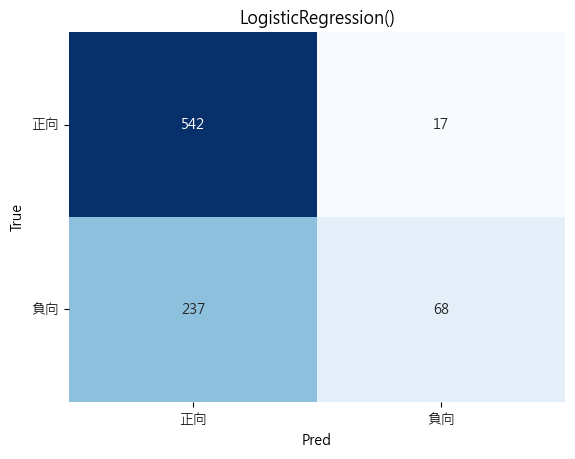

In [ ]:
vectorizer = TfidfVectorizer(max_features=1000)
clf = LogisticRegression()
result = train_cv(vectorizer, clf, X_train, y_train)

now training: clf_logistic
              precision    recall  f1-score   support

          正向       0.70      0.97      0.81       559
          負向       0.80      0.22      0.35       305

    accuracy                           0.71       864
   macro avg       0.75      0.60      0.58       864
weighted avg       0.73      0.71      0.65       864

now training: clf_dtree
              precision    recall  f1-score   support

          正向       0.72      0.76      0.74       559
          負向       0.52      0.47      0.49       305

    accuracy                           0.66       864
   macro avg       0.62      0.62      0.62       864
weighted avg       0.65      0.66      0.66       864

now training: clf_svm
              precision    recall  f1-score   support

          正向       0.69      0.99      0.82       559
          負向       0.90      0.20      0.33       305

    accuracy                           0.71       864
   macro avg       0.80      0.60      0.57       864
w

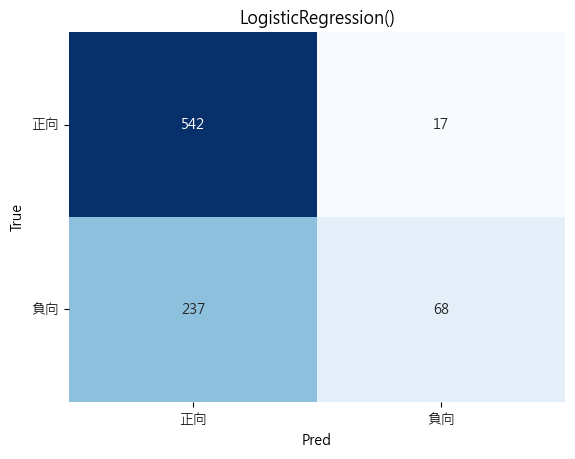

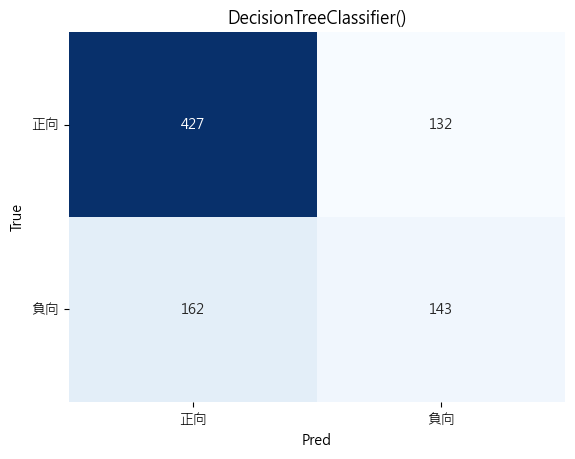

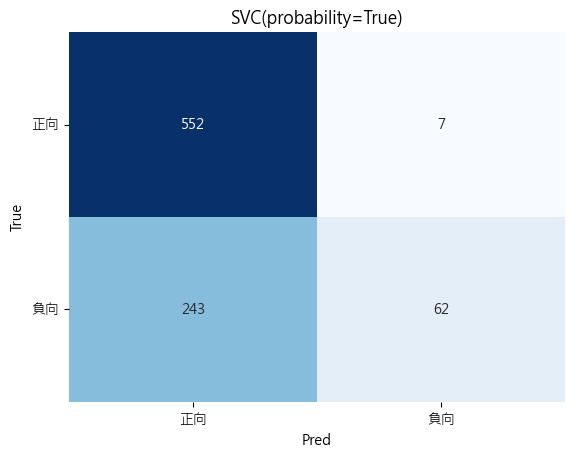

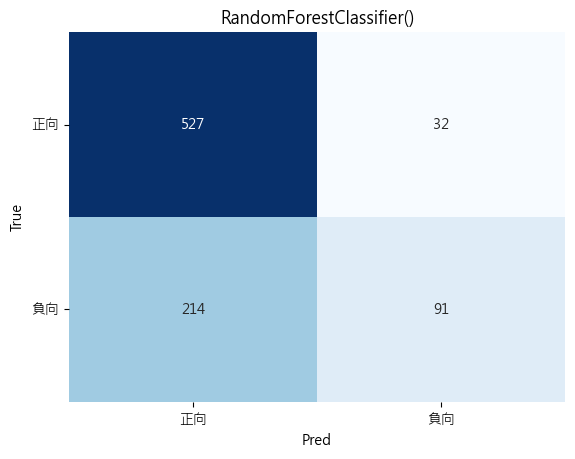

In [ ]:
# 準備訓練資料
X = data["words"]
y = data["sentiment_class"]

# 把整個資料集八二切
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=777
)
# 定義模型訓練組合
model_set = dict()
model_set['clf_logistic'] = LogisticRegression()
model_set['clf_dtree'] = DecisionTreeClassifier()
model_set['clf_svm'] = svm.SVC(probability=True) # 要使用SVM的predict_proba的話，必須在叫出SVC的時候就將probability設為True
model_set['clf_rf'] = RandomForestClassifier()
# 定義 vectorizer
# vectorizer = CountVectorizer(max_features=1000)
vectorizer = TfidfVectorizer(max_features=1000)
# 存結果
result_set = dict()

for k, model in model_set.items():
    print("="*100)
    print(f"now training: {k}")
    result_set[k] = train_cv(vectorizer, model, X_train, y_train)
    print("="*100)


#### 4.2 分析測試結果

分別觀察各個分類模型在不同類別的評估指標表現如何

In [ ]:
result_set['clf_logistic']

{'正向': {'precision': 0.6957637997432606,
  'recall': 0.9695885509838998,
  'f1-score': 0.8101644245142003,
  'support': 559.0},
 '負向': {'precision': 0.8,
  'recall': 0.22295081967213115,
  'f1-score': 0.3487179487179487,
  'support': 305.0},
 'accuracy': 0.7060185185185185,
 'macro avg': {'precision': 0.7478818998716303,
  'recall': 0.5962696853280155,
  'f1-score': 0.5794411866160745,
  'support': 864.0},
 'weighted avg': {'precision': 0.732560143583892,
  'recall': 0.7060185185185185,
  'f1-score': 0.6472695459055698,
  'support': 864.0}}

找出 F1-Score 表現最好的模型作為最終得到的分類器

In [ ]:
max = 0
best_model_name = ""
best_model_metric = "f1-score"

## choose max f1-score model from result_set
for k, v in result_set.items():
    if v['weighted avg'][best_model_metric] > max:
        max = v['weighted avg'][best_model_metric]
        best_model_name = k
print(f"best model: {best_model_name}")
pprint(result_set[best_model_name])

best model: clf_rf
{'accuracy': 0.7152777777777778,
 'macro avg': {'f1-score': 0.618001437814522,
               'precision': 0.725519238998058,
               'recall': 0.6205577876184052,
               'support': 864.0},
 'weighted avg': {'f1-score': 0.6746715991692627,
                  'precision': 0.7213099652926354,
                  'recall': 0.7152777777777778,
                  'support': 864.0},
 '正向': {'f1-score': 0.8107692307692308,
        'precision': 0.7112010796221323,
        'recall': 0.9427549194991055,
        'support': 559.0},
 '負向': {'f1-score': 0.4252336448598131,
        'precision': 0.7398373983739838,
        'recall': 0.2983606557377049,
        'support': 305.0}}


In [ ]:
y_pred = model_set['clf_rf'].predict(vectorizer.transform(X_test).toarray())
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          正向       0.74      0.93      0.82       151
          負向       0.61      0.26      0.36        66

    accuracy                           0.72       217
   macro avg       0.67      0.59      0.59       217
weighted avg       0.70      0.72      0.68       217



In [ ]:
model_set['clf_svm'].predict(vectorizer.transform(["菲律賓 大學 要求 帶防 作弊 憤怒 皮卡丘 同台 東森 新聞 菲律賓 一名 大學教授"]).toarray())

array(['正向'], dtype=object)

我們從根據評估指標，推斷最佳的分類 model 為 `隨機森林`。

#### 5.0 分析可解釋模型的結果

#### 5.1 迴歸係數

各字詞特徵的迴歸係數，可了解該特徵對事件發生機率的影響

In [ ]:
def plot_coef(logistic_reg_model, feature_names, top_n=10):
    # 選出某個類別的前10大影響力字詞
    log_odds = logistic_reg_model.coef_.T
    coef_df = pd.DataFrame(
        log_odds, 
        columns=logistic_reg_model.classes_, index=feature_names
    )
    for label in coef_df.columns:
        select_words = (
            coef_df[[label]]
            .sort_values(by=label, ascending=False)
            .iloc[np.r_[0:top_n, -top_n:0]]
        )
        word = select_words.index
        count = select_words[label]
        category_colors = np.where(
            select_words[label] >= 0, "darkseagreen", "rosybrown"
        )  # 設定顏色

        fig, ax = plt.subplots(figsize=(8, top_n*0.8))  # 設定畫布
        plt.rcParams["axes.unicode_minus"] = False

        ax.barh(word, count, color=category_colors)
        ax.invert_yaxis()
        ax.set_title(
            "Coeff increase/decrease odds ratio of 「" + label + "」 label the most",
            loc="left",
            size=16,
        )
        ax.set_ylabel("word", size=14)
        ax.set_xlabel("odds ratio", size=14)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def plot_coef(logistic_reg_model, feature_names, top_n=10):
    # 檢查是否為二分類
    if logistic_reg_model.coef_.shape[0] == 1:
        coefs = logistic_reg_model.coef_[0]
        label = logistic_reg_model.classes_[1]  # 預設對正類別分析
        print(f"🔍 二分類模型，分析類別：{label}")
    else:
        raise ValueError("目前函數只支援二分類的 LogisticRegression")

    coef_df = pd.Series(coefs, index=feature_names)
    top_features = pd.concat([coef_df.sort_values(ascending=False).head(top_n),
                              coef_df.sort_values().head(top_n)])

    plt.figure(figsize=(10, 6))
    colors = ['green' if c > 0 else 'red' for c in top_features]
    top_features.plot(kind='barh', color=colors)
    plt.title(f"Top {top_n} Features for Class '{label}'")
    plt.xlabel("Coefficient Value")
    plt.tight_layout()
    plt.show()


🔍 二分類模型，分析類別：負向


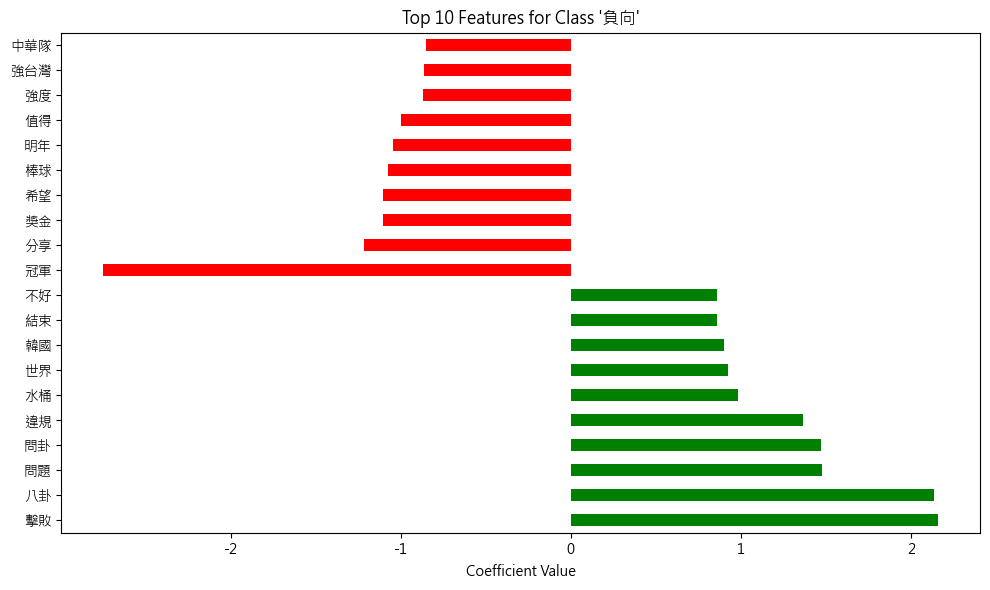

In [ ]:
plot_coef(logistic_reg_model=model_set['clf_logistic'], feature_names=vectorizer.get_feature_names_out(), top_n=10)

- 「正向」中出現了冠軍、應援等相關字詞；
- 「負向」中高係數的字是違規、問題等

#### 5.2 用訓練好的分類器來預測其他文章

我們前面使用ptt上跟棒球相關的資料訓練好了分類器模型，接著用其他主題的資料試試看分類的效果。

##### 5.2.0 資料集介紹
- `ptt_olympics_sentiment.csv` 為ptt八卦版上有關巴黎奧運資料
- 時間範圍：2024/07/20 ~ 2024/08/15
- 工作流程平台搜尋關鍵字：巴黎奧運

In [ ]:
ct = pd.read_csv("./raw_data/ptt_olympics_sentiment.csv")
ct.dropna(inplace=True)

##### 5.2.1 資料清理

In [ ]:
# 移除網址格式
ct["artContent"] = ct["artContent"].str.replace(r"(http|https):\/\/[^\s]+", "", regex=True)
ct["artContent"] = ct["artContent"].str.replace(r"\S+\.(jpg|jpeg|png|gif|bmp|webp)", "", regex=True)
ct["artContent"] = ct["artContent"].str.replace(r"[^\u4e00-\u9fa5]+", "", regex=True)

ct["artTitle"].str.replace("(http|https)://.*", "", regex=True)
ct["artContent"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)
ct["artTitle"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)

# 留下 content
ct["content"] = ct["artTitle"] + ct["artContent"]
ct = ct.loc[:,["content", "artUrl", "sentiment_class"]]  # 文章內容 文章連結

# 設定斷詞 function
def getToken(row):
    seg_list = jieba.cut(row, cut_all=False)
    seg_list = [
        w for w in seg_list if w not in stopWords and len(w) > 1
    ]  # 篩選掉停用字與字元數大於1的詞彙
    return seg_list

ct["words"] = ct["content"].apply(getToken).map(" ".join)
ct.head()

content  \
0  [問卦]奧運不到7天開幕，台灣這邊很冷沒熱度？話說巴黎奧運七天後下禮拜就開幕了有些比賽在開幕...   
1  [問卦]奧運美國隊吹冷氣，台灣吹電扇？為環保不裝冷氣巴黎奧運選手村只有電扇美國隊宣布自備空調...   
2  Re:[問卦]參加巴黎奧運還要叫中華台北？其實昨天的職棒明星賽也是啊明明球衣前面寫主播卻喊是...   
3  [問卦]詹家姐妹要怎樣才能洗白？網球版只要有登詹家姊妹的新聞下面的鄉民留言都沒什麼好話詹家姐...   
4  [問卦]阿爆算是幾線藝人看阿爆是參加巴黎奧運的文化奧運代表之一以前看到他時覺得是阿妹接班人但...   

                                              artUrl sentiment_class  \
0  https://www.ptt.cc/bbs/Gossiping/M.1721408773....              正向   
1  https://www.ptt.cc/bbs/Gossiping/M.1721482844....              正向   
2  https://www.ptt.cc/bbs/Gossiping/M.1721626416....              負向   
3  https://www.ptt.cc/bbs/Gossiping/M.1721656011....              正向   
4  https://www.ptt.cc/bbs/Gossiping/M.1721790304....              負向   

                                               words  
0  問卦 奧運 不到 開幕 台灣 熱度 巴黎 奧運 七天 下禮拜 開幕 比賽 開幕 進行 預賽 ...  
1  問卦 奧運 美國隊 吹冷氣 台灣 電扇 環保 冷氣 巴黎 奧運 選手村 電扇 美國隊 宣布 ...  
2  Re 問卦 參加 巴黎 奧運 還要 中華 台北 昨天 職棒 明星 明明 球衣 前面 寫主播 ...  
3  問卦 詹家 姐妹 怎樣才能 洗白 網球 詹家 姊妹 新聞 下面 鄉民 留言 沒什麼 好話 詹...  
4  問卦 阿爆 算是 幾線 藝人 阿爆 參加 巴黎 奧運 文化 奧運 代表 以前 看到 他時 覺...

觀察資料集的分佈狀況

In [ ]:
ct['sentiment_class'].value_counts()

sentiment_class
正向    153
負向    125
Name: count, dtype: int64

##### 5.2.2 進行分類任務

將類別mapping到分類器的類別，接著開始進行分類任務

In [ ]:
mapper = {"正向":"正向", "負向":"負向"}
ct['sentiment_class'] = ct['sentiment_class'].map(mapper)

X = ct['words']
y = ct['sentiment_class']

y = y.astype(str)
y_pred = y_pred.astype(str)

y_pred = model_set[best_model_name].predict(vectorizer.transform(X).toarray())
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

          正向       0.58      0.80      0.67       153
          負向       0.55      0.30      0.39       125

    accuracy                           0.58       278
   macro avg       0.57      0.55      0.53       278
weighted avg       0.57      0.58      0.55       278



- 模型在巴黎奧運的資料集上表現不佳，`Accuracy僅約 60%`。
- 正向的 recall 較高，但負向的 recall 數值較低。
- 模型偏向預測正向，對負向情緒辨識能力不足，可能是資料分布或語言風格差異所致。

##### 5.2.3 研究分類的結果，找出問題原因

In [ ]:
ct['pred'] = y_pred
ct.loc[:,['words', 'sentiment_class',"pred"]]

words sentiment_class pred
0    問卦 奧運 不到 開幕 台灣 熱度 巴黎 奧運 七天 下禮拜 開幕 比賽 開幕 進行 預賽 ...              正向   正向
1    問卦 奧運 美國隊 吹冷氣 台灣 電扇 環保 冷氣 巴黎 奧運 選手村 電扇 美國隊 宣布 ...              正向   正向
2    Re 問卦 參加 巴黎 奧運 還要 中華 台北 昨天 職棒 明星 明明 球衣 前面 寫主播 ...              負向   正向
3    問卦 詹家 姐妹 怎樣才能 洗白 網球 詹家 姊妹 新聞 下面 鄉民 留言 沒什麼 好話 詹...              正向   負向
4    問卦 阿爆 算是 幾線 藝人 阿爆 參加 巴黎 奧運 文化 奧運 代表 以前 看到 他時 覺...              負向   負向
..                                                 ...             ...  ...
273  問卦 這次 奧運 流傳後世 經典 片段 感覺 這次 奧運 好像 特別 記憶 點的 事情 默默...              正向   正向
274  爆卦 2024 巴黎 奧運金牌 巴黎 奧運 各國 金牌 人口 金牌 人口 金牌 人口 百萬 ...              正向   正向
275  問卦 這次 Curry MVP 算是 如題 最近 剛過 結束 巴黎 奧運 美國 男籃 不出意...              負向   負向
276  問卦 RichardDawkins 暗示 林郁婷 假裝 女性 英國 演化 生物學家 暗示 林...              負向   負向
277  Re 新聞 奧運 金牌數 相同 分析 體育 體制 原文 偷渡 意識形態 東西 不吐 不快 美...              正向   正向

[278 rows x 3 columns]

將錯誤分類的結果篩選出來

In [ ]:
false_pred = ct.query("sentiment_class != pred").loc[:,['words', 'sentiment_class',"pred"]]
false_pred

words sentiment_class pred
2    Re 問卦 參加 巴黎 奧運 還要 中華 台北 昨天 職棒 明星 明明 球衣 前面 寫主播 ...              負向   正向
3    問卦 詹家 姐妹 怎樣才能 洗白 網球 詹家 姊妹 新聞 下面 鄉民 留言 沒什麼 好話 詹...              正向   負向
9    問卦 巴黎 奧運 開幕式 日本 奧運 好看 太多 開頭 現在 冷場 上次 日本 知道 衝三小...              負向   正向
11   問卦 台灣 法國 垃圾 法國巴黎 奧運 最大 心得 台灣 奧運 能力 政治 問題 政治 問題...              負向   正向
12   問卦 巴黎 奧運 搭船 進場 無趣 這次 奧運 開幕 首次 船上 進場 下雨 雨衣 難看 實...              負向   正向
..                                                 ...             ...  ...
263  Re 問卦 巴黎 奧運 人均 獎牌榜 台灣 54 中國 75 青鳥 創造性 自慰 噴飯 奧運...              負向   正向
264  Re 問卦 巴黎 奧運 人均 獎牌榜 台灣 54 中國 75 麻煩 青鳥 出征 隊伍 修目 ...              負向   正向
267  問卦 洛杉磯 奧運 開幕會 巴黎 幾條 安安 巴黎 奧運 結束 阿湯哥 交棒給 一屆 洛杉磯...              正向   負向
270  問卦 油管 留言 兄弟 丟臉 台灣 之恥 罷凌林 郁婷 打開 看到 推薦 澳洲 天空 新聞 ...              負向   正向
272  Re 爆卦 巴黎 長榮 桂冠 酒店 拒掛 中國 國旗 大陸 法國巴黎 奧運 某種程度 親中 ...              負向   正向

[118 rows x 3 columns]

觀察負向文章的模型給出的分類結果

In [ ]:
false_pred.loc[false_pred['sentiment_class']=='負向', :].head(20)

words sentiment_class pred
2   Re 問卦 參加 巴黎 奧運 還要 中華 台北 昨天 職棒 明星 明明 球衣 前面 寫主播 ...              負向   正向
9   問卦 巴黎 奧運 開幕式 日本 奧運 好看 太多 開頭 現在 冷場 上次 日本 知道 衝三小...              負向   正向
11  問卦 台灣 法國 垃圾 法國巴黎 奧運 最大 心得 台灣 奧運 能力 政治 問題 政治 問題...              負向   正向
12  問卦 巴黎 奧運 搭船 進場 無趣 這次 奧運 開幕 首次 船上 進場 下雨 雨衣 難看 實...              負向   正向
13  問卦 現場 巴黎 奧運 開幕 觀眾 氣炸 有別於 以往 開幕式 集中 體育場 裡頭照 時間 ...              負向   正向
15  Re 新聞 巴黎 奧運 開幕 中華 台北 進場 法國 主持 可悲 對外 只能 中華 台北 名...              負向   正向
16  Re 問卦 奧運 世界杯 規模 比較 一下 桌球 馬龍 真的 超級 桌球 奧運 兩次 冠軍 ...              負向   正向
19  問卦 德國隊 這次 巴黎 奧運 進場 幾分 安安 巴黎 奧運 今年 已經 第三次 每次 德國...              負向   正向
20  問卦 法國人 堅持 塞納河 游泳 比賽 這次 巴黎 奧運 游泳 比賽 一些 項目 鐵人三項 ...              負向   正向
21  Re 新聞 巴黎 奧運 拒絕 以色列 參賽 IOC 主席 以色列 比賽 場上 全場 一堆 人...              負向   正向
23  Re 新聞 巴黎 奧運 拒絕 以色列 參賽 IOC 主席 比照辦理 存在 一定 難度 俄羅斯...              負向   正向
25  Re 新聞 巴黎 奧運 拒絕 以色列 參賽 IOC 主席 希特勒 年代 整個 歐洲 猶太人 ...              負向   正向
27  Re 新聞 巴黎 奧運 拒絕 以色列 參賽 IOC 主席 奧多 這篇 回應 一場 軍事行動 ...              負向   正向
32  問卦 中國 馬術 選手 華天 很會 投胎 中國 馬術 選手 華天 維基百科 介紹 華天 爺爺...              負向   正向
33  問卦 小紅書 台灣省 組隊 有篇文 標題 巴黎 奧運 中國 台灣 省隊 出場 影片 開幕式 ...              負向   正向
35  問卦 日本 奧運 開幕 記憶 點的 肥魯 印象 一屆 日本 奧運 開幕式 無聊 無聊 記憶 ...              負向   正向
36  問卦 法國 奧運 官網 ChineseTaipei 惟一 翻譯 很難 翻譯 巴黎 奧運 官網...              負向   正向
39  問卦 這次 奧運 關注 爭議 這次 巴黎 奧運 感覺 台灣 關注 以往 爭議 爆發 一大堆 ...              負向   正向
41  Re 新聞 巴黎 奧運 福原 愛喊 中國隊 加油 日年 終於 回來 還從 日本 中國 圖片 ...              負向   正向
48  問卦 lgbt cos 佛教 道教 神明 請問 一下 巴黎 奧運 開幕式 安排 團體 最後 ...              負向   正向

挑選一篇負向的文章觀察看看內容，為何模型會將其分類成正向的

In [ ]:
pprint(false_pred['words'][51])

('問卦 韓國 網友 法國 不愧 歐洲 中國 褒還 請問 一下 這次 巴黎 奧運 法國政府 一堆 韓國 叫成 朝鮮 電視 韓國 國旗 韓國 網友 生氣 說法 '
 '不愧 歐洲 中國 這句 還貶')


這篇文章其實是在抱怨，但用詞較中性，加上出現很多像「歐洲」「中國」「韓國」等地名，模型可能抓不到明顯的負面情緒。雖有負面情緒字如「生氣」等，但整體語氣不夠強烈，所以被誤判成正向了。可能模型對語氣和上下文還不太理解

## 113-2 社群媒體分析 第二次讀書會 - 3

想知道在12強棒球賽期間，新聞媒體還同時關注了哪些主題/議題，並想審視LDA模型是否能有效劃分出與12強棒球賽相關的主題。

### 主題模型實作


- 組別 : 第一組 
- 作者 : 莊子儀 
- 日期 : 2025/04/17

#### 載入套件

In [ ]:
import time 
from functools import reduce
from collections import Counter
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import jieba
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.matutils import corpus2csc, corpus2dense, Sparse2Corpus

import pyLDAvis
import pyLDAvis.gensim_models

In [ ]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [ ]:
# 設定中文字體
plt.rcParams['font.sans-serif'] = ['Arial Unicode Ms'] #使圖中中文能正常顯示
plt.rcParams['axes.unicode_minus'] = False #使負號能夠顯示

#### 資料集介紹

- 時間: 2024/11/01 ~ 2024/11/30
- 來源: 東森新聞 `健康`、`國際`、`娛樂`、`政治`、`社會`、`財經`、`體育`板
- 關鍵字: 無
- 筆數: 5776

#### 0.0 資料前處理

In [ ]:
ebc = pd.read_csv("raw_data/news202411.csv")  # 匯資料
ebc.head(3)

system_id                   artTitle  \
0         1   快訊／台股開盤大跌「近600點」 台積電千元失守   
1         2  台積電「一度破千」瘋搶！ 台股跌幅收斂下挫360點   
2         3    川普若大獲全勝 花旗勸「高割離席」：反彈就是賣   

                                         artUrl              artDate  \
0  https://news.ebc.net.tw/news/business/451366  2024-11-01 09:12:00   
1  https://news.ebc.net.tw/news/business/451370  2024-11-01 09:16:00   
2  https://news.ebc.net.tw/news/business/451379  2024-11-01 09:48:00   

  artCatagory                                         artContent dataSource  
0          財經  台股受到美股10月31日科技股領跌、全面收黑影響，今（1日）開盤就大跌將近600點，台積電（...        EBC  
1          財經  台股今（1）日早盤跳空開低，一度下探22231點，跌逾580點，隨後出現買單急拉，跌點收斂至...        EBC  
2          財經  美國總統大選將在5日公布結果，由於市場已因川普（Donald Trump）可能再度當選的預期...        EBC

In [ ]:
# 移除網址格式
# 只留下中文字
ebc["artContent"] = ebc["artContent"].str.replace("(http|https)://.*", "", regex=True)
ebc["artTitle"] = ebc["artTitle"].str.replace("(http|https)://.*", "", regex=True)
ebc["artContent"] = ebc["artContent"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)
ebc["artTitle"] = ebc["artTitle"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)
ebc['artDate'] = pd.to_datetime(ebc['artDate'])
ebc['content'] = ebc['artContent']


ebc = ebc.loc[:,["content", "artUrl", "artCatagory", 'artDate']]  # 文章內容 文章連結
ebc.head(3)

content  \
0  台股受到美股月日科技股領跌全面收黑影響今日開盤就大跌將近點台積電股價失守元大關重挫元來到元美...   
1  台股今日早盤跳空開低一度下探點跌逾點隨後出現買單急拉跌點收斂至點左右預估成交量放大至億櫃買指...   
2  美國總統大選將在日公布結果由於市場已因川普可能再度當選的預期而帶動美股上漲花旗分析師指出若共...   

                                         artUrl artCatagory  \
0  https://news.ebc.net.tw/news/business/451366          財經   
1  https://news.ebc.net.tw/news/business/451370          財經   
2  https://news.ebc.net.tw/news/business/451379          財經   

              artDate  
0 2024-11-01 09:12:00  
1 2024-11-01 09:16:00  
2 2024-11-01 09:48:00

#### 0.1 文章斷詞

In [ ]:
# 設定繁體中文詞庫
jieba.set_dictionary("dict/dict.txt")

# 新增stopwords
# jieba.analyse.set_stop_words('./dict/stop_words.txt') #jieba.analyse.extract_tags才會作用
with open("dict/stopwords.txt", encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

# 設定斷詞 function
def getToken(row):
    seg_list = jieba.cut(row, cut_all=False)
    seg_list = [
        w for w in seg_list if w not in stopWords and len(w) > 1
    ]  # 篩選掉停用字與字元數大於1的詞彙
    return seg_list

# 在套用 getToken 前先確保 content 欄位為字串類型
ebc["content"] = ebc["content"].astype(str)
# 過濾掉 'nan' 字串（轉換後的 NaN 值）
ebc.loc[ebc["content"] == 'nan', "content"] = ''

ebc["words"] = ebc["content"].apply(getToken)
ebc.head(3)

Building prefix dict from c:\Users\julie\Desktop\SMA_2025S-main\第二次讀書會\dict\dict.txt ...
2025-04-16 17:50:47,975 : DEBUG : Building prefix dict from c:\Users\julie\Desktop\SMA_2025S-main\第二次讀書會\dict\dict.txt ...
Loading model from cache C:\Users\julie\AppData\Local\Temp\jieba.uf44602ee7fa2a5a27f515b1b87bf7e34.cache
2025-04-16 17:50:47,977 : DEBUG : Loading model from cache C:\Users\julie\AppData\Local\Temp\jieba.uf44602ee7fa2a5a27f515b1b87bf7e34.cache
Loading model cost 0.576 seconds.
2025-04-16 17:50:48,552 : DEBUG : Loading model cost 0.576 seconds.
Prefix dict has been built successfully.
2025-04-16 17:50:48,553 : DEBUG : Prefix dict has been built successfully.


content  \
0  台股受到美股月日科技股領跌全面收黑影響今日開盤就大跌將近點台積電股價失守元大關重挫元來到元美...   
1  台股今日早盤跳空開低一度下探點跌逾點隨後出現買單急拉跌點收斂至點左右預估成交量放大至億櫃買指...   
2  美國總統大選將在日公布結果由於市場已因川普可能再度當選的預期而帶動美股上漲花旗分析師指出若共...   

                                         artUrl artCatagory  \
0  https://news.ebc.net.tw/news/business/451366          財經   
1  https://news.ebc.net.tw/news/business/451370          財經   
2  https://news.ebc.net.tw/news/business/451379          財經   

              artDate                                              words  
0 2024-11-01 09:12:00  [台股, 美股, 科技, 股領跌, 全面, 收黑, 影響, 今日, 開盤, 大跌, 台積電,...  
1 2024-11-01 09:16:00  [台股, 今日, 早盤, 跳空, 開低, 一度下, 探點, 跌逾點, 出現, 買單, 急拉,...  
2 2024-11-01 09:48:00  [美國, 總統, 大選, 將在, 公布, 市場, 已因, 川普, 再度, 當選, 預期, 帶...

In [ ]:
ebc.count()

content        5776
artUrl         3880
artCatagory    3880
artDate        3880
words          5776
dtype: int64

#### 1.0 人工給定主題的主題模型

In [ ]:
ebc.groupby(['artCatagory']).size()

artCatagory
健康      71
國際     560
娛樂    1069
政治     239
社會    1169
財經     159
體育     613
dtype: int64

資料包含七大版面: `健康`、`國際`、`娛樂`、`政治`、`社會`、`財經`、`體育`

#### 1.1 自訂義主題詞彙

In [ ]:
# 根據 7 個主題給予領域的相關詞彙
custom_topic_word = {
    "健康": [
        "健康", "醫療", "醫院", "醫師", "疾病", "治療", "症狀", "患者", "研究", "藥物", 
        "保健", "身體", "預防", "癌症", "飲食", "運動", "病毒", "心臟", "感染", "血壓"
    ],
    "國際": [
        "中國", "表示", "大陸", "台灣", "發展", "工作", "國家", "政府", "指出", "美國",
        "歐洲", "日本", "俄羅斯", "聯合國", "外交", "峰會", "協議", "總統", "戰爭", "經濟"
    ],
    "娛樂": [
        "演員", "電影", "節目", "導演", "粉絲", "演出", "明星", "藝人", "偶像", "歌手",
        "作品", "表演", "音樂", "戲劇", "影片", "劇情", "製作", "演藝", "發行", "頒獎"
    ],
    "政治": [
        "政府", "總統", "立法院", "政黨", "選舉", "立委", "民進黨", "國民黨", "政策", "行政院",
        "總理", "外交", "兩岸", "改革", "議員", "投票", "法案", "民意", "公投", "內閣"
    ],
    "社會": [
        "表示", "警方", "今天", "男子", "發現", "發生", "記者", "萬元", "報導", "指出",
        "女子", "事件", "現場", "調查", "家屬", "學生", "民眾", "學校", "傷害", "車禍"
    ],
    "財經": [
        "中國", "大陸", "兩岸", "習近平", "北京", "人民幣", "中共", "上海", "國務院", "李強",
        "華為", "政協", "兩會", "股市", "投資", "經濟", "企業", "股票", "市場", "基金",
        "銀行", "財報", "成長", "金融", "台股", "匯率", "貿易", "債券", "資產", "房地產"
    ],
    "體育": [
        "比賽", "選手", "冠軍", "球隊", "運動", "教練", "球員", "賽事", "奧運", "世界盃",
        "得分", "籃球", "足球", "棒球", "成績", "聯盟", "奪冠", "對決", "金牌", "球季"
    ]
}

#### 1.2 轉換為NumPy Array形式

從 custom_topic_word 的所有值中，整理出不重複的詞彙（vocabularies），並以 NumPy 陣列的形式儲存。

In [ ]:
vocabularies = np.unique(reduce(lambda x, y: x + y, custom_topic_word.values()))

In [ ]:
vocabularies

array(['上海', '世界盃', '中共', '中國', '事件', '人民幣', '今天', '企業', '作品', '俄羅斯',
       '保健', '健康', '偶像', '債券', '傷害', '內閣', '兩岸', '兩會', '公投', '冠軍', '劇情',
       '北京', '匯率', '協議', '台灣', '台股', '國務院', '國家', '國民黨', '基金', '報導', '外交',
       '大陸', '奧運', '奪冠', '女子', '學校', '學生', '家屬', '對決', '導演', '峰會', '工作',
       '市場', '影片', '得分', '心臟', '患者', '感染', '成績', '成長', '戰爭', '戲劇', '房地產',
       '投票', '投資', '指出', '改革', '政協', '政府', '政策', '政黨', '教練', '日本', '明星',
       '李強', '棒球', '歌手', '歐洲', '比賽', '民意', '民眾', '民進黨', '治療', '法案', '演出',
       '演員', '演藝', '現場', '球員', '球季', '球隊', '男子', '疾病', '病毒', '症狀', '癌症',
       '發展', '發現', '發生', '發行', '研究', '立委', '立法院', '節目', '籃球', '粉絲', '經濟',
       '總理', '總統', '美國', '習近平', '聯合國', '聯盟', '股市', '股票', '華為', '萬元', '藝人',
       '藥物', '血壓', '行政院', '表演', '表示', '製作', '記者', '調查', '警方', '議員', '財報',
       '貿易', '資產', '賽事', '足球', '身體', '車禍', '運動', '選手', '選舉', '醫師', '醫療',
       '醫院', '金牌', '金融', '銀行', '電影', '音樂', '預防', '頒獎', '飲食'], dtype='<U3')

#### 1.3 CountVectorizer

利用 CountVectorizer 的 vocabulary 參數來篩選、製作 DTM

In [ ]:
ebc_corpus = ebc['words'].map(" ".join)
vectorizer = CountVectorizer(vocabulary=vocabularies)
ebc_matrix = vectorizer.fit_transform(ebc_corpus)

ebc_matrix = ebc_matrix.toarray()
feature_names = vectorizer.get_feature_names_out()

DTM_df = pd.DataFrame(columns = feature_names, data = ebc_matrix)
DTM_df

上海  世界盃  中共  中國  事件  人民幣  今天  企業  作品  俄羅斯  ...  醫療  醫院  金牌  金融  銀行  電影  \
0      0    0   0   0   0    0   1   0   0    0  ...   0   0   0   0   0   0   
1      0    0   0   0   0    0   0   0   0    0  ...   0   0   0   0   0   0   
2      0    0   0   0   0    0   0   1   0    0  ...   0   0   0   0   0   0   
3      0    0   0   0   0    0   0   0   0    0  ...   0   0   0   0   0   0   
4      0    0   0   2   0    0   0   0   0    0  ...   0   0   0   0   0   0   
...   ..  ...  ..  ..  ..  ...  ..  ..  ..  ...  ...  ..  ..  ..  ..  ..  ..   
5771   0    0   0   0   2    0   0   0   0    2  ...   0   0   0   0   0   0   
5772   0    0   0   0   0    0   0   0   0    0  ...   0   0   0   0   0   0   
5773   0    0   0   0   0    0   0   0   0    0  ...   0   0   0   0   0   0   
5774   0    0   0   0   0    0   0   0   0    0  ...   0   0   0   2   1   0   
5775   0    0   0   0   0    0   0   0   0    0  ...   0   0   0   0   0   0   

      音樂  預防  頒獎  飲食  
0      0   0   0   0  
1      0   0   0   0  
2      0   0   0   0  
3      0   0   0   0  
4      0   0   0   0  
...   ..  ..  ..  ..  
5771   0   0   0   0  
5772   0   0   0   0  
5773   0   0   0   0  
5774   0   0   0   0  
5775   0   0   0   0  

[5776 rows x 140 columns]

#### 1.4 整理成DataFrame

針對每個「自定義主題」，統計每篇文章在該主題下出現的詞彙總次數，整理成一個DataFrame

In [ ]:
df_count = pd.DataFrame({})

# k 是主題名稱，v 是這個主題下的詞彙list
for k, v in custom_topic_word.items():
    idx = np.isin(
        feature_names,
        v
    )
    df_count[f'topic_{k}'] = ebc_matrix[:, idx].sum(axis=1)
    
df_count

topic_健康  topic_國際  topic_娛樂  topic_政治  topic_社會  topic_財經  topic_體育
0            0         4         0         1         3         6         0
1            0         0         0         0         0         2         0
2            0         4         0         3         3         7         0
3            0         3         1         1         0         6         0
4            0        35         0         7         3         6         0
...        ...       ...       ...       ...       ...       ...       ...
5771         0         7         0         0        26         0         0
5772         0         0         0         0         0         0         0
5773         0         0         0         0         0         0         0
5774         0         6         0         2         3         6         0
5775         0         2         0         0         9         0         0

[5776 rows x 7 columns]

#### 1.5 各主題相對權重

把每篇文章在各個主題的出現次數轉換成主題分佈機率（比例），也就是 每篇文章屬於各個主題的相對權重（theta 向量）

In [ ]:
thetas = df_count.div(
    df_count.sum(axis=1),
    axis=0
)
thetas.head()

topic_健康  topic_國際  topic_娛樂  topic_政治  topic_社會  topic_財經  topic_體育
0       0.0  0.285714  0.000000  0.071429  0.214286  0.428571       0.0
1       0.0  0.000000  0.000000  0.000000  0.000000  1.000000       0.0
2       0.0  0.235294  0.000000  0.176471  0.176471  0.411765       0.0
3       0.0  0.272727  0.090909  0.090909  0.000000  0.545455       0.0
4       0.0  0.686275  0.000000  0.137255  0.058824  0.117647       0.0

- 前五篇文章原屬於財經，在財經的相對權重皆偏向財經，效果不錯
- 發現財經與國際之權重相對其他主題較高，可能在財經版中討論台股時會一同討論到美國股市等情形。

#### 2.0 LDA主題模型

#### 2.1 斷詞結果轉成List


將斷詞後的`doc['words']`轉換成list

In [ ]:
docs = ebc['words'].to_list()
docs[0]

['台股',
 '美股',
 '科技',
 '股領跌',
 '全面',
 '收黑',
 '影響',
 '今日',
 '開盤',
 '大跌',
 '台積電',
 '股價',
 '失守',
 '大關',
 '重挫',
 '來到',
 '美股',
 '全面',
 '收黑',
 '道瓊',
 '工業',
 '指數',
 '下跌',
 '跌幅',
 '以點',
 '作收',
 '標準',
 '普爾',
 '指數',
 '下跌',
 '跌幅',
 '以點',
 '作收',
 '廣告',
 '科技股',
 '為主',
 '那斯',
 '達克',
 '指數',
 '重挫',
 '跌幅',
 '以點',
 '作收',
 '費城',
 '半導體',
 '指數',
 '大跌',
 '跌幅',
 '以點',
 '作收',
 '台股',
 '康芮',
 '颱風',
 '休市',
 '一天',
 '依舊',
 '美股',
 '利空',
 '開盤',
 '呈現',
 '下跌',
 '趨勢',
 '中央社',
 '報導',
 '本土',
 '期貨',
 '法人',
 '指出',
 '美國',
 '總統',
 '大選',
 '下週',
 '將屆',
 '選情',
 '緊繃',
 '狀況',
 '混沌',
 '不明',
 '市場',
 '避險',
 '情緒',
 '高漲',
 '短線',
 '股市',
 '波動',
 '難免',
 '預期',
 '台股',
 '今天',
 '走勢',
 '震盪',
 '劇烈',
 '排除',
 '回測',
 '半年線',
 '約點',
 '支撐',
 '下週',
 '美國',
 '聯邦',
 '準備',
 '理事會',
 '召開',
 '聯邦',
 '公開',
 '市場',
 '委員會',
 '會議',
 '攸關',
 '利率',
 '決策',
 '動向']

#### 2.2 保留特定條件詞彙

建立並過濾詞彙表（dictionary），只保留特定條件的詞彙

參數說明：
- no_below = 10	出現在少於 10 篇文章中的詞會被移除
- no_above = 0.7	出現在超過 70% 文件中的詞會被移除

In [ ]:
dictionary = Dictionary(docs)

dictionary.filter_extremes(
    no_below=10,       # 出現在至少10篇文章才保留
    no_above=0.7,      # 出現在超過70%文章的詞會被移除
    keep_n=20000       # 保留頻率最高的20000個詞
)
print(dictionary)

2025-04-16 18:14:05,522 : INFO : adding document #0 to Dictionary<0 unique tokens: []>
2025-04-16 18:14:06,139 : INFO : built Dictionary<61480 unique tokens: ['一天', '下跌', '下週', '不明', '中央社']...> from 5776 documents (total 681457 corpus positions)
2025-04-16 18:14:06,140 : INFO : Dictionary lifecycle event {'msg': "built Dictionary<61480 unique tokens: ['一天', '下跌', '下週', '不明', '中央社']...> from 5776 documents (total 681457 corpus positions)", 'datetime': '2025-04-16T18:14:06.140653', 'gensim': '4.3.3', 'python': '3.12.6 (tags/v3.12.6:a4a2d2b, Sep  6 2024, 20:11:23) [MSC v.1940 64 bit (AMD64)]', 'platform': 'Windows-11-10.0.26100-SP0', 'event': 'created'}
2025-04-16 18:14:06,182 : INFO : discarding 53753 tokens: [('休市', 3), ('利率', 9), ('利空', 9), ('回測', 7), ('將屆', 2), ('收黑', 4), ('普爾', 5), ('期貨', 8), ('混沌', 1), ('理事會', 3)]...
2025-04-16 18:14:06,183 : INFO : keeping 7727 tokens which were in no less than 10 and no more than 4043 (=70.0%) documents
2025-04-16 18:14:06,209 : INFO : resulting d

Dictionary<7727 unique tokens: ['一天', '下跌', '下週', '不明', '中央社']...>


#### 2.3 將docs轉換成BOW形式
- 把每篇文件的 token list 轉換成一組 (token_id, count) 的 list

In [ ]:
# 建立 Bag-of-words 作為文章的特徵表示
# 用 gensim ldamodel input 需要將文章轉換成 bag of words 
corpus = [dictionary.doc2bow(doc) for doc in docs]

In [ ]:
# courpus 是 list 型態
type(corpus)

list

#### 2.4 開始訓練 LDA topic model



+ 參數說明：
    + corpus = 文檔語料庫
    + id2word = 詞彙字典
    + num_topics = 生成幾個主題數
    + random_state = 固定亂數值，每次的模型結果會一樣
    + iteration = 每個文章訓練的次數，可以設定高一點讓模型收斂
    + passes(epoch) = 整個 corpus 訓練模型的次數
    + alpha = 文章主題分佈
    + eta = 主題字分佈

模型參數沒有一個絕對的答案，同學們應該**使用相同的資料**，嘗試做參數上的調整，進而比較出較佳的模型結果。

##### 2.4.1 num_topics = 7 (原來Topic數量)

In [ ]:
model_7 = LdaModel(
    corpus = corpus,
    num_topics = 7,
    id2word=dictionary,
    random_state = 2025,
    passes = 5 # 訓練次數
    )
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim_models.prepare(model_7, corpus, dictionary)
p

2025-04-16 18:16:17,268 : INFO : using symmetric alpha at 0.14285714285714285
2025-04-16 18:16:17,269 : INFO : using symmetric eta at 0.14285714285714285
2025-04-16 18:16:17,272 : INFO : using serial LDA version on this node
2025-04-16 18:16:17,277 : INFO : running online (multi-pass) LDA training, 7 topics, 5 passes over the supplied corpus of 5776 documents, updating model once every 2000 documents, evaluating perplexity every 5776 documents, iterating 50x with a convergence threshold of 0.001000
2025-04-16 18:16:17,279 : INFO : PROGRESS: pass 0, at document #2000/5776
2025-04-16 18:16:18,578 : INFO : merging changes from 2000 documents into a model of 5776 documents
2025-04-16 18:16:18,582 : INFO : topic #6 (0.143): 0.010*"表示" + 0.007*"東森" + 0.007*"新聞" + 0.005*"台灣" + 0.004*"粉絲" + 0.004*"今年" + 0.003*"希望" + 0.003*"節目" + 0.003*"透露" + 0.003*"公司"
2025-04-16 18:16:18,583 : INFO : topic #2 (0.143): 0.011*"粉絲" + 0.007*"表示" + 0.007*"東森" + 0.006*"新聞" + 0.004*"最佳" + 0.004*"演出" + 0.004*"電影" + 0

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.072899  0.081548       1        1  23.799628
1      0.230884  0.115754       2        1  19.269866
6     -0.229693  0.153141       3        1  17.014507
5      0.129130 -0.028849       4        1  13.035497
3      0.074797  0.010375       5        1  12.151415
4     -0.100948 -0.099927       6        1   9.038520
0     -0.031271 -0.232042       7        1   5.690567, topic_info=     Term         Freq        Total Category  logprob  loglift
1921  中華隊  2562.000000  2562.000000  Default  30.0000  30.0000
134    川普  1516.000000  1516.000000  Default  29.0000  29.0000
5330   警方  2026.000000  2026.000000  Default  28.0000  28.0000
50     美國  1703.000000  1703.000000  Default  27.0000  27.0000
240    台灣  3055.000000  3055.000000  Default  26.0000  26.0000
...   ...          ...          ...      ...      ...      ...
50     美國   180.982442  1703.745642   Topic7  -5.1127   0.6242
165    今年   148.460946   899.311178   Topic7  -5.3108   1.0651
240    台灣   157.119162  3055.370518   Topic7  -5.2541  -0.1013
392    全球   102.093401   262.754556   Topic7  -5.6852   1.9210
74     出現   105.816411   606.414801   Topic7  -5.6494   1.1205

[532 rows x 6 columns], token_table=      Topic      Freq Term
term                      
1016      1  0.026012   一名
1016      2  0.582527   一名
1016      3  0.017113   一名
1016      4  0.130059   一名
1016      5  0.225207   一名
...     ...       ...  ...
4734      3  0.072338   騎士
4734      7  0.002679   騎士
7229      6  0.965207  體育署
4839      5  0.961432   體重
2884      6  0.972712  黎巴嫩

[1469 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 7, 6, 4, 5, 1])

##### 2.4.2 查看LDA主題代表字

當 LDA 模型訓練好之後，我們可以查看每個主題的單詞分佈。<br>
num_words = 選擇要查看每個主題前幾個字。<br>

In [ ]:
model_7.print_topics()

2025-04-16 18:17:50,048 : INFO : topic #0 (0.143): 0.014*"東森" + 0.010*"公司" + 0.009*"新聞" + 0.009*"台積電" + 0.006*"毒品" + 0.006*"投資" + 0.006*"美國" + 0.006*"集團" + 0.006*"台股" + 0.005*"指數"
2025-04-16 18:17:50,050 : INFO : topic #1 (0.143): 0.019*"警方" + 0.014*"男子" + 0.012*"發生" + 0.008*"一名" + 0.008*"民眾" + 0.008*"東森" + 0.008*"新聞" + 0.007*"駕駛" + 0.006*"發現" + 0.006*"現場"
2025-04-16 18:17:50,050 : INFO : topic #2 (0.143): 0.010*"表示" + 0.009*"粉絲" + 0.006*"網友" + 0.006*"東森" + 0.005*"新聞" + 0.005*"生活" + 0.004*"希望" + 0.004*"分享" + 0.004*"演唱會" + 0.004*"加入"
2025-04-16 18:17:50,052 : INFO : topic #3 (0.143): 0.010*"報導" + 0.009*"表示" + 0.008*"新聞" + 0.008*"發現" + 0.008*"東森" + 0.006*"網友" + 0.005*"女兒" + 0.005*"一名" + 0.005*"更多" + 0.005*"孩子"
2025-04-16 18:17:50,052 : INFO : topic #4 (0.143): 0.030*"川普" + 0.025*"美國" + 0.014*"總統" + 0.011*"台灣" + 0.008*"中國" + 0.006*"賀錦麗" + 0.006*"表示" + 0.005*"國家" + 0.005*"大選" + 0.005*"拜登"
2025-04-16 18:17:50,055 : INFO : topic #5 (0.143): 0.008*"調查" + 0.007*"新聞" + 0.007*"東森" + 0.006*"霸凌" +

[(0,
  '0.014*"東森" + 0.010*"公司" + 0.009*"新聞" + 0.009*"台積電" + 0.006*"毒品" + 0.006*"投資" + 0.006*"美國" + 0.006*"集團" + 0.006*"台股" + 0.005*"指數"'),
 (1,
  '0.019*"警方" + 0.014*"男子" + 0.012*"發生" + 0.008*"一名" + 0.008*"民眾" + 0.008*"東森" + 0.008*"新聞" + 0.007*"駕駛" + 0.006*"發現" + 0.006*"現場"'),
 (2,
  '0.010*"表示" + 0.009*"粉絲" + 0.006*"網友" + 0.006*"東森" + 0.005*"新聞" + 0.005*"生活" + 0.004*"希望" + 0.004*"分享" + 0.004*"演唱會" + 0.004*"加入"'),
 (3,
  '0.010*"報導" + 0.009*"表示" + 0.008*"新聞" + 0.008*"發現" + 0.008*"東森" + 0.006*"網友" + 0.005*"女兒" + 0.005*"一名" + 0.005*"更多" + 0.005*"孩子"'),
 (4,
  '0.030*"川普" + 0.025*"美國" + 0.014*"總統" + 0.011*"台灣" + 0.008*"中國" + 0.006*"賀錦麗" + 0.006*"表示" + 0.005*"國家" + 0.005*"大選" + 0.005*"拜登"'),
 (5,
  '0.008*"調查" + 0.007*"新聞" + 0.007*"東森" + 0.006*"霸凌" + 0.006*"立委" + 0.005*"行為" + 0.005*"法院" + 0.005*"表示" + 0.005*"勞動部" + 0.004*"關心"'),
 (6,
  '0.028*"中華隊" + 0.020*"台灣" + 0.015*"日本" + 0.013*"世界" + 0.012*"球迷" + 0.011*"棒球" + 0.010*"東森" + 0.009*"投手" + 0.008*"陳傑憲" + 0.008*"比賽"')]

根據以上每個主題的詞彙分佈猜測可能是有關什麼樣的議題：
+ 主題一：金融市場、投資 (台積電、台指、投資)
+ 主題二：社會事件/治安 (警方、男子、發生、民眾、駕駛)
+ 主題三：娛樂/流行文化 (粉絲、網友、生活、演唱會)
+ 主題四：家庭/生活 (網友、女兒、孩子)
+ 主題五：美國選舉 (川普、美國、總統、台灣、中國、賀錦麗、拜登)
+ 主題六：社會問題/法律 (調查、霸凌、立委、行為、法院、勞動部)
+ 主題七：棒球運動 (中華隊、台灣、日本、世界、球迷、棒球、投手、陳傑憲)

重要事件記載:
+ 美國總統選舉：2024/11/5 (二)
+ 世界棒球12強賽：2024/11/9 (日) – 2024/11/24 (日)


In [ ]:
model_7.get_document_topics(corpus[0])

[(0, 0.942252), (4, 0.050283547)]

#### 2.5 透過指標找出最佳主題數

透過建立不同主題數的模型，並以上述**判斷指標**來找出最佳的主題數。<br>
這裡我們選擇主題數 `2~21` 來做分析。

+ **Pointwise Mutual Information (PMI)** : <br>
自然語言處理中，想要探討兩個字之間是否存在某種關係。<br>
例如：某些字會一起出現，可能帶有某些訊息，因此這個可以用 PMI 來計算，**數字越大越好**。

+ **perplexity** :<br>
perplexity 也是評估的指標之一，廣泛用於語言模型的評估，意思為複雜度，因此**數字要越小越好**。

+ **U_Mass Coherence** :<br>
U_Mass 是一種`主題一致性`評估方法，主要基於文檔共現統計。<br>
它測量主題中的詞彙在文檔集合中共同出現的程度，不依賴外部語料庫。<br>
U_Mass 值為負數，越接近於 0 代表主題一致性越好（**數值越大越好**，如 -0.5 比 -2.0 更好）。

##### 2.5.1 開始訓練

In [ ]:
t0 = time.time()

topic_num_list = np.arange(2, 20)  # 2到20
result = {"topic_num":[], "perplexity":[], "c_npmi":[], "u_mass":[]}
model_set = dict()

for topic_num in topic_num_list:
    # 模型訓練
    model = LdaModel(
        corpus=corpus,
        num_topics=topic_num,
        id2word=dictionary,
        random_state=2025,
        passes=5,           # 增加訓練次數
    )
    
    # 評估指標
    loss = model.log_perplexity(corpus)
    perplexity = np.exp(-1. * loss)
    
    # 多種一致性指標
    c_npmi = CoherenceModel(model=model, texts=docs, coherence='c_npmi').get_coherence()
    u_mass = CoherenceModel(model=model, corpus=corpus, coherence='u_mass').get_coherence()
    
    
    # 記錄結果
    result['topic_num'].append(topic_num)
    result['perplexity'].append(perplexity)
    result['c_npmi'].append(c_npmi)
    result['u_mass'].append(u_mass)
    
    # 打印進度
    print(f"完成主題數 {topic_num} 的訓練和評估，perplexity={perplexity:.4f}, c_npmi={c_npmi:.4f}")
    
print(f"總花費時間: {time.time() - t0} 秒")

2025-04-16 19:14:06,969 : INFO : using symmetric alpha at 0.5
2025-04-16 19:14:06,971 : INFO : using symmetric eta at 0.5
2025-04-16 19:14:06,973 : INFO : using serial LDA version on this node
2025-04-16 19:14:06,977 : INFO : running online (multi-pass) LDA training, 2 topics, 5 passes over the supplied corpus of 5776 documents, updating model once every 2000 documents, evaluating perplexity every 5776 documents, iterating 50x with a convergence threshold of 0.001000
2025-04-16 19:14:06,978 : INFO : PROGRESS: pass 0, at document #2000/5776
2025-04-16 19:14:07,929 : INFO : merging changes from 2000 documents into a model of 5776 documents
2025-04-16 19:14:07,931 : INFO : topic #0 (0.500): 0.008*"東森" + 0.007*"表示" + 0.006*"新聞" + 0.004*"台灣" + 0.004*"粉絲" + 0.004*"網友" + 0.003*"今日" + 0.003*"大小事" + 0.003*"生活" + 0.003*"世界"
2025-04-16 19:14:07,932 : INFO : topic #1 (0.500): 0.009*"表示" + 0.008*"東森" + 0.007*"新聞" + 0.006*"台灣" + 0.005*"粉絲" + 0.004*"網友" + 0.004*"生活" + 0.003*"今日" + 0.003*"希望" + 0.003*

完成主題數 2 的訓練和評估，perplexity=3004.9627, c_npmi=0.0397


2025-04-16 19:14:39,256 : INFO : merging changes from 2000 documents into a model of 5776 documents
2025-04-16 19:14:39,257 : INFO : topic #0 (0.333): 0.009*"東森" + 0.007*"表示" + 0.007*"新聞" + 0.005*"台灣" + 0.004*"網友" + 0.003*"今日" + 0.003*"掌握" + 0.003*"大小事" + 0.003*"翻攝" + 0.003*"節目"
2025-04-16 19:14:39,258 : INFO : topic #1 (0.333): 0.009*"表示" + 0.008*"東森" + 0.007*"台灣" + 0.007*"新聞" + 0.005*"網友" + 0.004*"生活" + 0.004*"粉絲" + 0.003*"今日" + 0.003*"翻攝" + 0.003*"掌握"
2025-04-16 19:14:39,261 : INFO : topic #2 (0.333): 0.008*"東森" + 0.008*"表示" + 0.007*"粉絲" + 0.007*"新聞" + 0.004*"世界" + 0.004*"生活" + 0.003*"希望" + 0.003*"透露" + 0.003*"演唱會" + 0.003*"台灣"
2025-04-16 19:14:39,262 : INFO : topic diff=1.368336, rho=1.000000
2025-04-16 19:14:39,263 : INFO : PROGRESS: pass 0, at document #4000/5776
2025-04-16 19:14:39,969 : INFO : merging changes from 2000 documents into a model of 5776 documents
2025-04-16 19:14:39,970 : INFO : topic #0 (0.333): 0.008*"東森" + 0.007*"警方" + 0.007*"新聞" + 0.005*"調查" + 0.005*"表示" + 0.00

完成主題數 3 的訓練和評估，perplexity=2649.5499, c_npmi=0.0540


2025-04-16 19:15:09,704 : INFO : merging changes from 2000 documents into a model of 5776 documents
2025-04-16 19:15:09,707 : INFO : topic #0 (0.250): 0.007*"東森" + 0.007*"表示" + 0.006*"新聞" + 0.005*"台灣" + 0.004*"今日" + 0.004*"網友" + 0.003*"公司" + 0.003*"掌握" + 0.003*"粉絲" + 0.003*"翻攝"
2025-04-16 19:15:09,707 : INFO : topic #1 (0.250): 0.008*"表示" + 0.008*"台灣" + 0.007*"東森" + 0.007*"新聞" + 0.004*"粉絲" + 0.004*"網友" + 0.004*"生活" + 0.004*"今日" + 0.003*"翻攝" + 0.003*"掌握"
2025-04-16 19:15:09,709 : INFO : topic #2 (0.250): 0.009*"粉絲" + 0.008*"表示" + 0.007*"東森" + 0.006*"新聞" + 0.004*"生活" + 0.003*"希望" + 0.003*"世界" + 0.003*"演出" + 0.003*"今日" + 0.003*"演唱會"
2025-04-16 19:15:09,710 : INFO : topic #3 (0.250): 0.011*"東森" + 0.009*"表示" + 0.007*"新聞" + 0.005*"網友" + 0.004*"世界" + 0.004*"台灣" + 0.003*"生活" + 0.003*"大小事" + 0.003*"棒球" + 0.003*"透露"
2025-04-16 19:15:09,711 : INFO : topic diff=1.464351, rho=1.000000
2025-04-16 19:15:09,712 : INFO : PROGRESS: pass 0, at document #4000/5776
2025-04-16 19:15:10,407 : INFO : merging 

完成主題數 4 的訓練和評估，perplexity=2537.5356, c_npmi=0.0597


2025-04-16 19:15:41,811 : INFO : merging changes from 2000 documents into a model of 5776 documents
2025-04-16 19:15:41,815 : INFO : topic #0 (0.200): 0.008*"東森" + 0.006*"表示" + 0.006*"新聞" + 0.004*"台灣" + 0.004*"今日" + 0.003*"網友" + 0.003*"公司" + 0.003*"掌握" + 0.003*"粉絲" + 0.003*"節目"
2025-04-16 19:15:41,816 : INFO : topic #1 (0.200): 0.008*"表示" + 0.007*"東森" + 0.007*"新聞" + 0.006*"台灣" + 0.004*"粉絲" + 0.004*"生活" + 0.004*"今日" + 0.004*"網友" + 0.003*"掌握" + 0.003*"有感"
2025-04-16 19:15:41,817 : INFO : topic #2 (0.200): 0.010*"粉絲" + 0.007*"表示" + 0.007*"東森" + 0.006*"新聞" + 0.004*"希望" + 0.004*"生活" + 0.003*"演出" + 0.003*"最佳" + 0.003*"電影" + 0.003*"世界"
2025-04-16 19:15:41,818 : INFO : topic #3 (0.200): 0.012*"東森" + 0.009*"表示" + 0.007*"新聞" + 0.005*"網友" + 0.004*"世界" + 0.003*"生活" + 0.003*"發現" + 0.003*"台灣" + 0.003*"分享" + 0.003*"大小事"
2025-04-16 19:15:41,820 : INFO : topic #4 (0.200): 0.009*"表示" + 0.009*"台灣" + 0.008*"東森" + 0.007*"新聞" + 0.004*"網友" + 0.004*"粉絲" + 0.004*"生活" + 0.003*"演唱會" + 0.003*"今日" + 0.003*"世界"
202

完成主題數 5 的訓練和評估，perplexity=2364.5061, c_npmi=0.0342


2025-04-16 19:16:14,587 : INFO : merging changes from 2000 documents into a model of 5776 documents
2025-04-16 19:16:14,591 : INFO : topic #4 (0.167): 0.009*"台灣" + 0.009*"表示" + 0.008*"東森" + 0.007*"新聞" + 0.005*"網友" + 0.004*"粉絲" + 0.004*"生活" + 0.003*"演唱會" + 0.003*"今日" + 0.003*"世界"
2025-04-16 19:16:14,592 : INFO : topic #5 (0.167): 0.009*"東森" + 0.008*"表示" + 0.007*"新聞" + 0.006*"立委" + 0.004*"今日" + 0.004*"代表" + 0.003*"台灣" + 0.003*"世界" + 0.003*"漲幅" + 0.003*"民進黨"
2025-04-16 19:16:14,593 : INFO : topic #1 (0.167): 0.008*"表示" + 0.007*"東森" + 0.007*"新聞" + 0.006*"台灣" + 0.004*"粉絲" + 0.004*"生活" + 0.004*"網友" + 0.004*"今日" + 0.004*"有感" + 0.003*"掌握"
2025-04-16 19:16:14,594 : INFO : topic #2 (0.167): 0.011*"粉絲" + 0.007*"表示" + 0.007*"東森" + 0.006*"新聞" + 0.004*"希望" + 0.004*"生活" + 0.004*"演出" + 0.004*"最佳" + 0.003*"電影" + 0.003*"世界"
2025-04-16 19:16:14,596 : INFO : topic #3 (0.167): 0.011*"東森" + 0.009*"表示" + 0.007*"新聞" + 0.006*"網友" + 0.004*"世界" + 0.004*"生活" + 0.003*"發現" + 0.003*"分享" + 0.003*"台灣" + 0.003*"大小事"
20

完成主題數 6 的訓練和評估，perplexity=2254.8355, c_npmi=0.0494


2025-04-16 19:16:46,171 : INFO : merging changes from 2000 documents into a model of 5776 documents
2025-04-16 19:16:46,175 : INFO : topic #6 (0.143): 0.010*"表示" + 0.007*"東森" + 0.007*"新聞" + 0.005*"台灣" + 0.004*"粉絲" + 0.004*"今年" + 0.003*"希望" + 0.003*"節目" + 0.003*"透露" + 0.003*"公司"
2025-04-16 19:16:46,176 : INFO : topic #2 (0.143): 0.011*"粉絲" + 0.007*"表示" + 0.007*"東森" + 0.006*"新聞" + 0.004*"最佳" + 0.004*"演出" + 0.004*"電影" + 0.004*"生活" + 0.004*"希望" + 0.003*"世界"
2025-04-16 19:16:46,176 : INFO : topic #5 (0.143): 0.009*"東森" + 0.008*"新聞" + 0.008*"表示" + 0.007*"立委" + 0.004*"今日" + 0.004*"代表" + 0.004*"漲幅" + 0.003*"台灣" + 0.003*"民進黨" + 0.003*"世界"
2025-04-16 19:16:46,177 : INFO : topic #1 (0.143): 0.008*"表示" + 0.007*"東森" + 0.007*"新聞" + 0.006*"台灣" + 0.005*"粉絲" + 0.005*"生活" + 0.004*"網友" + 0.004*"有感" + 0.004*"今日" + 0.004*"掌握"
2025-04-16 19:16:46,178 : INFO : topic #3 (0.143): 0.012*"東森" + 0.008*"表示" + 0.007*"新聞" + 0.006*"網友" + 0.004*"世界" + 0.004*"生活" + 0.003*"分享" + 0.003*"發現" + 0.003*"大小事" + 0.003*"台灣"
202

完成主題數 7 的訓練和評估，perplexity=2169.0329, c_npmi=0.0546


2025-04-16 19:17:18,584 : INFO : merging changes from 2000 documents into a model of 5776 documents
2025-04-16 19:17:18,588 : INFO : topic #0 (0.125): 0.008*"東森" + 0.006*"表示" + 0.006*"新聞" + 0.004*"台灣" + 0.004*"網友" + 0.004*"今日" + 0.003*"掌握" + 0.003*"粉絲" + 0.003*"美國" + 0.003*"節目"
2025-04-16 19:17:18,589 : INFO : topic #6 (0.125): 0.010*"表示" + 0.007*"東森" + 0.007*"新聞" + 0.005*"台灣" + 0.004*"粉絲" + 0.004*"希望" + 0.003*"節目" + 0.003*"今年" + 0.003*"透露" + 0.003*"公司"
2025-04-16 19:17:18,589 : INFO : topic #7 (0.125): 0.008*"東森" + 0.007*"新聞" + 0.005*"表示" + 0.004*"生活" + 0.004*"棒球" + 0.003*"世界" + 0.003*"今日" + 0.003*"立委" + 0.003*"兩人" + 0.003*"台灣"
2025-04-16 19:17:18,591 : INFO : topic #3 (0.125): 0.012*"東森" + 0.009*"表示" + 0.007*"新聞" + 0.007*"網友" + 0.004*"世界" + 0.004*"生活" + 0.003*"發現" + 0.003*"分享" + 0.003*"大小事" + 0.003*"翻攝"
2025-04-16 19:17:18,592 : INFO : topic #5 (0.125): 0.009*"東森" + 0.008*"表示" + 0.008*"新聞" + 0.007*"立委" + 0.005*"今日" + 0.004*"代表" + 0.004*"漲幅" + 0.003*"台灣" + 0.003*"民進黨" + 0.003*"世界"
202

完成主題數 8 的訓練和評估，perplexity=2163.1952, c_npmi=0.0587


2025-04-16 19:17:49,453 : INFO : merging changes from 2000 documents into a model of 5776 documents
2025-04-16 19:17:49,458 : INFO : topic #7 (0.111): 0.008*"東森" + 0.007*"新聞" + 0.005*"表示" + 0.005*"生活" + 0.004*"棒球" + 0.004*"世界" + 0.003*"立委" + 0.003*"台灣" + 0.003*"兩人" + 0.003*"希望"
2025-04-16 19:17:49,458 : INFO : topic #5 (0.111): 0.010*"東森" + 0.008*"新聞" + 0.008*"表示" + 0.007*"立委" + 0.004*"今日" + 0.004*"漲幅" + 0.004*"代表" + 0.003*"民進黨" + 0.003*"台灣" + 0.003*"世界"
2025-04-16 19:17:49,459 : INFO : topic #8 (0.111): 0.011*"表示" + 0.007*"東森" + 0.006*"新聞" + 0.005*"今日" + 0.005*"台灣" + 0.004*"公司" + 0.004*"報導" + 0.004*"翻攝" + 0.004*"影片" + 0.003*"網友"
2025-04-16 19:17:49,460 : INFO : topic #1 (0.111): 0.008*"表示" + 0.007*"東森" + 0.007*"台灣" + 0.007*"新聞" + 0.005*"粉絲" + 0.005*"生活" + 0.004*"網友" + 0.004*"有感" + 0.004*"今日" + 0.004*"掌握"
2025-04-16 19:17:49,462 : INFO : topic #6 (0.111): 0.010*"表示" + 0.007*"東森" + 0.007*"新聞" + 0.005*"台灣" + 0.004*"粉絲" + 0.004*"希望" + 0.004*"今年" + 0.003*"節目" + 0.003*"透露" + 0.003*"世界"
2025

完成主題數 9 的訓練和評估，perplexity=2190.8404, c_npmi=0.0416


2025-04-16 19:18:21,581 : INFO : merging changes from 2000 documents into a model of 5776 documents
2025-04-16 19:18:21,587 : INFO : topic #6 (0.100): 0.010*"表示" + 0.007*"東森" + 0.007*"新聞" + 0.006*"台灣" + 0.004*"粉絲" + 0.004*"希望" + 0.004*"節目" + 0.003*"今年" + 0.003*"透露" + 0.003*"網友"
2025-04-16 19:18:21,588 : INFO : topic #7 (0.100): 0.008*"東森" + 0.007*"新聞" + 0.005*"表示" + 0.004*"生活" + 0.004*"棒球" + 0.004*"立委" + 0.003*"世界" + 0.003*"兩人" + 0.003*"今日" + 0.003*"台灣"
2025-04-16 19:18:21,589 : INFO : topic #8 (0.100): 0.011*"表示" + 0.007*"東森" + 0.006*"新聞" + 0.005*"今日" + 0.005*"台灣" + 0.004*"公司" + 0.004*"報導" + 0.004*"翻攝" + 0.004*"粉絲" + 0.003*"影片"
2025-04-16 19:18:21,590 : INFO : topic #9 (0.100): 0.006*"表示" + 0.006*"新聞" + 0.006*"演唱會" + 0.006*"柯文哲" + 0.005*"東森" + 0.005*"台灣" + 0.005*"粉絲" + 0.004*"世界" + 0.004*"歌迷" + 0.003*"音樂"
2025-04-16 19:18:21,591 : INFO : topic #1 (0.100): 0.008*"表示" + 0.008*"東森" + 0.007*"台灣" + 0.007*"新聞" + 0.005*"粉絲" + 0.005*"網友" + 0.005*"生活" + 0.004*"有感" + 0.004*"掌握" + 0.004*"今日"
202

完成主題數 10 的訓練和評估，perplexity=2226.4349, c_npmi=0.0485


2025-04-16 19:18:55,388 : INFO : merging changes from 2000 documents into a model of 5776 documents
2025-04-16 19:18:55,393 : INFO : topic #9 (0.091): 0.006*"表示" + 0.006*"柯文哲" + 0.006*"演唱會" + 0.006*"新聞" + 0.005*"東森" + 0.005*"歌迷" + 0.005*"粉絲" + 0.004*"世界" + 0.004*"台灣" + 0.004*"音樂"
2025-04-16 19:18:55,394 : INFO : topic #4 (0.091): 0.010*"台灣" + 0.009*"表示" + 0.008*"東森" + 0.008*"新聞" + 0.006*"網友" + 0.004*"生活" + 0.004*"粉絲" + 0.003*"大小事" + 0.003*"加入" + 0.003*"美國"
2025-04-16 19:18:55,395 : INFO : topic #1 (0.091): 0.008*"表示" + 0.007*"東森" + 0.007*"新聞" + 0.006*"台灣" + 0.005*"粉絲" + 0.005*"生活" + 0.005*"網友" + 0.004*"有感" + 0.004*"掌握" + 0.004*"一手"
2025-04-16 19:18:55,396 : INFO : topic #0 (0.091): 0.009*"東森" + 0.006*"新聞" + 0.006*"表示" + 0.004*"網友" + 0.004*"台灣" + 0.004*"掌握" + 0.004*"今日" + 0.003*"節目" + 0.003*"美國" + 0.003*"大小事"
2025-04-16 19:18:55,398 : INFO : topic #5 (0.091): 0.010*"東森" + 0.009*"立委" + 0.008*"新聞" + 0.008*"表示" + 0.005*"漲幅" + 0.004*"今日" + 0.004*"代表" + 0.004*"民進黨" + 0.003*"道歉" + 0.003*"來到"


完成主題數 11 的訓練和評估，perplexity=2254.0884, c_npmi=0.0448


2025-04-16 19:19:34,662 : INFO : merging changes from 2000 documents into a model of 5776 documents
2025-04-16 19:19:34,668 : INFO : topic #9 (0.083): 0.007*"柯文哲" + 0.006*"演唱會" + 0.006*"表示" + 0.006*"新聞" + 0.005*"東森" + 0.005*"歌迷" + 0.004*"世界" + 0.004*"粉絲" + 0.004*"台灣" + 0.004*"今日"
2025-04-16 19:19:34,669 : INFO : topic #2 (0.083): 0.014*"粉絲" + 0.008*"表示" + 0.007*"東森" + 0.006*"新聞" + 0.005*"最佳" + 0.005*"電影" + 0.004*"劉德華" + 0.004*"生活" + 0.004*"演出" + 0.004*"導演"
2025-04-16 19:19:34,671 : INFO : topic #5 (0.083): 0.010*"東森" + 0.008*"立委" + 0.008*"新聞" + 0.008*"表示" + 0.004*"漲幅" + 0.004*"今日" + 0.004*"代表" + 0.004*"民進黨" + 0.004*"王定宇" + 0.003*"道歉"
2025-04-16 19:19:34,672 : INFO : topic #11 (0.083): 0.008*"東森" + 0.007*"表示" + 0.006*"新聞" + 0.006*"台灣" + 0.006*"粉絲" + 0.005*"美國" + 0.004*"立委" + 0.004*"網友" + 0.003*"川普" + 0.003*"希望"
2025-04-16 19:19:34,673 : INFO : topic #8 (0.083): 0.011*"表示" + 0.006*"東森" + 0.005*"新聞" + 0.005*"今日" + 0.004*"公司" + 0.004*"台灣" + 0.004*"影片" + 0.004*"翻攝" + 0.004*"報導" + 0.004*"網友"

完成主題數 12 的訓練和評估，perplexity=2330.3502, c_npmi=0.0250


2025-04-16 19:20:13,576 : INFO : merging changes from 2000 documents into a model of 5776 documents
2025-04-16 19:20:13,581 : INFO : topic #2 (0.077): 0.014*"粉絲" + 0.007*"表示" + 0.007*"東森" + 0.006*"新聞" + 0.005*"最佳" + 0.005*"電影" + 0.004*"導演" + 0.004*"劉德華" + 0.004*"生活" + 0.004*"演出"
2025-04-16 19:20:13,583 : INFO : topic #4 (0.077): 0.010*"台灣" + 0.009*"表示" + 0.008*"東森" + 0.008*"新聞" + 0.006*"網友" + 0.004*"生活" + 0.004*"粉絲" + 0.003*"大小事" + 0.003*"演唱會" + 0.003*"加入"
2025-04-16 19:20:13,584 : INFO : topic #11 (0.077): 0.009*"東森" + 0.007*"表示" + 0.006*"新聞" + 0.005*"台灣" + 0.005*"粉絲" + 0.005*"美國" + 0.005*"網友" + 0.004*"立委" + 0.004*"川普" + 0.004*"漲幅"
2025-04-16 19:20:13,586 : INFO : topic #6 (0.077): 0.010*"表示" + 0.007*"東森" + 0.007*"新聞" + 0.005*"台灣" + 0.004*"粉絲" + 0.004*"希望" + 0.003*"節目" + 0.003*"透露" + 0.003*"今年" + 0.003*"世界"
2025-04-16 19:20:13,586 : INFO : topic #1 (0.077): 0.008*"表示" + 0.007*"東森" + 0.007*"台灣" + 0.007*"新聞" + 0.005*"生活" + 0.005*"粉絲" + 0.005*"網友" + 0.004*"有感" + 0.004*"掌握" + 0.004*"一手"
2

完成主題數 13 的訓練和評估，perplexity=2681.6041, c_npmi=0.0259


2025-04-16 19:20:47,812 : INFO : merging changes from 2000 documents into a model of 5776 documents
2025-04-16 19:20:47,819 : INFO : topic #11 (0.071): 0.008*"東森" + 0.007*"表示" + 0.006*"新聞" + 0.006*"粉絲" + 0.005*"台灣" + 0.005*"美國" + 0.005*"立委" + 0.004*"網友" + 0.004*"川普" + 0.004*"希望"
2025-04-16 19:20:47,820 : INFO : topic #3 (0.071): 0.013*"東森" + 0.008*"表示" + 0.007*"新聞" + 0.006*"網友" + 0.004*"生活" + 0.004*"發現" + 0.004*"世界" + 0.004*"分享" + 0.003*"大小事" + 0.003*"掌握"
2025-04-16 19:20:47,821 : INFO : topic #5 (0.071): 0.010*"東森" + 0.009*"立委" + 0.008*"新聞" + 0.008*"表示" + 0.005*"民進黨" + 0.004*"今日" + 0.004*"代表" + 0.004*"王定宇" + 0.004*"漲幅" + 0.004*"道歉"
2025-04-16 19:20:47,822 : INFO : topic #8 (0.071): 0.011*"表示" + 0.006*"東森" + 0.006*"今日" + 0.005*"新聞" + 0.005*"公司" + 0.004*"影片" + 0.004*"翻攝" + 0.004*"網友" + 0.003*"粉絲" + 0.003*"台灣"
2025-04-16 19:20:47,822 : INFO : topic #4 (0.071): 0.009*"表示" + 0.009*"台灣" + 0.008*"東森" + 0.008*"新聞" + 0.006*"網友" + 0.004*"生活" + 0.004*"粉絲" + 0.003*"大小事" + 0.003*"加入" + 0.003*"演唱會"

完成主題數 14 的訓練和評估，perplexity=3045.9839, c_npmi=0.0022


2025-04-16 19:21:22,403 : INFO : merging changes from 2000 documents into a model of 5776 documents
2025-04-16 19:21:22,409 : INFO : topic #3 (0.067): 0.013*"東森" + 0.008*"表示" + 0.008*"新聞" + 0.006*"網友" + 0.004*"生活" + 0.004*"世界" + 0.004*"發現" + 0.004*"分享" + 0.003*"大小事" + 0.003*"掌握"
2025-04-16 19:21:22,410 : INFO : topic #11 (0.067): 0.008*"東森" + 0.007*"表示" + 0.006*"新聞" + 0.006*"粉絲" + 0.005*"台灣" + 0.005*"美國" + 0.004*"立委" + 0.004*"網友" + 0.004*"川普" + 0.003*"台股"
2025-04-16 19:21:22,412 : INFO : topic #8 (0.067): 0.011*"表示" + 0.006*"東森" + 0.005*"新聞" + 0.005*"今日" + 0.005*"公司" + 0.004*"影片" + 0.004*"翻攝" + 0.004*"報導" + 0.004*"網友" + 0.004*"台灣"
2025-04-16 19:21:22,412 : INFO : topic #12 (0.067): 0.008*"表示" + 0.007*"新聞" + 0.005*"加入" + 0.004*"東森" + 0.004*"貼文" + 0.004*"粉絲" + 0.004*"影片" + 0.004*"台灣" + 0.004*"大小事" + 0.003*"分享"
2025-04-16 19:21:22,413 : INFO : topic #0 (0.067): 0.009*"東森" + 0.006*"新聞" + 0.006*"表示" + 0.004*"網友" + 0.004*"今日" + 0.004*"節目" + 0.003*"掌握" + 0.003*"台灣" + 0.003*"粉絲" + 0.003*"公司"
2

完成主題數 15 的訓練和評估，perplexity=3273.7911, c_npmi=0.0202


2025-04-16 19:21:56,670 : INFO : merging changes from 2000 documents into a model of 5776 documents
2025-04-16 19:21:56,677 : INFO : topic #15 (0.062): 0.013*"柯文哲" + 0.008*"新聞" + 0.007*"表示" + 0.006*"東森" + 0.004*"生活" + 0.003*"大小事" + 0.003*"廣告" + 0.003*"發現" + 0.003*"演唱會" + 0.003*"一手"
2025-04-16 19:21:56,678 : INFO : topic #4 (0.062): 0.009*"台灣" + 0.009*"表示" + 0.008*"東森" + 0.008*"新聞" + 0.006*"網友" + 0.005*"生活" + 0.004*"粉絲" + 0.004*"演唱會" + 0.003*"大小事" + 0.003*"加入"
2025-04-16 19:21:56,679 : INFO : topic #6 (0.062): 0.010*"表示" + 0.007*"東森" + 0.006*"新聞" + 0.005*"台灣" + 0.005*"粉絲" + 0.004*"希望" + 0.003*"中華隊" + 0.003*"今年" + 0.003*"日本" + 0.003*"節目"
2025-04-16 19:21:56,679 : INFO : topic #2 (0.062): 0.015*"粉絲" + 0.007*"表示" + 0.007*"東森" + 0.006*"新聞" + 0.005*"最佳" + 0.004*"劉德華" + 0.004*"電影" + 0.004*"希望" + 0.004*"生活" + 0.004*"導演"
2025-04-16 19:21:56,680 : INFO : topic #14 (0.062): 0.009*"表示" + 0.009*"網友" + 0.007*"台灣" + 0.005*"東森" + 0.005*"粉絲" + 0.005*"電影" + 0.004*"新聞" + 0.004*"韓國" + 0.004*"透露" + 0.004*"

完成主題數 16 的訓練和評估，perplexity=3349.7035, c_npmi=0.0341


2025-04-16 19:22:31,631 : INFO : merging changes from 2000 documents into a model of 5776 documents
2025-04-16 19:22:31,639 : INFO : topic #5 (0.059): 0.010*"東森" + 0.010*"立委" + 0.008*"新聞" + 0.007*"表示" + 0.005*"民進黨" + 0.004*"漲幅" + 0.004*"今日" + 0.004*"代表" + 0.004*"道歉" + 0.004*"來到"
2025-04-16 19:22:31,639 : INFO : topic #10 (0.059): 0.010*"東森" + 0.009*"表示" + 0.008*"新聞" + 0.007*"台灣" + 0.005*"公司" + 0.005*"今年" + 0.005*"兩人" + 0.004*"粉絲" + 0.004*"翻攝" + 0.004*"週刊"
2025-04-16 19:22:31,640 : INFO : topic #12 (0.059): 0.007*"表示" + 0.007*"新聞" + 0.005*"貼文" + 0.005*"東森" + 0.005*"粉絲" + 0.005*"加入" + 0.004*"台灣" + 0.004*"影片" + 0.004*"分享" + 0.004*"網友"
2025-04-16 19:22:31,641 : INFO : topic #1 (0.059): 0.008*"表示" + 0.008*"東森" + 0.007*"新聞" + 0.006*"台灣" + 0.005*"粉絲" + 0.005*"生活" + 0.004*"網友" + 0.004*"有感" + 0.004*"掌握" + 0.004*"一手"
2025-04-16 19:22:31,641 : INFO : topic #8 (0.059): 0.010*"表示" + 0.006*"東森" + 0.005*"新聞" + 0.005*"今日" + 0.005*"公司" + 0.004*"影片" + 0.004*"台灣" + 0.004*"翻攝" + 0.004*"網友" + 0.003*"粉絲"
20

完成主題數 17 的訓練和評估，perplexity=3477.0724, c_npmi=0.0136


2025-04-16 19:23:06,618 : INFO : merging changes from 2000 documents into a model of 5776 documents
2025-04-16 19:23:06,626 : INFO : topic #2 (0.056): 0.016*"粉絲" + 0.008*"表示" + 0.007*"東森" + 0.005*"新聞" + 0.005*"最佳" + 0.004*"劉德華" + 0.004*"電影" + 0.004*"導演" + 0.004*"演出" + 0.004*"希望"
2025-04-16 19:23:06,627 : INFO : topic #10 (0.056): 0.010*"東森" + 0.008*"表示" + 0.008*"新聞" + 0.007*"台灣" + 0.006*"公司" + 0.005*"今年" + 0.005*"兩人" + 0.004*"翻攝" + 0.004*"粉絲" + 0.004*"網友"
2025-04-16 19:23:06,628 : INFO : topic #8 (0.056): 0.011*"表示" + 0.007*"東森" + 0.006*"新聞" + 0.005*"公司" + 0.005*"今日" + 0.005*"影片" + 0.004*"網友" + 0.004*"報導" + 0.004*"翻攝" + 0.004*"台灣"
2025-04-16 19:23:06,629 : INFO : topic #9 (0.056): 0.007*"演唱會" + 0.006*"表示" + 0.006*"新聞" + 0.006*"歌迷" + 0.005*"東森" + 0.005*"粉絲" + 0.005*"世界" + 0.005*"音樂" + 0.004*"台灣" + 0.004*"柯文哲"
2025-04-16 19:23:06,629 : INFO : topic #5 (0.056): 0.011*"立委" + 0.010*"東森" + 0.008*"表示" + 0.008*"新聞" + 0.006*"民進黨" + 0.004*"今日" + 0.004*"代表" + 0.004*"道歉" + 0.004*"漲幅" + 0.003*"陳玉珍"

完成主題數 18 的訓練和評估，perplexity=3583.4354, c_npmi=0.0263


2025-04-16 19:23:41,205 : INFO : merging changes from 2000 documents into a model of 5776 documents
2025-04-16 19:23:41,212 : INFO : topic #9 (0.053): 0.007*"演唱會" + 0.006*"表示" + 0.006*"歌迷" + 0.006*"柯文哲" + 0.005*"新聞" + 0.005*"世界" + 0.005*"東森" + 0.005*"粉絲" + 0.004*"音樂" + 0.004*"台灣"
2025-04-16 19:23:41,213 : INFO : topic #13 (0.053): 0.012*"台灣" + 0.011*"東森" + 0.010*"表示" + 0.009*"新聞" + 0.005*"網友" + 0.005*"美國" + 0.005*"金馬" + 0.004*"生活" + 0.004*"棒球" + 0.004*"粉絲"
2025-04-16 19:23:41,214 : INFO : topic #8 (0.053): 0.011*"表示" + 0.007*"東森" + 0.005*"新聞" + 0.005*"今日" + 0.004*"影片" + 0.004*"公司" + 0.004*"翻攝" + 0.004*"報導" + 0.004*"台灣" + 0.004*"網友"
2025-04-16 19:23:41,216 : INFO : topic #1 (0.053): 0.008*"表示" + 0.008*"東森" + 0.007*"新聞" + 0.006*"台灣" + 0.006*"粉絲" + 0.005*"生活" + 0.005*"網友" + 0.005*"有感" + 0.004*"掌握" + 0.004*"一手"
2025-04-16 19:23:41,217 : INFO : topic #16 (0.053): 0.010*"東森" + 0.008*"表示" + 0.007*"新聞" + 0.006*"王定宇" + 0.005*"公司" + 0.004*"節目" + 0.004*"網友" + 0.004*"生活" + 0.004*"今日" + 0.004*"翻攝"


完成主題數 19 的訓練和評估，perplexity=3683.6207, c_npmi=0.0196
總花費時間: 608.8107614517212 秒


##### 2.5.2 訓練結果表格

In [ ]:
result = pd.DataFrame(result)
result

topic_num   perplexity    c_npmi    u_mass
0           2  3004.962688  0.039719 -1.675449
1           3  2649.549875  0.053973 -1.459413
2           4  2537.535622  0.059728 -1.448028
3           5  2364.506067  0.034184 -1.697762
4           6  2254.835546  0.049434 -1.641976
5           7  2169.032943  0.054579 -1.805316
6           8  2163.195153  0.058711 -1.820416
7           9  2190.840368  0.041631 -1.983052
8          10  2226.434882  0.048486 -2.109179
9          11  2254.088413  0.044795 -2.122799
10         12  2330.350177  0.025036 -2.948143
11         13  2681.604110  0.025852 -2.978738
12         14  3045.983904  0.002218 -3.133068
13         15  3273.791135  0.020150 -2.795187
14         16  3349.703542  0.034129 -2.535709
15         17  3477.072373  0.013565 -3.264429
16         18  3583.435362  0.026329 -2.589753
17         19  3683.620655  0.019625 -3.035641

##### 2.5.3 視覺化訓練結果

2025-04-16 19:32:04,716 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode Ms
2025-04-16 19:32:04,717 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode Ms
2025-04-16 19:32:04,719 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode Ms
2025-04-16 19:32:04,721 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode Ms
2025-04-16 19:32:04,722 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode Ms
2025-04-16 19:32:04,723 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode Ms
2025-04-16 19:32:04,725 : WARNING : findfont: Generic family 'sans-serif' not found beca

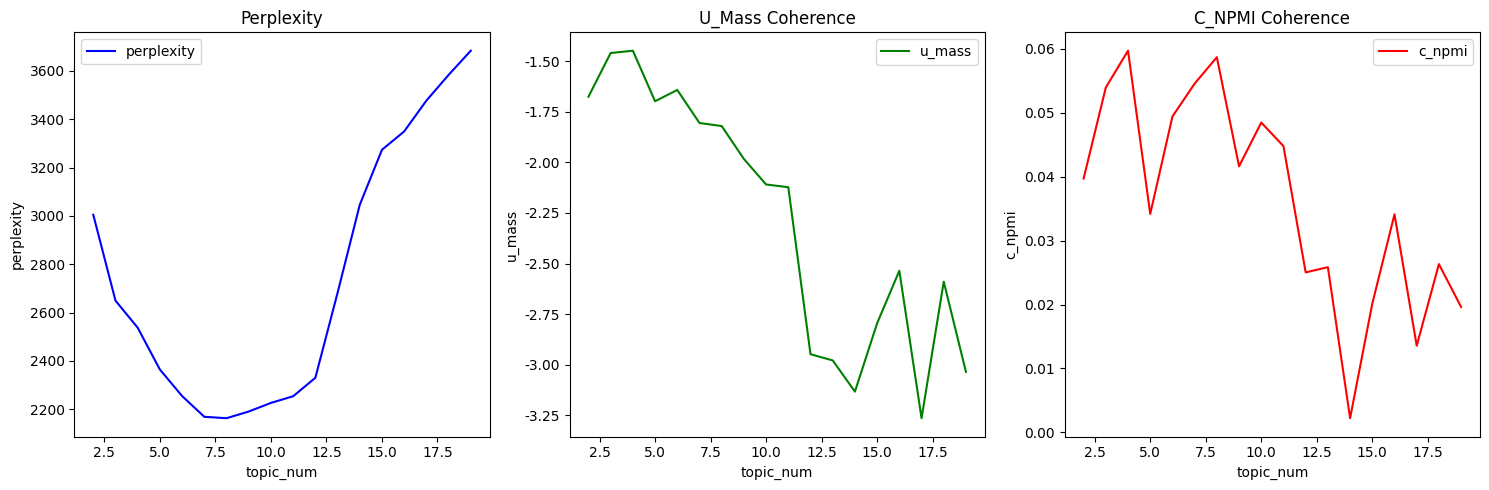

In [ ]:
import matplotlib.pyplot as plt

# 創建 1 行 3 列的子圖布局
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# 第一個子圖：Perplexity
result.plot.line(x='topic_num', y='perplexity', ax=axs[0], color='blue')
axs[0].set_title('Perplexity')
axs[0].set_xlabel('topic_num')
axs[0].set_ylabel('perplexity')

# 第二個子圖：U_Mass
result.plot.line(x='topic_num', y='u_mass', ax=axs[1], color='green')
axs[1].set_title('U_Mass Coherence')
axs[1].set_xlabel('topic_num')
axs[1].set_ylabel('u_mass')

# 第三個子圖：C_NPMI
result.plot.line(x='topic_num', y='c_npmi', ax=axs[2], color='red')
axs[2].set_title('C_NPMI Coherence')
axs[2].set_xlabel('topic_num')
axs[2].set_ylabel('c_npmi')

# 調整子圖之間的間距
plt.tight_layout()

# 顯示圖表
plt.show()

##### 2.5.4 定義最佳主題數

- Perplexity (複雜度)：<br>
從第一張圖可以看出，perplexity 在主題數為 8-10 時達到最低點，表示此時模型的預測能力最佳。數值越低越好，因此這裡建議主題數為 8-10。

- U_Mass 一致性：<br>
從第二張圖可以看出，U_Mass 值在主題數增加時總體趨勢是下降的，但在主題數為 18 左右開始回升。由於 U_Mass 是負值且越接近 0 越好，所以從這個指標來看，較低的主題數（如 2-8）可能更合適。
- C_NPMI 一致性：<br>
從第三張圖可以看出，C_NPMI 在主題數為 8 時達到明顯的峰值。由於 C_NPMI 越高表示主題內部詞彙的語義關聯越強，因此從這個指標來看，8 個主題是最佳選擇。

`因此就訓練結果來看topic_num = 8為最佳。` 

#### 2.6 嘗試其他主題數

LDAvis 是我們經常會使用的視覺化工具，目的為幫助我們解釋主題模型中，在我們建構好主題模型得到 θ(文件的主題分佈) 跟 φ(主題的字分佈)，透過 pyLDAvis 將主題降維成二維，以網頁的形式供我們查看。

+ 圓圈數量代表主題數量，有幾個主題就會有幾個圓圈
+ 圓越大代表 document 越大
+ 右邊可以看到主題的字分佈
+ 右上幫有一個 bar 調整 lambda：當 lambda=1 也就是代表本來的字分佈 φ，將 lambda 縮越小可以看到越唯一的字，好的分佈是 φ 高且唯一，因此我們要在這兩者間取平衡
+ 圓心越相近，代表主題會越相似；反之，圓心分越開代表主題有唯一性<br>
  --> 假設詞彙本來有 100 字，維度應該是 100，假如本來維度接近(相近)的話，降維後也會接近(相近)

##### 2.6.1 Best Model (num_topics = 8)

In [ ]:
best_model = LdaModel(
    corpus = corpus,
    num_topics = 8,
    id2word=dictionary,
    random_state = 2025,
    passes = 5 # 訓練次數
    )

2025-04-16 19:32:50,372 : INFO : using symmetric alpha at 0.125
2025-04-16 19:32:50,372 : INFO : using symmetric eta at 0.125
2025-04-16 19:32:50,374 : INFO : using serial LDA version on this node
2025-04-16 19:32:50,382 : INFO : running online (multi-pass) LDA training, 8 topics, 5 passes over the supplied corpus of 5776 documents, updating model once every 2000 documents, evaluating perplexity every 5776 documents, iterating 50x with a convergence threshold of 0.001000
2025-04-16 19:32:50,383 : INFO : PROGRESS: pass 0, at document #2000/5776
2025-04-16 19:32:51,462 : INFO : merging changes from 2000 documents into a model of 5776 documents
2025-04-16 19:32:51,466 : INFO : topic #0 (0.125): 0.008*"東森" + 0.006*"表示" + 0.006*"新聞" + 0.004*"台灣" + 0.004*"網友" + 0.004*"今日" + 0.003*"掌握" + 0.003*"粉絲" + 0.003*"美國" + 0.003*"節目"
2025-04-16 19:32:51,469 : INFO : topic #6 (0.125): 0.010*"表示" + 0.007*"東森" + 0.007*"新聞" + 0.005*"台灣" + 0.004*"粉絲" + 0.004*"希望" + 0.003*"節目" + 0.003*"今年" + 0.003*"透露" + 0.0

In [ ]:
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim_models.prepare(best_model, corpus, dictionary)
p

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.091996  0.104565       1        1  23.463174
6      0.206058  0.190942       2        1  16.857532
1     -0.243675  0.093053       3        1  16.692341
3     -0.057880  0.009341       4        1  12.577303
5     -0.085709 -0.045705       5        1  11.091596
4      0.118322 -0.089318       6        1   8.409933
7     -0.142266 -0.041686       7        1   6.435933
0      0.113154 -0.221193       8        1   4.472188, topic_info=     Term         Freq        Total Category  logprob  loglift
1921  中華隊  2544.000000  2544.000000  Default  30.0000  30.0000
134    川普  1548.000000  1548.000000  Default  29.0000  29.0000
50     美國  1720.000000  1720.000000  Default  28.0000  28.0000
5330   警方  2030.000000  2030.000000  Default  27.0000  27.0000
240    台灣  3041.000000  3041.000000  Default  26.0000  26.0000
...   ...          ...          ...      ...      ...      ...
93     立場   131.394291   744.362668   Topic8  -5.1920   1.3730
240    台灣   131.811207  3041.360862   Topic8  -5.1888  -0.0314
74     出現   102.596611   607.795322   Topic8  -5.4394   1.3283
157    認為    92.578532   898.035493   Topic8  -5.5421   0.8351
221    中國    89.156295   788.393877   Topic8  -5.5798   0.9277

[596 rows x 6 columns], token_table=      Topic      Freq Term
term                      
1016      1  0.024095   一名
1016      2  0.016522   一名
1016      3  0.528031   一名
1016      4  0.267113   一名
1016      5  0.070220   一名
...     ...       ...  ...
944       5  0.172985   高雄
944       7  0.241705   高雄
7122      7  0.960664   鬧事
2884      6  0.977510  黎巴嫩
6975      5  0.981971  黨主席

[1713 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 7, 2, 4, 6, 5, 8, 1])

看到「4,5,7」的圓心距離接近，因此這三個主題可能有相關性，把他們的詞彙拉出來看。

In [ ]:
best_model.show_topics()

[(0,
  '0.015*"東森" + 0.011*"台積電" + 0.011*"美國" + 0.010*"新聞" + 0.008*"川普" + 0.008*"馬斯克" + 0.007*"台股" + 0.007*"晶片" + 0.007*"指數" + 0.006*"公司"'),
 (1,
  '0.019*"警方" + 0.016*"男子" + 0.013*"發生" + 0.009*"東森" + 0.009*"一名" + 0.008*"新聞" + 0.008*"駕駛" + 0.008*"民眾" + 0.006*"現場" + 0.006*"女子"'),
 (2,
  '0.010*"表示" + 0.009*"粉絲" + 0.006*"網友" + 0.006*"東森" + 0.005*"新聞" + 0.005*"生活" + 0.004*"分享" + 0.004*"希望" + 0.004*"演唱會" + 0.004*"加入"'),
 (3,
  '0.010*"報導" + 0.009*"表示" + 0.009*"發現" + 0.009*"新聞" + 0.008*"東森" + 0.006*"一名" + 0.006*"女兒" + 0.005*"網友" + 0.005*"更多" + 0.005*"媽媽"'),
 (4,
  '0.031*"川普" + 0.026*"美國" + 0.015*"總統" + 0.011*"台灣" + 0.009*"中國" + 0.007*"賀錦麗" + 0.006*"表示" + 0.005*"國家" + 0.005*"拜登" + 0.005*"大選"'),
 (5,
  '0.008*"調查" + 0.008*"新聞" + 0.007*"霸凌" + 0.007*"立委" + 0.007*"東森" + 0.006*"法院" + 0.005*"勞動部" + 0.005*"行為" + 0.005*"表示" + 0.005*"指控"'),
 (6,
  '0.029*"中華隊" + 0.020*"台灣" + 0.015*"日本" + 0.013*"世界" + 0.012*"球迷" + 0.011*"棒球" + 0.010*"東森" + 0.010*"投手" + 0.008*"陳傑憲" + 0.008*"比賽"'),
 (7,
  '0.010*"萬元" +

主題 2 : [ 中華隊, 台灣, 日本, 世界, 球迷, 棒球, 投手, 陳傑憲, 比賽 ] <br>
明確劃分出棒球運動相關，特別是台灣中華隊相關的報導和賽事。(正值12強棒球賽)

-------------------------
主題 4: [ 報導, 發現, 女兒, 網友, 媽媽 ] <br>
主題 5: [ 調查, 霸凌, 立委, 法院, 勞動部, 行為, 指控 ] <br>
主題 7: [ 萬元, 警方, 詐騙, 集團, 發現, 公司, 機場] <br>

使用 Claude 對於主題模型的解釋，三個主題都與「社會問題」或「社會事件」有關，但從不同角度切入：

主題 4：偏向家庭/親子關係的社會關注議題，常透過網友或媒體報導被發現 <br>
主題 5：偏向正式調查和法律程序的社會爭議，特別是職場或政治環境中的不當行為 <br>
主題 7：偏向經濟犯罪和詐騙案件的社會治安問題 <br>

反映出媒體對社會問題的關注、社會規範的維護，以及處理社會衝突的不同機制，從家庭層面到法律層面再到執法層面。

**另外，也發現原新聞的「健康版」與「社會版」內容被劃分為類似主題，可能因為「健康版」新聞數量過少 (71篇) 難以被歸為一類。**


##### 2.6.2 num_topics = 12

In [ ]:
model_12 = LdaModel(
    corpus = corpus,
    num_topics = 12,
    id2word=dictionary,
    random_state = 2025,
    passes = 5 # 訓練次數
    )

2025-04-17 00:23:01,321 : INFO : using symmetric alpha at 0.08333333333333333
2025-04-17 00:23:01,322 : INFO : using symmetric eta at 0.08333333333333333
2025-04-17 00:23:01,323 : INFO : using serial LDA version on this node
2025-04-17 00:23:01,334 : INFO : running online (multi-pass) LDA training, 12 topics, 5 passes over the supplied corpus of 5776 documents, updating model once every 2000 documents, evaluating perplexity every 5776 documents, iterating 50x with a convergence threshold of 0.001000
2025-04-17 00:23:01,335 : INFO : PROGRESS: pass 0, at document #2000/5776
2025-04-17 00:23:02,336 : INFO : merging changes from 2000 documents into a model of 5776 documents
2025-04-17 00:23:02,341 : INFO : topic #9 (0.083): 0.007*"柯文哲" + 0.006*"演唱會" + 0.006*"表示" + 0.006*"新聞" + 0.005*"東森" + 0.005*"歌迷" + 0.004*"世界" + 0.004*"粉絲" + 0.004*"台灣" + 0.004*"今日"
2025-04-17 00:23:02,342 : INFO : topic #2 (0.083): 0.014*"粉絲" + 0.008*"表示" + 0.007*"東森" + 0.006*"新聞" + 0.005*"最佳" + 0.005*"電影" + 0.004*"劉德華"

In [ ]:
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim_models.prepare(model_12, corpus, dictionary)
p

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.127515 -0.062868       1        1  20.398364
6     -0.178475 -0.256346       2        1  15.344190
1      0.239324 -0.065708       3        1  10.203421
3     -0.008891  0.056369       4        1   8.616636
10    -0.017669  0.147253       5        1   8.534469
8      0.178682  0.063231       6        1   7.506494
11    -0.157354  0.037725       7        1   6.969420
4     -0.072769  0.010770       8        1   5.719643
7      0.158324 -0.097961       9        1   5.544534
5     -0.008153  0.110731      10        1   5.181232
0     -0.165952  0.098712      11        1   3.072215
9      0.160447 -0.041908      12        1   2.909384, topic_info=     Term         Freq        Total Category  logprob  loglift
1921  中華隊  2617.000000  2617.000000  Default  30.0000  30.0000
134    川普  1548.000000  1548.000000  Default  29.0000  29.0000
50     美國  1705.000000  1705.000000  Default  28.0000  28.0000
5330   警方  2043.000000  2043.000000  Default  27.0000  27.0000
1427   男子  1555.000000  1555.000000  Default  26.0000  26.0000
...   ...          ...          ...      ...      ...      ...
5      今天    76.413033  1052.131778  Topic12  -5.3041   0.9148
1473   遭到    65.554093   436.977328  Topic12  -5.4574   1.6402
1199   北市    63.874435   387.542299  Topic12  -5.4833   1.7343
539    萬元    63.572024   614.138131  Topic12  -5.4881   1.2692
585    相關    60.467385   610.552652  Topic12  -5.5381   1.2250

[877 rows x 6 columns], token_table=      Topic      Freq Term
term                      
1016      1  0.008326   一名
1016      2  0.011795   一名
1016      3  0.276842   一名
1016      4  0.128361   一名
1016      5  0.063833   一名
...     ...       ...  ...
7026     10  0.972516  黃國昌
7365      3  0.988719   黃姓
5568      5  0.093286  黃曉明
5568     10  0.886213  黃曉明
6837     10  0.972500   黨團

[2970 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 7, 2, 4, 11, 9, 12, 5, 8, 6, 1, 10])

In [ ]:
model_12.show_topics()

[(6,
  '0.032*"中華隊" + 0.022*"台灣" + 0.017*"日本" + 0.015*"世界" + 0.013*"球迷" + 0.012*"棒球" + 0.011*"投手" + 0.010*"東森" + 0.009*"陳傑憲" + 0.009*"比賽"'),
 (7,
  '0.015*"發生" + 0.011*"人員" + 0.011*"現場" + 0.008*"民眾" + 0.007*"東森" + 0.007*"目前" + 0.007*"死亡" + 0.006*"今天" + 0.006*"原因" + 0.006*"調查"'),
 (9,
  '0.016*"柯文哲" + 0.013*"毒品" + 0.011*"肇事" + 0.010*"路口" + 0.010*"偵辦" + 0.008*"地檢署" + 0.008*"馬路" + 0.008*"上壘" + 0.007*"民眾" + 0.007*"羈押"'),
 (10,
  '0.013*"公司" + 0.009*"萬元" + 0.009*"報導" + 0.009*"新聞" + 0.008*"東森" + 0.008*"週刊" + 0.005*"詐騙" + 0.005*"集團" + 0.005*"兩人" + 0.005*"妻子"'),
 (1,
  '0.019*"男子" + 0.018*"警方" + 0.013*"駕駛" + 0.012*"發生" + 0.011*"民眾" + 0.009*"東森" + 0.009*"新聞" + 0.007*"一名" + 0.007*"機車" + 0.006*"騎士"'),
 (0,
  '0.025*"東森" + 0.014*"新聞" + 0.012*"指數" + 0.011*"台股" + 0.011*"台積電" + 0.009*"授權" + 0.009*"轉載" + 0.009*"代表" + 0.009*"言論" + 0.008*"立場"'),
 (11,
  '0.042*"川普" + 0.036*"美國" + 0.019*"總統" + 0.010*"台灣" + 0.009*"中國" + 0.008*"賀錦麗" + 0.007*"大選" + 0.006*"拜登" + 0.006*"烏克蘭" + 0.006*"國家"'),
 (2,
  '0.010*"粉絲"

##### 2.6.3 num_topics = 5

In [ ]:
model_5 = LdaModel(
    corpus = corpus,
    num_topics = 5,
    id2word=dictionary,
    random_state = 2025,
    passes = 5 # 訓練次數
    )

2025-04-17 00:21:09,432 : INFO : using symmetric alpha at 0.2
2025-04-17 00:21:09,434 : INFO : using symmetric eta at 0.2
2025-04-17 00:21:09,439 : INFO : using serial LDA version on this node
2025-04-17 00:21:09,446 : INFO : running online (multi-pass) LDA training, 5 topics, 5 passes over the supplied corpus of 5776 documents, updating model once every 2000 documents, evaluating perplexity every 5776 documents, iterating 50x with a convergence threshold of 0.001000
2025-04-17 00:21:09,451 : INFO : PROGRESS: pass 0, at document #2000/5776
2025-04-17 00:21:10,489 : INFO : merging changes from 2000 documents into a model of 5776 documents
2025-04-17 00:21:10,492 : INFO : topic #0 (0.200): 0.008*"東森" + 0.006*"表示" + 0.006*"新聞" + 0.004*"台灣" + 0.004*"今日" + 0.003*"網友" + 0.003*"公司" + 0.003*"掌握" + 0.003*"粉絲" + 0.003*"節目"
2025-04-17 00:21:10,493 : INFO : topic #1 (0.200): 0.008*"表示" + 0.007*"東森" + 0.007*"新聞" + 0.006*"台灣" + 0.004*"粉絲" + 0.004*"生活" + 0.004*"今日" + 0.004*"網友" + 0.003*"掌握" + 0.003*"

In [ ]:
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim_models.prepare(model_5, corpus, dictionary)
p

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.107986 -0.096606       1        1  27.013723
4      0.215469  0.003492       2        1  21.981395
1     -0.216535 -0.097486       3        1  20.651504
3     -0.047958 -0.017365       4        1  16.898677
0     -0.058962  0.207966       5        1  13.454701, topic_info=     Term         Freq        Total Category  logprob  loglift
1921  中華隊  2488.000000  2488.000000  Default  30.0000  30.0000
5330   警方  2011.000000  2011.000000  Default  29.0000  29.0000
1427   男子  1526.000000  1526.000000  Default  28.0000  28.0000
134    川普  1398.000000  1398.000000  Default  27.0000  27.0000
240    台灣  3072.000000  3072.000000  Default  26.0000  26.0000
...   ...          ...          ...      ...      ...      ...
299    表示   275.646431  3188.146178   Topic5  -5.5525  -0.4422
50     美國   241.683742  1678.717708   Topic5  -5.6840   0.0677
21     報導   228.134362  1639.204164   Topic5  -5.7417   0.0338
549    進行   201.779421   947.283863   Topic5  -5.8644   0.4594
240    台灣   189.174816  3072.673207   Topic5  -5.9289  -0.7818

[414 rows x 6 columns], token_table=      Topic      Freq Term
term                      
1016      1  0.030512   一名
1016      2  0.024964   一名
1016      3  0.628960   一名
1016      4  0.275993   一名
1016      5  0.040220   一名
...     ...       ...  ...
7212      2  0.991052  黃子鵬
4928      2  0.018851   點多
4928      3  0.961391   點多
4928      4  0.006284   點多
4928      5  0.006284   點多

[1058 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 5, 2, 4, 1])

In [ ]:
model_5.print_topics(num_words=20)

2025-04-17 00:24:48,512 : INFO : topic #0 (0.200): 0.009*"東森" + 0.008*"公司" + 0.008*"新聞" + 0.006*"調查" + 0.006*"萬元" + 0.004*"指出" + 0.004*"相關" + 0.004*"柯文哲" + 0.004*"表示" + 0.004*"台積電" + 0.004*"法院" + 0.004*"集團" + 0.004*"認為" + 0.004*"今年" + 0.004*"中國" + 0.003*"要求" + 0.003*"美國" + 0.003*"週刊" + 0.003*"立場" + 0.003*"言論"
2025-04-17 00:24:48,513 : INFO : topic #1 (0.200): 0.018*"警方" + 0.013*"男子" + 0.011*"發生" + 0.008*"一名" + 0.008*"東森" + 0.008*"新聞" + 0.007*"民眾" + 0.006*"駕駛" + 0.006*"發現" + 0.006*"女子" + 0.005*"現場" + 0.005*"關心" + 0.004*"人員" + 0.004*"疑似" + 0.004*"員警" + 0.004*"調查" + 0.004*"行為" + 0.003*"機車" + 0.003*"送醫" + 0.003*"畫面"
2025-04-17 00:24:48,515 : INFO : topic #2 (0.200): 0.009*"表示" + 0.008*"粉絲" + 0.006*"網友" + 0.006*"東森" + 0.005*"新聞" + 0.005*"台灣" + 0.005*"生活" + 0.004*"希望" + 0.004*"分享" + 0.004*"加入" + 0.004*"翻攝" + 0.003*"兩人" + 0.003*"現場" + 0.003*"大小事" + 0.003*"掌握" + 0.003*"今日" + 0.003*"透露" + 0.003*"演唱會" + 0.003*"影片" + 0.003*"節目"
2025-04-17 00:24:48,517 : INFO : topic #3 (0.200): 0.009*"報導" + 0.008

[(0,
  '0.009*"東森" + 0.008*"公司" + 0.008*"新聞" + 0.006*"調查" + 0.006*"萬元" + 0.004*"指出" + 0.004*"相關" + 0.004*"柯文哲" + 0.004*"表示" + 0.004*"台積電" + 0.004*"法院" + 0.004*"集團" + 0.004*"認為" + 0.004*"今年" + 0.004*"中國" + 0.003*"要求" + 0.003*"美國" + 0.003*"週刊" + 0.003*"立場" + 0.003*"言論"'),
 (1,
  '0.018*"警方" + 0.013*"男子" + 0.011*"發生" + 0.008*"一名" + 0.008*"東森" + 0.008*"新聞" + 0.007*"民眾" + 0.006*"駕駛" + 0.006*"發現" + 0.006*"女子" + 0.005*"現場" + 0.005*"關心" + 0.004*"人員" + 0.004*"疑似" + 0.004*"員警" + 0.004*"調查" + 0.004*"行為" + 0.003*"機車" + 0.003*"送醫" + 0.003*"畫面"'),
 (2,
  '0.009*"表示" + 0.008*"粉絲" + 0.006*"網友" + 0.006*"東森" + 0.005*"新聞" + 0.005*"台灣" + 0.005*"生活" + 0.004*"希望" + 0.004*"分享" + 0.004*"加入" + 0.004*"翻攝" + 0.003*"兩人" + 0.003*"現場" + 0.003*"大小事" + 0.003*"掌握" + 0.003*"今日" + 0.003*"透露" + 0.003*"演唱會" + 0.003*"影片" + 0.003*"節目"'),
 (3,
  '0.009*"報導" + 0.008*"表示" + 0.008*"新聞" + 0.007*"東森" + 0.006*"發現" + 0.004*"一名" + 0.004*"更多" + 0.004*"女兒" + 0.004*"網友" + 0.004*"工作" + 0.004*"發生" + 0.004*"指出" + 0.004*"代表" + 0.004*"進行" +

**主題 0: 政經/司法議題**
- 關鍵詞：公司、調查、萬元、柯文哲、台積電、法院、集團、中國、美國、週刊
- 這似乎是一個混合主題，包含政治人物(柯文哲)、經濟實體(台積電、公司)、司法(法院、調查)和國際關係(中國、美國)的新聞

**主題 1: 社會案件/事故**
- 關鍵詞：警方、男子、發生、民眾、駕駛、發現、女子、現場、關心、人員、疑似、員警
- 這明顯涵蓋了社會案件、意外事故、治安事件等社會新聞

**主題 2: 娛樂/生活**
- 關鍵詞：粉絲、網友、台灣、生活、希望、分享、加入、翻攝、兩人、演唱會、影片、節目
- 這包含了娛樂新聞、社交媒體話題、生活資訊等輕鬆話題

**主題 3: 輿論/社會觀點**
- 關鍵詞：報導、表示、發現、網友、女兒、工作、代表、授權、轉載、孩子、言論、立場
- 這主題似乎涉及媒體報導、言論立場、社會觀點分享等與輿論相關的內容

**主題 4: 體育/國際政治**
- 關鍵詞：中華隊、台灣、川普、日本、美國、世界、球迷、棒球、投手、陳傑憲、比賽、總統
- 這是一個混合了體育(棒球、中華隊)和國際政治(川普、總統、美國)的主題

#### 2.7 小結
原本的新聞資料集 主題數 為7，仍有部分主題重疊沒有被完整劃分。
接著透過 （perplexity, pmi, U_mass） 這三個指標來找出最佳的主題數，之後再透過 LDAvis 來看各個主題的分佈，進而找出最佳的主題數。

先以指標所顯示的最佳主題數 8 作為主題數，透過 LDAvis 來看各個主題的分佈，
發現主題(4, 5, 7)的圓心距離接近，並且有高度重疊，推測這些主題仍有相關性，並沒有做到最好的區隔。

在主題數 ＝ 5 的情況下，各個主題的圓圈並不重疊，代表說在這個主題數下，各個主題是相對獨立的。